In [108]:
#from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
#from thllib import util
import figurefirst as fifi
import scipy.signal
#import local_project_functions as lpf
from IPython.display import SVG,display
import networkx as nx


import flylib as flb
#from thllib import flylib as flb
import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from flylib import util
import figurefirst as fifi
import scipy.signal
#import local_project_functions as lpf
from IPython.display import SVG,display
import pandas as pd
import networkx as nx

In [109]:
from scipy.stats import gaussian_kde

In [110]:
%matplotlib inline

In [111]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]

In [112]:
fly_nums = range(1389,1402)#,1545)
multi_fly_df = util.construct_multi_fly_df(fly_nums)

Making dataframe for fly number 1389
Making dataframe for fly number 1390
Making dataframe for fly number 1391
Making dataframe for fly number 1392
Making dataframe for fly number 1393
Making dataframe for fly number 1394
Making dataframe for fly number 1395
Making dataframe for fly number 1396
Making dataframe for fly number 1397
Making dataframe for fly number 1398
Making dataframe for fly number 1399
Making dataframe for fly number 1400
Making dataframe for fly number 1401


In [5]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

flydict = {}
for fly in flylist:
    flydict[fly.flynum] = fly
    
stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')]

In [6]:
print(multi_fly_df.columns.values)
print(np.unique(multi_fly_df['stimulus']))

idx = (multi_fly_df['stimulus']=='cl_blocks, g_x=-1, g_y=0, b_x=-8, b_y=0, ch=True')& \
        ((multi_fly_df['amp_diff']>0.1)&(multi_fly_df['amp_diff']<0.104))


['t' 'stimulus' 'amp_diff' 'left_amp' 'right_amp' 'fly_num' 'wbf'
 'experimental_condition' 'pr_left' 'tpd_left' 'nm_left' 'iii1_left'
 'iii3_left' 'i2_left' 'hg2_left' 'hg3_left' 'hg1_left' 'i1_left'
 'bkg_left' 'b1_left' 'b2_left' 'b3_left' 'iii24_left' 'hg4_left'
 'pr_right' 'tpd_right' 'nm_right' 'iii1_right' 'iii3_right' 'i2_right'
 'hg2_right' 'hg3_right' 'hg1_right' 'i1_right' 'bkg_right' 'b1_right'
 'b2_right' 'b3_right' 'iii24_right' 'hg4_right']
['cl_blocks, g_x=-1, g_y=-4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=-4 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=-8, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=0, b_y=0'
 'cl_blocks, g_x=-1, g_y=4 b_x=8, b_y=0'
 'ol_blocks, g_x=-12, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=-4 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=0 b_x=0, b_y=0'
 'ol_blocks, g_x=0, g_y=4 b_x=0, b_y=0'
 '

In [7]:
muscle_key_list = ('Lb1', 'Lb2', 'Lb3', 'Li1', 'Li2', 'Liii1', 'Liii3',  'Lhg1', 'Lhg2', 'Lhg3', 'Lhg4', 
                   'Rb1', 'Rb2', 'Rb3', 'Ri1', 'Ri2', 'Riii1', 'Riii3',  'Rhg1', 'Rhg2', 'Rhg3', 'Rhg4') 

In [92]:
fly.non_neg_signals['right', 'hg2']

array([ 0.19662173,  0.19662173,  0.19662173, ...,  0.        ,
        0.        ,  0.        ])

In [9]:
def key_to_key(inkey):
    """map the input key from the cov_mtrx_triang_layout.svg into a set of keys 
    (a tuple of tuples) that can be used to construct signals from the fly data"""
    try:
        k1 = {'R':'right','L':'left'}[inkey[0]]
    except KeyError:
        if inkey[0] == 'w':
            return ('common','wb_freq')
        else:
            return
    k2 = inkey[1:]
    return (k1,k2)

In [114]:
def make_scatter_plots(fly):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)
        
        already_plotted = []

        for key1 in muscle_key_list:
            for key2 in muscle_key_list:
                try:
                    
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    
                    keys = (key1, key2)
                    keys_inverse = (key2, key1)
                    
                    if keys in already_plotted:
                        #do nothing
                        continue
                    if keys_inverse in already_plotted:
                        #do nothing
                        continue
                        
                    else:
                        fig, ax = plt.subplots()                
                        dta1 = fly.non_neg_signals[dkeys[0]]#[::5]#[dmask][::50]
                        dta2 = fly.non_neg_signals[dkeys[1]]#[::5]#[dmask][::50]

                        # Calculate the point density
                        #xy = np.vstack([dta1.ravel(),dta2.ravel()])
                        
                        #kernel = gaussian_kde((xy)(xy))
                        
                        #z=np.reshape(kernel(xy).T, dta1.shape)
                        
                        heatmap, xedges, yedges = np.histogram2d(dta1, dta2, bins=10) #50 or 100  20
                        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
                        print(np.shape(heatmap))
                        
                        
                        '''
                        ax.scatter(dta1,dta2,
                                   marker = '.',
                                   s = 5,  #0.5
                                   #color = 'black',
                                   color = z,
                                   alpha = 0.5,
                                   edgecolors = 'none',
                                   rasterized = True)
                        '''
                        ax.set_xbound(0,1)
                        ax.set_ybound(0,1)
                        
                        plt.rcParams['image.cmap'] = 'gray'
                        
                        
                        plt.clf()
                        plt.imshow(heatmap.T, interpolation= 'nearest', extent=extent, origin='lower')

                        x = np.random.normal(2, 1, 100)


                        plt.show()
                        fig.savefig('%s_%s.jpg' % (key1, key2))
                        # convert array into dataframe 
                        DF = pd.DataFrame(heatmap) 
                        print(np.shape(heatmap))
                        print(DF)

                        # save the dataframe as a csv file 
                        DF.to_csv('%s_%s.csv' % (key1, key2))

                        already_plotted.append(keys)  
                        already_plotted.append(keys_inverse) 
                        
                        #fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
            
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))

In [113]:
def make_massive_array(fly):
    """create summary plot for each fly in flylist, uses the template 
    file cov_matrix_triang_layout.svg, the hdf5 data of each fly needs to 
    be loaded"""
    if 'data_mask' in fly.h5files.keys():
        #fifi.mpl_functions.kill_all_spines(layout)
        dmask = np.array(fly.data_mask)
        
        already_plotted = []

        for key1 in muscle_key_list:
            for key2 in muscle_key_list:
                try:
                    
                    dkeys = (key_to_key(key1),key_to_key(key2))
                    
                    keys = (key1, key2)
                    keys_inverse = (key2, key1)
                    
                    if keys in already_plotted:
                        #do nothing
                        continue
                    if keys_inverse in already_plotted:
                        #do nothing
                        continue
                        
                    else:
                        fig, ax = plt.subplots()                
                        dta1 = fly.non_neg_signals[dkeys[0]]#[::5]#[dmask][::50]
                        dta2 = fly.non_neg_signals[dkeys[1]]#[::5]#[dmask][::50]

                        # Calculate the point density
                        #xy = np.vstack([dta1.ravel(),dta2.ravel()])
                        
                        #kernel = gaussian_kde((xy)(xy))
                        
                        #z=np.reshape(kernel(xy).T, dta1.shape)
                        
                        heatmap, xedges, yedges = np.histogram2d(dta1, dta2, bins=10) #50 or 100  #20
                        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
                        print(np.shape(heatmap))
                        
                        
                        '''
                        ax.scatter(dta1,dta2,
                                   marker = '.',
                                   s = 5,  #0.5
                                   #color = 'black',
                                   color = z,
                                   alpha = 0.5,
                                   edgecolors = 'none',
                                   rasterized = True)
                        '''
                        ax.set_xbound(0,1)
                        ax.set_ybound(0,1)
                        
                        plt.rcParams['image.cmap'] = 'gray'
                        
                        
                        plt.clf()
                        plt.imshow(heatmap.T, interpolation= 'nearest', extent=extent, origin='lower')

                        x = np.random.normal(2, 1, 100)


                        plt.show()
                        # convert array into dataframe 
                        DF = pd.DataFrame(H) 

                        # save the dataframe as a csv file 
                        full_array.append(H)
                        
                        already_plotted.append(keys_inverse) 
                        
                        #fifi.mpl_functions.kill_spines(ax)
                except KeyError:
                    if key == 'flynum':
                        ax.text(0,0,'Fly%s'%fly.flynum,size = 20)
                    else:
                        pass
            #layout.save('scatter_matrix_%s.svg'%fly.flynum)
            #plt.close('all')
            
        #display(SVG('scatter_matrix_%s.svg'%fly.flynum))

In [ ]:
import os
import sys

full_array = []
file_names = []

for filename in os.listdir('2d_hist_csvs'):
    df=pd.read_csv(filename)
    arr = df.to_numpy()
    #image_sequence = image.getdata()
    #image_array = np.array(image_sequence)
    full_array.append(arr)
    file_names.append(filename)
    

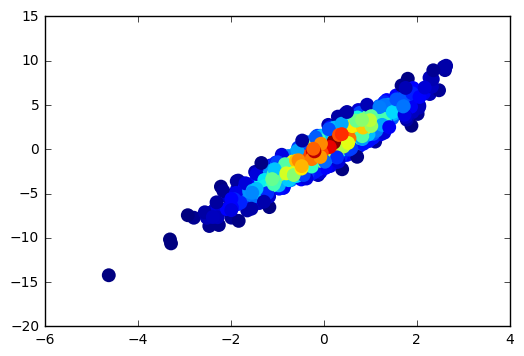

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = np.random.normal(size=1000)
y = x * 3 + np.random.normal(size=1000)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.show()

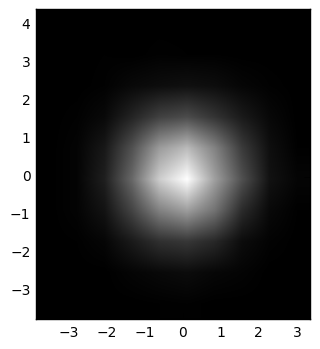

In [78]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

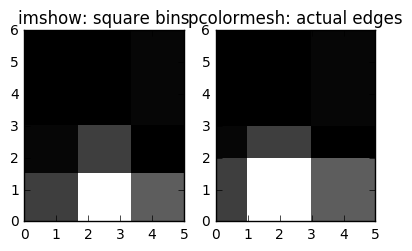

In [80]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
#Construct a 2-D histogram with variable bin width. First define the bin edges:

xedges = [0, 1, 3, 5]
yedges = [0, 2, 3, 4, 6]
#Next we create a histogram H with random bin content:

x = np.random.normal(2, 1, 100)
y = np.random.normal(1, 1, 100)
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
#imshow can only display square bins:

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#<matplotlib.image.AxesImage object at 0x...>
#pcolormesh can display actual edges:

ax = fig.add_subplot(132, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
#<matplotlib.collections.QuadMesh object at 0x...>

In [82]:
ax = fig.add_subplot(133, title='NonUniformImage: interpolated',
        aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
im = NonUniformImage(ax, interpolation='bilinear')
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
im.set_data(xcenters, ycenters, H)
ax.images.append(im)
plt.show()

In [89]:
#outfile = '%s/%s.jpg' % (self.tgtdir, self.basename)

(10, 10)


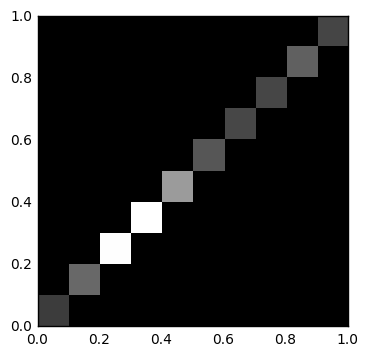

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  2350.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  4021.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  9810.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  9868.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0  5988.0     0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0  3349.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0  2772.0     0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0  2735.0     0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  3737.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  2670.0  
(10, 10)


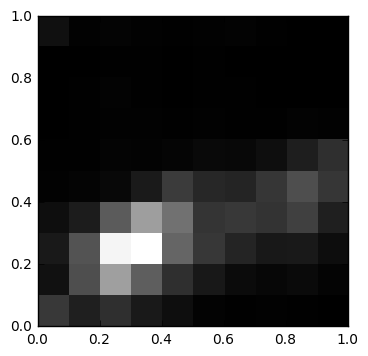

(10, 10)
       0       1       2       3       4      5     6     7     8      9
0  985.0   309.0   443.0   246.0    44.0   21.0   5.0   3.0   8.0  286.0
1  547.0  1353.0  1432.0   488.0    74.0   25.0  31.0  20.0  16.0   35.0
2  813.0  2757.0  4237.0  1581.0   141.0   74.0  50.0  53.0  31.0   73.0
3  446.0  1622.0  4412.0  2726.0   455.0   66.0  41.0  33.0  19.0   48.0
4  252.0   817.0  1752.0  1959.0  1033.0   93.0  31.0  17.0  12.0   22.0
5   58.0   424.0   960.0   911.0   678.0  167.0  45.0  30.0  28.0   48.0
6   30.0   205.0   642.0   981.0   636.0  144.0  31.0  23.0  13.0   67.0
7   39.0   131.0   428.0   891.0   944.0  244.0  33.0   6.0   0.0   19.0
8   25.0   183.0   447.0  1117.0  1360.0  519.0  60.0  13.0   6.0    7.0
9    6.0    71.0   235.0   549.0   938.0  825.0  44.0   0.0   0.0    2.0
(10, 10)


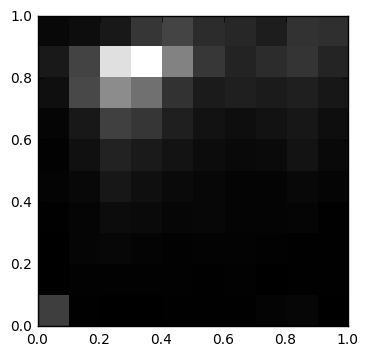

(10, 10)
        0     1      2      3      4      5       6       7       8       9
0  1139.0   8.0   11.0   34.0   90.0   52.0   101.0   294.0   467.0   154.0
1    39.0  54.0  106.0  105.0  158.0  302.0   449.0  1320.0  1243.0   245.0
2     9.0  49.0  145.0  233.0  428.0  643.0  1178.0  2572.0  4101.0   452.0
3    15.0  52.0   88.0  203.0  283.0  494.0  1007.0  2056.0  4672.0   998.0
4    40.0  58.0   62.0  128.0  195.0  368.0   585.0   922.0  2379.0  1251.0
5    43.0  28.0   66.0  137.0  137.0  231.0   352.0   500.0  1022.0   833.0
6    38.0  49.0   80.0   86.0   96.0  180.0   278.0   582.0   661.0   722.0
7    82.0  22.0   47.0   82.0   89.0  196.0   339.0   502.0   822.0   554.0
8   123.0  38.0   38.0  101.0  157.0  360.0   436.0   581.0   980.0   923.0
9    21.0  36.0   28.0   43.0  108.0  184.0   270.0   438.0   670.0   872.0
(10, 10)


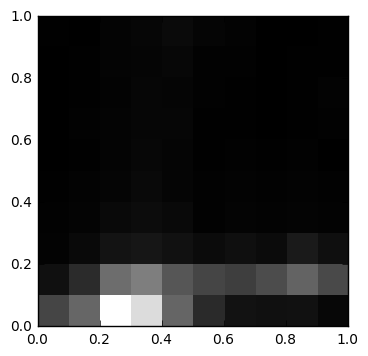

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  1615.0   400.0   93.0   60.0   45.0   26.0   20.0   18.0   28.0   45.0
1  2378.0  1013.0  230.0  109.0   80.0   38.0   56.0   52.0   43.0   22.0
2  5922.0  2546.0  450.0  237.0  134.0  103.0  109.0   92.0  111.0  106.0
3  5111.0  2932.0  528.0  296.0  222.0  175.0  152.0  149.0  137.0  166.0
4  2342.0  2012.0  409.0  237.0  141.0  132.0  157.0  132.0  185.0  241.0
5   987.0  1607.0  268.0   71.0   63.0   48.0   41.0   56.0   78.0  130.0
6   432.0  1453.0  360.0  111.0   83.0   72.0   55.0   35.0   71.0  100.0
7   399.0  1776.0  279.0   91.0   65.0   40.0   31.0   27.0    9.0   18.0
8   402.0  2301.0  625.0  109.0   84.0   57.0   45.0   51.0   38.0   25.0
9   177.0  1707.0  368.0   98.0   61.0   31.0   60.0   81.0   46.0   41.0
(10, 10)


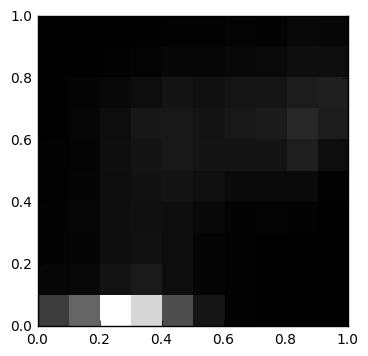

(10, 10)
        0      1      2      3      4      5       6      7      8      9
0  1698.0  172.0  108.0   97.0   66.0   61.0    52.0   44.0   38.0   14.0
1  2784.0  236.0  159.0  183.0  148.0  126.0   167.0  149.0   48.0   21.0
2  7017.0  545.0  403.0  406.0  357.0  395.0   369.0  224.0   69.0   25.0
3  5904.0  738.0  514.0  452.0  511.0  565.0   648.0  375.0  125.0   36.0
4  2156.0  367.0  373.0  383.0  556.0  672.0   664.0  551.0  195.0   71.0
5   581.0  161.0  148.0  232.0  415.0  572.0   524.0  462.0  190.0   64.0
6    67.0   62.0   81.0  104.0  292.0  571.0   672.0  586.0  222.0  115.0
7     8.0   22.0   34.0  129.0  290.0  570.0   745.0  592.0  249.0   96.0
8     0.0    0.0   11.0   87.0  286.0  833.0  1095.0  782.0  399.0  244.0
9     0.0    0.0    0.0    8.0   65.0  372.0   789.0  855.0  371.0  210.0
(10, 10)


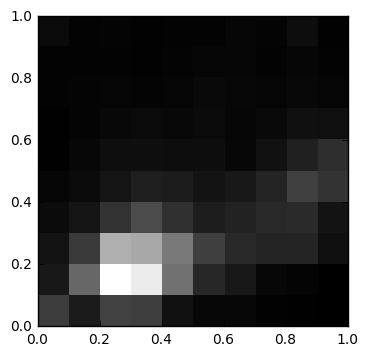

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1001.0   397.0   316.0   186.0    95.0   30.0   28.0   60.0   67.0  170.0
1   457.0  1678.0   943.0   340.0   185.0  126.0   86.0   76.0   70.0   60.0
2  1070.0  4124.0  2838.0   820.0   332.0  249.0  142.0   95.0   66.0   74.0
3  1015.0  3815.0  2723.0  1221.0   504.0  246.0  175.0   77.0   46.0   46.0
4   298.0  1836.0  1969.0   803.0   464.0  225.0  152.0  100.0   83.0   58.0
5   136.0   646.0  1030.0   485.0   328.0  230.0  176.0  157.0   95.0   66.0
6   131.0   398.0   672.0   565.0   407.0  122.0  121.0  128.0  110.0  118.0
7    53.0   133.0   591.0   657.0   594.0  295.0  166.0   92.0   70.0   84.0
8    29.0    79.0   610.0   696.0  1038.0  525.0  273.0  150.0  115.0  222.0
9     9.0    20.0   259.0   329.0   832.0  757.0  259.0   93.0   64.0   48.0
(10, 10)


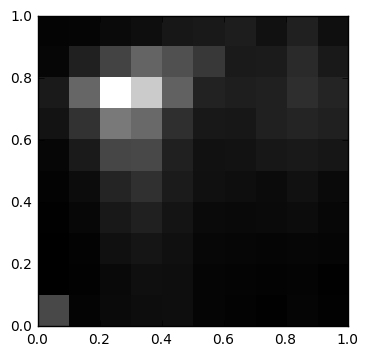

(10, 10)
        0      1      2      3      4       5       6       7       8      9
0  1129.0   27.0   19.0   41.0   71.0   123.0   323.0   422.0   112.0   83.0
1    83.0   65.0   67.0  134.0  219.0   430.0   801.0  1600.0   525.0   97.0
2   183.0  165.0  279.0  400.0  603.0  1100.0  1881.0  3958.0  1053.0  188.0
3   231.0  258.0  349.0  514.0  772.0  1129.0  1652.0  3149.0  1569.0  245.0
4   240.0  237.0  279.0  341.0  437.0   536.0   743.0  1539.0  1255.0  381.0
5   110.0  102.0  132.0  183.0  266.0   294.0   403.0   552.0   892.0  415.0
6    76.0   94.0  113.0  168.0  239.0   304.0   384.0   495.0   431.0  468.0
7    43.0   72.0   99.0  174.0  193.0   379.0   512.0   536.0   446.0  281.0
8   111.0   88.0  115.0  218.0  283.0   415.0   580.0   730.0   668.0  529.0
9    57.0   39.0   99.0  134.0  175.0   368.0   536.0   586.0   411.0  265.0
(10, 10)


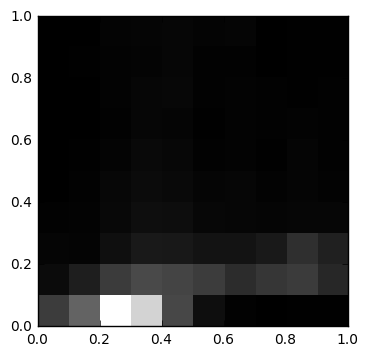

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  1623.0   325.0   160.0   71.0   37.0   37.0   29.0   25.0   18.0   25.0
1  2618.0   825.0   137.0  110.0   92.0   67.0   43.0   39.0   62.0   28.0
2  6739.0  1590.0   418.0  253.0  215.0  146.0   93.0   99.0  111.0  146.0
3  5570.0  1962.0   692.0  401.0  311.0  269.0  185.0  179.0  135.0  164.0
4  1887.0  1822.0   663.0  375.0  255.0  222.0  168.0  215.0  181.0  200.0
5   387.0  1601.0   541.0  215.0  151.0   76.0   64.0   82.0   91.0  141.0
6    73.0  1212.0   532.0  191.0  188.0  117.0  102.0  118.0   82.0  157.0
7    23.0  1459.0   693.0  155.0  109.0   70.0   77.0   75.0   32.0   42.0
8    61.0  1589.0  1270.0  186.0  168.0  168.0  121.0   63.0   57.0   54.0
9    51.0  1047.0   895.0  198.0  109.0   96.0   80.0   76.0   53.0   65.0
(10, 10)


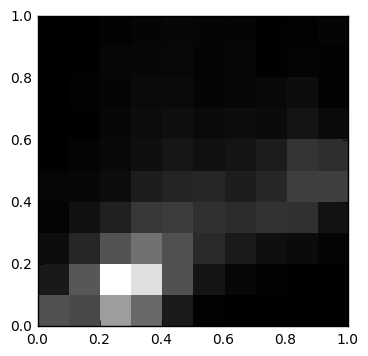

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1393.0   429.0   237.0    76.0   103.0   26.0   22.0   16.0   30.0   18.0
1  1258.0  1497.0   654.0   282.0   135.0   69.0   32.0   45.0   25.0   24.0
2  2679.0  4364.0  1415.0   573.0   228.0  150.0  124.0  102.0  110.0   65.0
3  1803.0  3807.0  1932.0   964.0   496.0  255.0  219.0  171.0  121.0  100.0
4   445.0  1382.0  1377.0  1027.0   645.0  385.0  259.0  186.0  148.0  134.0
5    46.0   349.0   716.0   830.0   677.0  286.0  172.0  100.0   79.0   94.0
6     0.0   124.0   460.0   760.0   508.0  354.0  236.0  127.0  104.0   99.0
7     0.0    35.0   261.0   863.0   677.0  484.0  199.0  161.0   22.0   33.0
8     0.0     3.0   195.0   848.0  1064.0  909.0  365.0  229.0   73.0   51.0
9     0.0     0.0    78.0   312.0  1075.0  789.0  202.0   68.0   46.0  100.0
(10, 10)


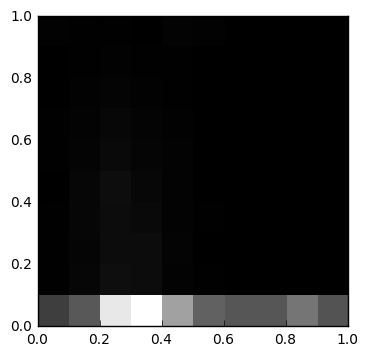

(10, 10)
        0      1      2      3      4      5      6      7     8      9
0  1971.0   38.0   45.0   57.0   29.0   58.0   38.0   31.0  15.0   68.0
1  2805.0  194.0  169.0  206.0  195.0  157.0  102.0   93.0  63.0   37.0
2  7359.0  445.0  400.0  387.0  417.0  293.0  231.0  129.0  86.0   63.0
3  8104.0  389.0  398.0  300.0  230.0  163.0  131.0   84.0  42.0   27.0
4  5111.0  121.0  151.0  108.0  118.0  104.0   64.0   60.0  42.0  109.0
5  3117.0   37.0   16.0   39.0   16.0   12.0   16.0    6.0  10.0   80.0
6  2745.0    5.0    4.0    3.0    8.0    1.0    2.0    2.0   2.0    0.0
7  2729.0    2.0    2.0    2.0    0.0    0.0    0.0    0.0   0.0    0.0
8  3720.0    8.0    6.0    3.0    0.0    0.0    0.0    0.0   0.0    0.0
9  2655.0    8.0    2.0    2.0    2.0    0.0    1.0    0.0   0.0    0.0
(10, 10)


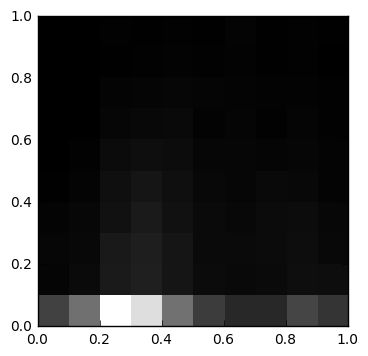

(10, 10)
        0      1      2      3      4      5      6      7      8      9
0  1787.0  140.0  184.0  127.0   33.0   23.0    6.0    6.0   14.0   30.0
1  3020.0  295.0  243.0  201.0  113.0   74.0   26.0   20.0    6.0   23.0
2  6847.0  711.0  680.0  461.0  413.0  301.0  167.0  127.0   41.0   62.0
3  5957.0  843.0  831.0  717.0  592.0  402.0  241.0  150.0   78.0   57.0
4  3026.0  570.0  586.0  467.0  413.0  331.0  251.0  171.0  110.0   63.0
5  1648.0  310.0  284.0  293.0  229.0  191.0  111.0  144.0   85.0   54.0
6  1119.0  257.0  280.0  231.0  184.0  190.0  165.0  137.0   94.0  115.0
7  1088.0  298.0  320.0  313.0  265.0  162.0   86.0  103.0   52.0   48.0
8  1867.0  381.0  360.0  340.0  221.0  184.0  149.0   91.0   68.0   76.0
9  1401.0  370.0  240.0  197.0  126.0  117.0   79.0   63.0   30.0   47.0
(10, 10)


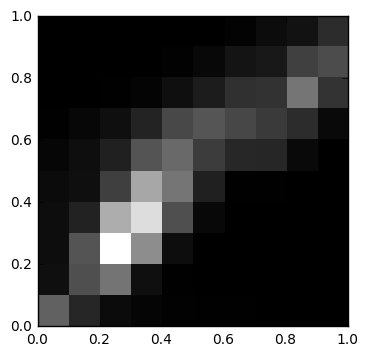

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  1420.0   233.0   195.0   197.0   173.0    88.0    29.0    13.0     0.0   
1   557.0  1164.0  1236.0   502.0   224.0   211.0   115.0    10.0     2.0   
2   173.0  1694.0  3738.0  2539.0   930.0   475.0   232.0    27.0     2.0   
3    75.0   227.0  2072.0  3236.0  2439.0  1229.0   515.0    70.0     5.0   
4    32.0    22.0   199.0  1163.0  1722.0  1538.0  1053.0   221.0    38.0   
5    28.0    11.0    12.0   124.0   490.0   902.0  1243.0   417.0   118.0   
6    22.0     2.0     6.0     2.0    28.0   580.0  1047.0   728.0   301.0   
7     1.0     2.0     2.0     3.0    24.0   566.0   860.0   733.0   362.0   
8     0.0     0.0     0.0     0.0     2.0   133.0   664.0  1715.0   947.0   
9     0.0     0.0     0.0     0.0     0.0     1.0   141.0   757.0  1124.0   

       9  
0    2.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    4.0  
6   56.0  
7  182.0  
8  276.0  
9  647.0  
(10, 10)


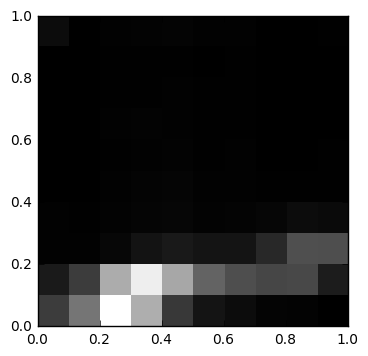

(10, 10)
        0       1       2      3      4     5     6     7     8      9
0  1328.0   582.0    58.0   44.0   14.0   6.0  18.0   8.0  15.0  277.0
1  2561.0  1314.0    45.0   30.0   20.0  14.0   8.0   8.0   4.0   17.0
2  5563.0  3748.0   164.0   74.0   52.0  41.0  44.0  38.0  32.0   54.0
3  3782.0  5182.0   417.0  121.0  108.0  58.0  71.0  22.0  37.0   70.0
4  1240.0  3633.0   554.0  140.0  112.0  77.0  50.0  55.0  36.0   91.0
5   439.0  2164.0   444.0   81.0   47.0  33.0  41.0  31.0  12.0   57.0
6   282.0  1699.0   441.0   99.0   49.0  44.0  32.0  41.0  23.0   62.0
7    95.0  1534.0   889.0  136.0   38.0  15.0   7.0   9.0  12.0    0.0
8    67.0  1580.0  1720.0  275.0   41.0  21.0   9.0  10.0   2.0   12.0
9    20.0   617.0  1702.0  226.0   27.0  36.0   5.0   8.0   7.0   22.0
(10, 10)


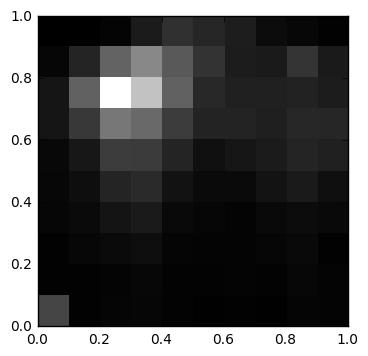

(10, 10)
        0      1      2      3      4      5       6       7       8      9
0  1106.0   38.0   36.0  109.0  125.0  136.0   346.0   343.0   109.0    2.0
1    46.0   40.0  114.0  168.0  229.0  382.0   894.0  1550.0   593.0    5.0
2    82.0   76.0  176.0  321.0  585.0  963.0  1899.0  4060.0  1573.0   75.0
3   105.0  127.0  232.0  422.0  681.0  951.0  1669.0  3083.0  2162.0  436.0
4    64.0   52.0   82.0  156.0  303.0  586.0   981.0  1564.0  1418.0  782.0
5    23.0   60.0   75.0  110.0  162.0  264.0   561.0   658.0   822.0  614.0
6    35.0   68.0   66.0   79.0  167.0  360.0   562.0   520.0   449.0  466.0
7    31.0   64.0  102.0  157.0  318.0  431.0   494.0   516.0   421.0  201.0
8    90.0  127.0  160.0  208.0  418.0  582.0   629.0   548.0   856.0  119.0
9    75.0   66.0   49.0  156.0  250.0  539.0   616.0   452.0   429.0   38.0
(10, 10)


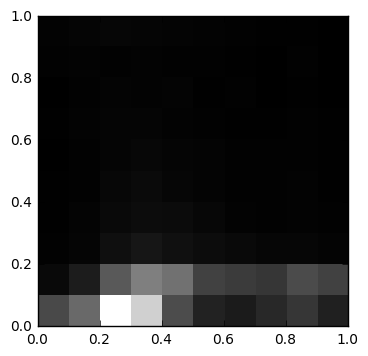

(10, 10)
        0       1      2      3      4      5      6      7     8      9
0  1798.0   231.0   55.0   35.0   26.0   23.0   27.0   21.0  49.0   85.0
1  2597.0   689.0  144.0  112.0   50.0   71.0   78.0   64.0  85.0  131.0
2  6214.0  2206.0  370.0  233.0  182.0  125.0  124.0  121.0  72.0  163.0
3  5059.0  3089.0  550.0  308.0  252.0  171.0  143.0   92.0  76.0  128.0
4  1863.0  2764.0  412.0  280.0  158.0  133.0   97.0  109.0  70.0  102.0
5   828.0  1584.0  296.0  176.0  115.0  107.0   67.0   40.0  50.0   86.0
6   677.0  1456.0  227.0   84.0   66.0   65.0   37.0   57.0  37.0   66.0
7   986.0  1324.0  154.0   66.0   57.0   50.0   33.0   14.0  24.0   27.0
8  1320.0  1840.0  166.0   92.0   81.0   67.0   52.0   33.0  49.0   37.0
9   799.0  1588.0  109.0   50.0   39.0   42.0   29.0   10.0   0.0    4.0
(10, 10)


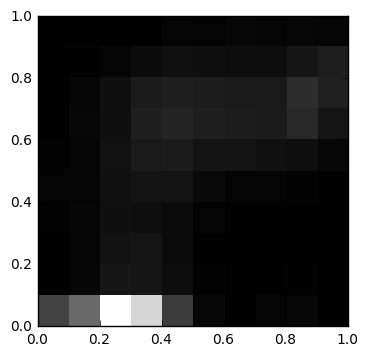

(10, 10)
        0      1      2      3      4      5       6       7      8      9
0  1697.0   63.0   64.0  104.0  113.0   91.0    73.0    75.0   57.0   13.0
1  2701.0  183.0  186.0  175.0  151.0  140.0   210.0   176.0   79.0   20.0
2  6450.0  589.0  482.0  412.0  437.0  451.0   412.0   393.0  160.0   24.0
3  5406.0  551.0  522.0  374.0  513.0  645.0   796.0   718.0  290.0   53.0
4  1554.0  347.0  294.0  293.0  505.0  712.0   920.0   794.0  424.0  145.0
5   195.0   97.0   83.0  130.0  253.0  510.0   804.0   748.0  404.0  125.0
6    60.0   43.0   42.0   46.0  115.0  490.0   761.0   667.0  340.0  208.0
7   133.0   33.0   62.0   62.0  157.0  431.0   713.0   662.0  339.0  143.0
8   188.0   66.0   55.0   37.0   92.0  374.0  1026.0  1125.0  564.0  210.0
9    36.0   10.0   23.0   36.0   47.0  192.0   523.0   850.0  776.0  177.0
(10, 10)


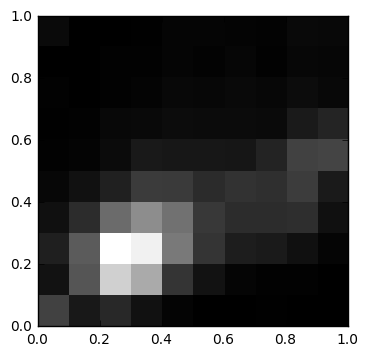

(10, 10)
       0       1       2       3      4      5      6      7      8      9
0  965.0   272.0   462.0   243.0  114.0   39.0   25.0   44.0   18.0  168.0
1  368.0  1244.0  1339.0   649.0  264.0   81.0   38.0   13.0    9.0   16.0
2  616.0  3028.0  3720.0  1562.0  479.0  171.0  138.0   43.0   42.0   11.0
3  266.0  2483.0  3506.0  2055.0  866.0  385.0  149.0   77.0   45.0   36.0
4   74.0   764.0  1765.0  1673.0  850.0  353.0  197.0  134.0   94.0   84.0
5   19.0   274.0   791.0   847.0  635.0  345.0  175.0  117.0   64.0   82.0
6   13.0    94.0   438.0   649.0  734.0  340.0  180.0  148.0   97.0   79.0
7   28.0    42.0   397.0   671.0  697.0  519.0  168.0  117.0   40.0   56.0
8   21.0    48.0   252.0   689.0  905.0  972.0  400.0  195.0  112.0  143.0
9   10.0    18.0    82.0   251.0  386.0  998.0  552.0  132.0  102.0  139.0
(10, 10)


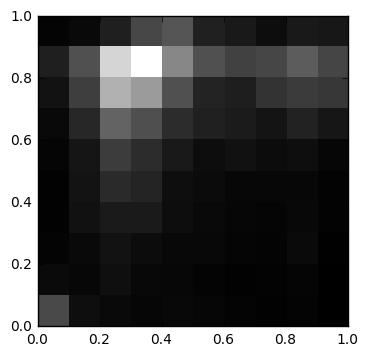

(10, 10)
        0      1      2      3      4      5       6       7       8       9
0  1045.0  148.0   64.0   43.0   44.0   88.0   135.0   260.0   452.0    71.0
1   204.0  118.0  136.0  250.0  279.0  314.0   559.0   888.0  1135.0   138.0
2   139.0  225.0  268.0  378.0  608.0  857.0  1394.0  2496.0  2997.0   448.0
3   102.0  125.0  187.0  371.0  531.0  644.0  1124.0  2184.0  3595.0  1005.0
4   119.0  108.0  127.0  189.0  215.0  370.0   630.0  1130.0  1901.0  1199.0
5    99.0   68.0  121.0  134.0  165.0  193.0   455.0   507.0  1130.0   477.0
6    70.0   37.0   88.0   91.0  114.0  250.0   387.0   440.0   927.0   368.0
7    42.0   50.0   71.0   90.0  107.0  179.0   289.0   722.0   989.0   196.0
8    67.0   81.0  149.0  127.0  110.0  206.0   487.0   842.0  1303.0   365.0
9     6.0   10.0   31.0   61.0   57.0   91.0   316.0   789.0   974.0   335.0
(10, 10)


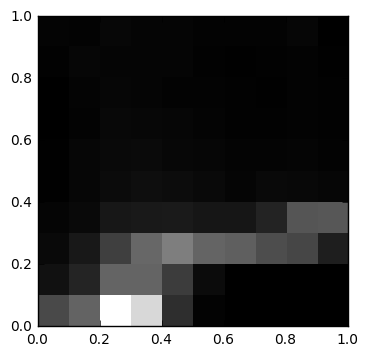

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1486.0   343.0   183.0   106.0   36.0   30.0   18.0   14.0   46.0   88.0
1  1983.0   731.0   483.0   188.0  135.0  128.0   78.0   99.0  135.0   61.0
2  5103.0  2004.0  1262.0   465.0  238.0  183.0  177.0  126.0  111.0  141.0
3  4319.0  2007.0  2054.0   516.0  283.0  216.0  145.0  109.0  105.0  114.0
4   922.0  1211.0  2520.0   521.0  254.0  149.0  122.0   78.0  103.0  108.0
5    61.0   223.0  2011.0   458.0  191.0  134.0   93.0   66.0   45.0   67.0
6     4.0     9.0  1904.0   457.0  111.0   97.0   48.0   43.0   35.0   64.0
7     0.0     0.0  1549.0   704.0  185.0   96.0   43.0   29.0   54.0   75.0
8     0.0     1.0  1413.0  1696.0  168.0  112.0   76.0   64.0   78.0  129.0
9     0.0     2.0   600.0  1741.0  121.0   73.0   55.0   43.0   21.0   14.0
(10, 10)


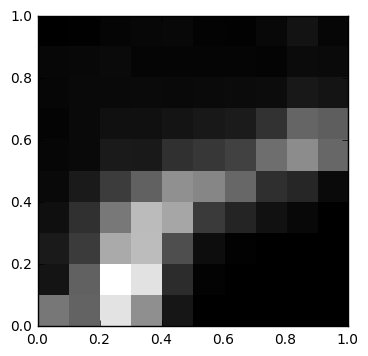

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1295.0   223.0   290.0   166.0   104.0    72.0    45.0   67.0   82.0    6.0
1  1084.0  1060.0   646.0   535.0   283.0   101.0   104.0   98.0   94.0   16.0
2  2473.0  2781.0  1856.0  1305.0   658.0   288.0   174.0  107.0  113.0   55.0
3  1564.0  2464.0  2048.0  2032.0  1056.0   280.0   174.0  110.0   62.0   78.0
4   245.0   494.0   855.0  1811.0  1574.0   533.0   226.0   98.0   60.0   92.0
5     2.0    33.0   144.0   640.0  1459.0   603.0   261.0  112.0   62.0   33.0
6     0.0     0.0    27.0   403.0  1119.0   716.0   301.0  121.0   58.0   27.0
7     0.0     0.0     5.0   194.0   513.0  1197.0   546.0  136.0   53.0   91.0
8     0.0     0.0     0.0    88.0   422.0  1523.0  1098.0  271.0  123.0  212.0
9     0.0     0.0     0.0     2.0   118.0  1120.0  1022.0  221.0  115.0   72.0
(10, 10)


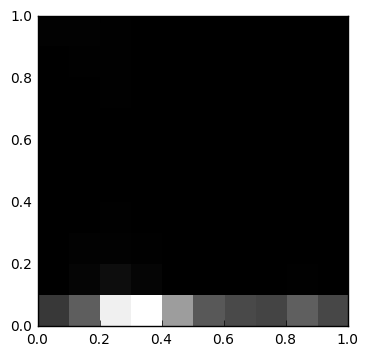

(10, 10)
        0      1     2     3     4     5     6     7     8     9
0  2147.0   37.0  10.0   2.0   9.0  12.0  10.0  26.0  22.0  75.0
1  3483.0  198.0  77.0  36.0  18.0  23.0  23.0  32.0  38.0  93.0
2  8911.0  493.0  99.0  62.0  32.0  31.0  37.0  40.0  40.0  65.0
3  9480.0  204.0  38.0  26.0  30.0  23.0  14.0  18.0  14.0  21.0
4  5836.0   37.0  18.0  10.0  10.0  18.0   8.0  18.0  10.0  23.0
5  3267.0   17.0  29.0  15.0  10.0   7.0   0.0   4.0   0.0   0.0
6  2731.0   11.0   0.0   4.0  14.0   4.0   2.0   0.0   0.0   6.0
7  2550.0   29.0  19.0  20.0  14.0  21.0  30.0  13.0   5.0  34.0
8  3523.0   42.0  23.0  21.0  14.0  33.0  22.0  14.0  13.0  32.0
9  2651.0    3.0  10.0   0.0   2.0   2.0   0.0   0.0   0.0   2.0
(10, 10)


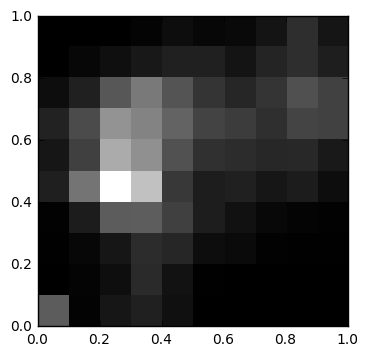

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1089.0    7.0   14.0    32.0   376.0   263.0   404.0   156.0    8.0    1.0
1    43.0   56.0   86.0   338.0  1373.0   759.0   896.0   379.0   91.0    0.0
2   268.0  175.0  263.0  1093.0  3020.0  2028.0  1747.0  1028.0  182.0    6.0
3   391.0  505.0  536.0  1105.0  2288.0  1710.0  1549.0  1441.0  294.0   49.0
4   196.0  217.0  455.0   755.0   681.0   958.0  1176.0   993.0  399.0  158.0
5    11.0   14.0  162.0   352.0   343.0   572.0   798.0   626.0  386.0   85.0
6     2.0    4.0  129.0   203.0   385.0   525.0   722.0   452.0  240.0  110.0
7     0.0    0.0   32.0   105.0   262.0   462.0   565.0   630.0  436.0  243.0
8     0.0    0.0   14.0    55.0   332.0   482.0   810.0   952.0  548.0  544.0
9     0.0    0.0   14.0    29.0   157.0   303.0   767.0   789.0  355.0  256.0
(10, 10)


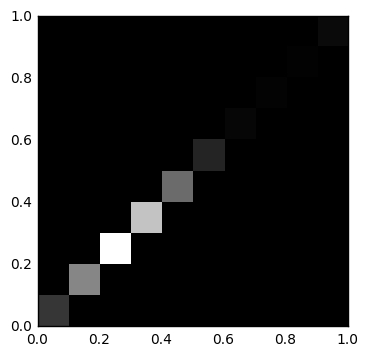

(10, 10)
        0       1        2        3       4       5      6      7      8  \
0  3201.0     0.0      0.0      0.0     0.0     0.0    0.0    0.0    0.0   
1     0.0  7872.0      0.0      0.0     0.0     0.0    0.0    0.0    0.0   
2     0.0     0.0  14988.0      0.0     0.0     0.0    0.0    0.0    0.0   
3     0.0     0.0      0.0  11449.0     0.0     0.0    0.0    0.0    0.0   
4     0.0     0.0      0.0      0.0  6303.0     0.0    0.0    0.0    0.0   
5     0.0     0.0      0.0      0.0     0.0  2178.0    0.0    0.0    0.0   
6     0.0     0.0      0.0      0.0     0.0     0.0  371.0    0.0    0.0   
7     0.0     0.0      0.0      0.0     0.0     0.0    0.0  198.0    0.0   
8     0.0     0.0      0.0      0.0     0.0     0.0    0.0    0.0  133.0   
9     0.0     0.0      0.0      0.0     0.0     0.0    0.0    0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  607.0  
(10, 10)


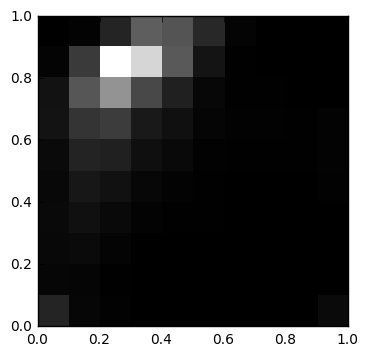

(10, 10)
       0      1      2      3      4      5       6       7       8       9
0  977.0  168.0  215.0  240.0  222.0  268.0   504.0   493.0   112.0     2.0
1  175.0  136.0  273.0  439.0  626.0  938.0  1390.0  2269.0  1544.0    82.0
2   72.0   48.0  110.0  262.0  453.0  854.0  1591.0  3883.0  6737.0   978.0
3   18.0   11.0   19.0   90.0  186.0  414.0   679.0  1905.0  5648.0  2479.0
4    5.0    9.0   20.0   37.0   81.0  251.0   423.0   881.0  2366.0  2230.0
5   11.0    8.0   14.0   34.0   52.0   76.0   133.0   201.0   546.0  1103.0
6    2.0    0.0    4.0   10.0   23.0   43.0    75.0    50.0    41.0   123.0
7    0.0    0.0    8.0   14.0   16.0   31.0    69.0    42.0    11.0     7.0
8    3.0    0.0    0.0    8.0   14.0   36.0    46.0    17.0     9.0     0.0
9  286.0   14.0    8.0   18.0   68.0   99.0    85.0    26.0     3.0     0.0
(10, 10)


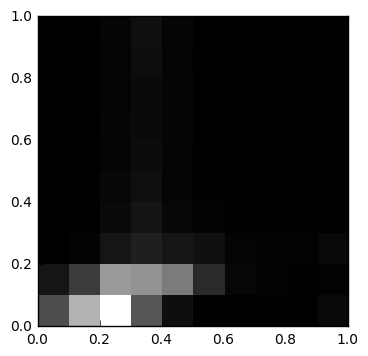

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  2492.0   692.0   10.0    0.0    2.0    3.0    2.0    0.0    0.0    0.0
1  5712.0  1881.0   96.0   60.0   36.0    8.0    8.0   21.0   28.0   22.0
2  8079.0  4853.0  684.0  345.0  230.0  155.0  172.0  140.0  156.0  174.0
3  2697.0  4675.0  989.0  643.0  476.0  392.0  346.0  334.0  413.0  484.0
4   462.0  3898.0  715.0  247.0  173.0  135.0  178.0  181.0  130.0  184.0
5    37.0  1333.0  529.0  111.0   56.0   28.0   18.0   17.0   19.0   30.0
6     0.0   196.0  157.0   13.0    3.0    0.0    2.0    0.0    0.0    0.0
7     2.0   102.0   94.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8     0.0    49.0   81.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0
9   284.0    68.0  255.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


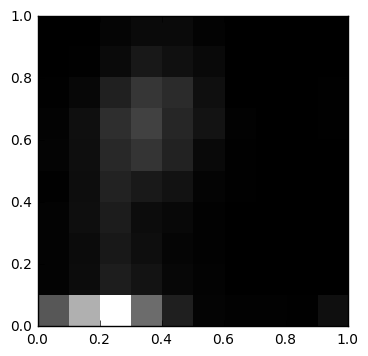

(10, 10)
        0      1      2      3       4       5       6       7      8      9
0  2574.0  110.0   93.0  100.0    56.0   132.0    95.0    39.0    2.0    0.0
1  5210.0  376.0  335.0  416.0   396.0   424.0   456.0   218.0   35.0    6.0
2  7538.0  883.0  715.0  829.0  1010.0  1204.0  1372.0   946.0  315.0  176.0
3  3187.0  581.0  419.0  375.0   750.0  1559.0  1958.0  1598.0  716.0  306.0
4   921.0  216.0  170.0  246.0   541.0  1003.0  1138.0  1269.0  494.0  305.0
5   119.0   90.0   76.0   75.0   144.0   294.0   562.0   450.0  269.0   99.0
6    83.0   19.0   22.0   25.0    45.0    52.0    68.0    28.0   27.0    2.0
7    84.0    5.0    1.0   10.0    13.0    29.0    20.0    18.0   16.0    2.0
8    57.0   11.0    0.0    4.0    13.0    15.0    12.0    15.0    6.0    0.0
9   442.0   12.0    0.0    1.0    18.0    25.0    44.0    39.0   26.0    0.0
(10, 10)


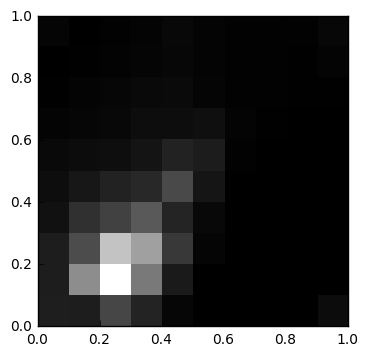

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0   683.0   670.0   663.0   394.0   298.0  206.0  105.0   36.0   12.0  134.0
1   676.0  3214.0  1749.0  1098.0   543.0  295.0  148.0   94.0   38.0   17.0
2  1597.0  5824.0  4460.0  1508.0   776.0  327.0  203.0  158.0   81.0   54.0
3   807.0  2788.0  3662.0  2027.0   952.0  466.0  300.0  219.0  128.0  100.0
4   146.0   613.0  1285.0   862.0  1696.0  789.0  313.0  231.0  177.0  191.0
5     8.0    17.0   129.0   203.0   493.0  652.0  347.0  116.0  103.0  110.0
6     0.0     0.0     3.0     8.0    10.0   53.0  107.0   62.0   62.0   66.0
7     0.0     0.0     0.0     0.0     5.0   16.0   33.0   51.0   46.0   47.0
8     0.0     0.0     0.0     0.0     3.0    1.0   15.0   25.0   39.0   50.0
9   282.0     0.0     0.0     2.0     3.0    0.0    7.0   36.0  100.0  177.0
(10, 10)


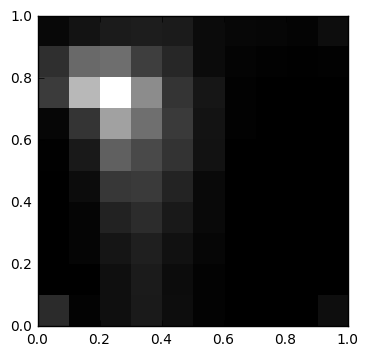

(10, 10)
       0      1      2      3       4       5       6       7       8      9
0  817.0   14.0    3.0    8.0    16.0    34.0   128.0  1122.0   903.0  156.0
1   64.0   17.0  101.0  111.0   238.0   486.0  1011.0  3472.0  2013.0  359.0
2  285.0  300.0  412.0  658.0  1047.0  1823.0  3044.0  4818.0  2089.0  512.0
3  504.0  519.0  601.0  856.0  1094.0  1389.0  2090.0  2653.0  1181.0  562.0
4  246.0  240.0  320.0  481.0   673.0   974.0  1106.0  1005.0   742.0  516.0
5   60.0   57.0  114.0  178.0   177.0   357.0   374.0   423.0   218.0  220.0
6    5.0    0.0    0.0   14.0    11.0     9.0    53.0    53.0    78.0  148.0
7    0.0    0.0    0.0    1.0     2.0     3.0     6.0    10.0    51.0  125.0
8    0.0    0.0    0.0    0.0     0.0     3.0     0.0     5.0    33.0   92.0
9  282.0    0.0    0.0    0.0     0.0     0.0     3.0     6.0    54.0  262.0
(10, 10)


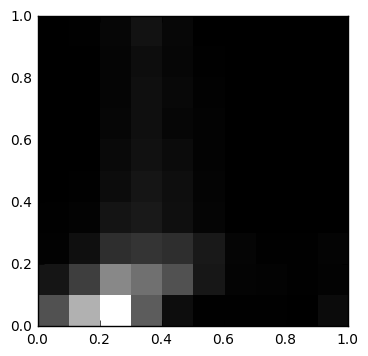

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  2443.0   640.0    62.0   38.0   10.0    8.0    0.0    0.0    0.0    0.0
1  5295.0  1856.0   465.0  106.0   54.0   21.0    4.0   10.0   24.0   37.0
2  7623.0  4050.0  1375.0  599.0  358.0  276.0  198.0  151.0  157.0  201.0
3  2755.0  3364.0  1549.0  763.0  643.0  507.0  453.0  469.0  400.0  546.0
4   416.0  2419.0  1375.0  453.0  429.0  338.0  207.0  266.0  182.0  218.0
5    42.0   714.0   759.0  164.0  136.0  114.0   99.0   73.0   57.0   20.0
6    49.0   123.0   160.0   28.0    2.0    4.0    1.0    2.0    2.0    0.0
7    33.0   108.0    57.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8    20.0    56.0    54.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0
9   356.0   102.0   145.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


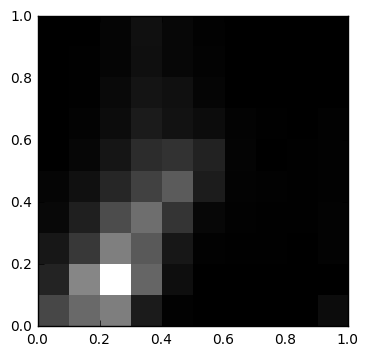

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1568.0   785.0   510.0   188.0   114.0    20.0    8.0    4.0    0.0    4.0
1  2318.0  2964.0  1261.0   683.0   361.0   144.0   67.0   29.0   41.0    4.0
2  2777.0  5638.0  2816.0  1690.0   850.0   482.0  273.0  218.0  128.0  116.0
3   609.0  2242.0  1996.0  2439.0  1436.0   970.0  611.0  454.0  334.0  358.0
4    52.0   312.0   525.0  1168.0  2011.0  1120.0  418.0  353.0  168.0  176.0
5    14.0    10.0    64.0   169.0   638.0   750.0  267.0  130.0   78.0   58.0
6     4.0    12.0    34.0    56.0    67.0   107.0   74.0    6.0    9.0    2.0
7     0.0    14.0    36.0    41.0    56.0    22.0   28.0    1.0    0.0    0.0
8     0.0     8.0    12.0    31.0    30.0    30.0   18.0    4.0    0.0    0.0
9   282.0     5.0    71.0    70.0    45.0    62.0   66.0    6.0    0.0    0.0
(10, 10)


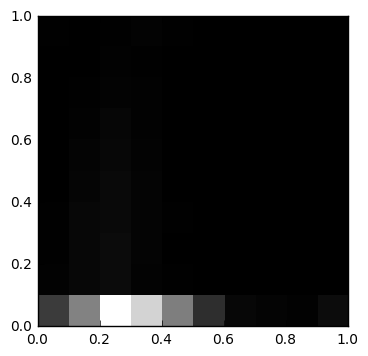

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0   2790.0  101.0   86.0   63.0   44.0   32.0   12.0    5.0    4.0   64.0
1   6128.0  375.0  331.0  329.0  262.0  193.0  133.0   78.0   36.0    7.0
2  12027.0  529.0  535.0  443.0  442.0  356.0  286.0  187.0  108.0   75.0
3   9944.0  171.0  194.0  217.0  233.0  172.0  132.0  115.0   86.0  185.0
4   5964.0   61.0   35.0   53.0   34.0   35.0   22.0   20.0   26.0   53.0
5   2166.0    4.0    6.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0
6    363.0    6.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
7    198.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8    133.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    603.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


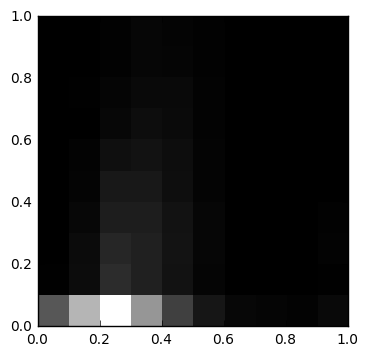

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  3070.0    58.0    30.0    18.0    2.0    2.0    0.0    0.0    6.0   15.0
1  6394.0   452.0   390.0   258.0  167.0  115.0   35.0   36.0    7.0   18.0
2  9012.0  1554.0  1355.0  1054.0  847.0  544.0  276.0  186.0   76.0   84.0
3  5291.0  1181.0  1161.0  1044.0  878.0  665.0  471.0  321.0  224.0  213.0
4  2281.0   653.0   696.0   645.0  518.0  469.0  371.0  333.0  182.0  155.0
5   789.0   202.0   227.0   230.0  157.0  163.0  124.0  129.0   77.0   80.0
6   256.0    23.0    19.0    25.0   20.0   13.0    4.0    7.0    2.0    2.0
7   197.0     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0
8   133.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
9   337.0    52.0   130.0    72.0    0.0    4.0    0.0    0.0    4.0    8.0
(10, 10)


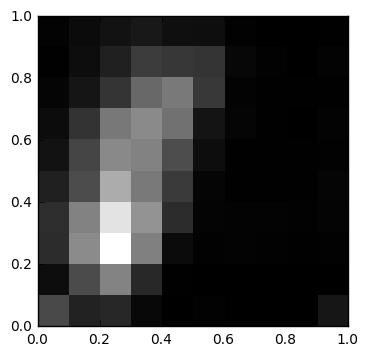

(10, 10)
       0       1       2       3       4       5       6       7      8      9
0  928.0   176.0   566.0   592.0   408.0   237.0   156.0    74.0   20.0   44.0
1  435.0   953.0  1753.0  1646.0   970.0   881.0   651.0   274.0  166.0  143.0
2  500.0  1659.0  3226.0  2862.0  2168.0  1730.0  1514.0   679.0  414.0  236.0
3  113.0   528.0  1622.0  1860.0  1549.0  1640.0  1745.0  1315.0  765.0  312.0
4    8.0    14.0   139.0   577.0   734.0   973.0  1437.0  1528.0  703.0  190.0
5   29.0     8.0    33.0    57.0    68.0   172.0   262.0   711.0  658.0  180.0
6    1.0     4.0    42.0    41.0    22.0    19.0    64.0    50.0   91.0   37.0
7   10.0     3.0    27.0    40.0    24.0    25.0    19.0    19.0   27.0    4.0
8    2.0     6.0    18.0    30.0    22.0    16.0    12.0    17.0   10.0    0.0
9  282.0     4.0    34.0    61.0    67.0    30.0    39.0    24.0   45.0   21.0
(10, 10)


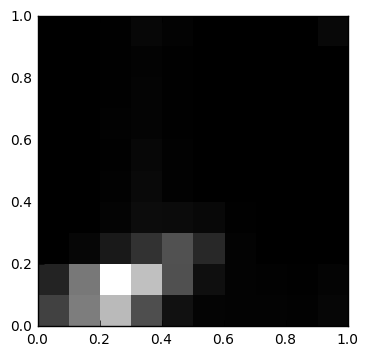

(10, 10)
        0       1       2      3      4      5      6      7     8      9
0  2062.0  1109.0    17.0    9.0    0.0    0.0    0.0    0.0   4.0    0.0
1  3887.0  3739.0   191.0    8.0   14.0    7.0   10.0    6.0   8.0    2.0
2  5788.0  7924.0   788.0  145.0   92.0   46.0   80.0   34.0  32.0   59.0
3  2443.0  5946.0  1561.0  401.0  287.0  222.0  138.0  132.0  93.0  226.0
4   554.0  2479.0  2532.0  362.0   89.0   66.0   43.0   44.0  31.0  103.0
5   147.0   475.0  1241.0  259.0   20.0    2.0   12.0   12.0   8.0    2.0
6   115.0   114.0   103.0   35.0    4.0    0.0    0.0    0.0   0.0    0.0
7   116.0    78.0     1.0    3.0    0.0    0.0    0.0    0.0   0.0    0.0
8    79.0    51.0     0.0    0.0    2.0    1.0    0.0    0.0   0.0    0.0
9   186.0   138.0     0.0    4.0    0.0    1.0    2.0    2.0   4.0  270.0
(10, 10)


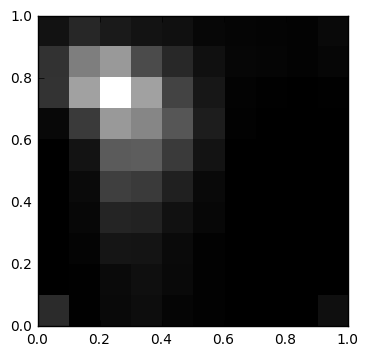

(10, 10)
       0      1      2      3       4       5       6       7       8      9
0  795.0    9.0    0.0    5.0    11.0    16.0   155.0   946.0   931.0  333.0
1   28.0   35.0   84.0  128.0   190.0   350.0  1069.0  2951.0  2309.0  728.0
2  165.0  189.0  390.0  658.0  1152.0  1669.0  2807.0  4676.0  2801.0  481.0
3  250.0  278.0  375.0  627.0  1069.0  1706.0  2465.0  2944.0  1373.0  362.0
4   98.0  166.0  200.0  316.0   621.0  1072.0  1574.0  1226.0   731.0  299.0
5   39.0   39.0   37.0  145.0   173.0   362.0   534.0   426.0   293.0  130.0
6    0.0    2.0    5.0    7.0    16.0    13.0    44.0    57.0   125.0  102.0
7    0.0    0.0    1.0    0.0     2.0     2.0     3.0    20.0    92.0   78.0
8    0.0    0.0    0.0    0.0     0.0     3.0     0.0    16.0    56.0   58.0
9  282.0    0.0    0.0    0.0     4.0     1.0     0.0    32.0   121.0  167.0
(10, 10)


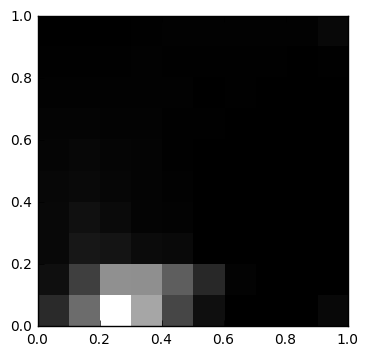

(10, 10)
        0       1      2      3      4      5      6     7     8      9
0  1411.0   497.0  282.0  289.0  253.0  188.0  139.0  97.0  35.0   10.0
1  3580.0  2093.0  787.0  532.0  322.0  235.0  152.0  81.0  61.0   29.0
2  8482.0  4800.0  672.0  352.0  210.0  179.0  123.0  85.0  60.0   25.0
3  5530.0  4746.0  395.0  141.0  143.0  144.0  125.0  83.0  87.0   55.0
4  2331.0  3123.0  323.0  109.0   71.0   55.0   63.0  90.0  60.0   78.0
5   508.0  1376.0   19.0   13.0   23.0   30.0   47.0  33.0  56.0   73.0
6    13.0   131.0    2.0    0.0    0.0   14.0   24.0  44.0  46.0   97.0
7     1.0     0.0    3.0    0.0    4.0    9.0   12.0  28.0  51.0   90.0
8     0.0     3.0    0.0    0.0    0.0    0.0    2.0  13.0  16.0   99.0
9   285.0     2.0    0.0    0.0    0.0    0.0    0.0   7.0  40.0  273.0
(10, 10)


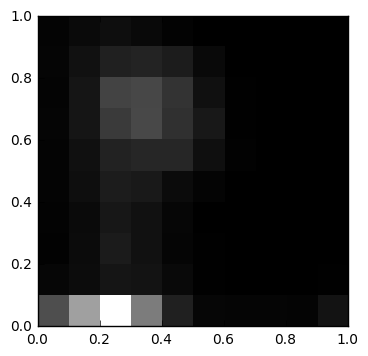

(10, 10)
        0      1      2      3      4       5       6       7      8      9
0  2088.0  181.0   73.0   88.0  127.0   119.0   137.0   128.0  150.0  110.0
1  4251.0  345.0  303.0  275.0  378.0   441.0   568.0   569.0  460.0  282.0
2  6798.0  584.0  724.0  631.0  752.0   926.0  1566.0  1782.0  851.0  374.0
3  3304.0  508.0  477.0  465.0  679.0  1018.0  1919.0  1887.0  944.0  248.0
4   879.0  244.0  155.0  164.0  297.0  1032.0  1326.0  1374.0  750.0   82.0
5   178.0   45.0   30.0   26.0  109.0   423.0   651.0   431.0  263.0   22.0
6   158.0   23.0    8.0    6.0   18.0    60.0    53.0    32.0   13.0    0.0
7   135.0   13.0   11.0    8.0    8.0     8.0    10.0     3.0    2.0    0.0
8   109.0    6.0    7.0    0.0    2.0     7.0     0.0     2.0    0.0    0.0
9   520.0   33.0   25.0    6.0   13.0     2.0     8.0     0.0    0.0    0.0
(10, 10)


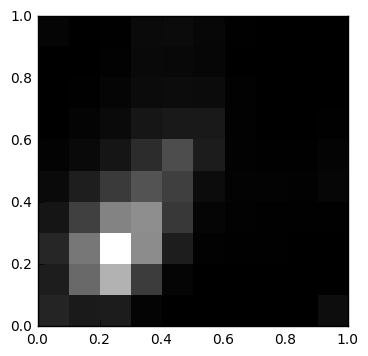

(10, 10)
       0       1       2       3       4       5      6      7      8      9
0  805.0   645.0   840.0   457.0   223.0    68.0   15.0   17.0    5.0  126.0
1  573.0  2311.0  2580.0  1392.0   651.0   198.0   97.0   41.0   17.0   12.0
2  610.0  3855.0  5530.0  2833.0  1270.0   465.0  222.0  117.0   60.0   26.0
3   88.0  1307.0  3042.0  3089.0  1802.0   958.0  488.0  256.0  195.0  224.0
4   10.0   112.0   632.0  1247.0  1368.0  1667.0  561.0  278.0  190.0  238.0
5    8.0    10.0    45.0   125.0   267.0   623.0  551.0  254.0  136.0  159.0
6    2.0    16.0    29.0    47.0    73.0    57.0   48.0   51.0   19.0   29.0
7    0.0     6.0    29.0    40.0    81.0    32.0    9.0    0.0    1.0    0.0
8    0.0     2.0     9.0    29.0    48.0    38.0    7.0    0.0    0.0    0.0
9  284.0     3.0    16.0    30.0   147.0    97.0   24.0    6.0    0.0    0.0
(10, 10)


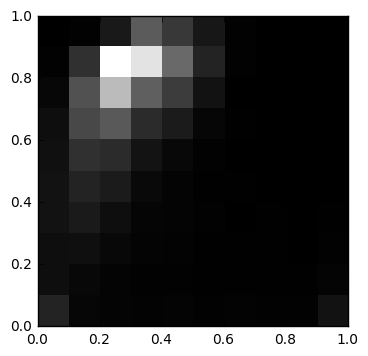

(10, 10)
       0      1      2      3      4       5       6       7       8       9
0  815.0  322.0  327.0  410.0  410.0   371.0   322.0   170.0    51.0     3.0
1  137.0  195.0  351.0  602.0  809.0  1104.0  1641.0  1858.0  1108.0    67.0
2  101.0   93.0  183.0  338.0  618.0   984.0  2025.0  4259.0  5803.0   584.0
3   79.0   63.0  113.0  132.0  217.0   443.0   991.0  2174.0  5171.0  2066.0
4   93.0   59.0   81.0  107.0   98.0   194.0   614.0  1370.0  2404.0  1283.0
5   66.0   40.0   45.0   48.0   30.0    60.0   147.0   418.0   799.0   525.0
6   79.0   36.0   32.0   22.0   23.0    18.0    27.0     5.0    64.0    65.0
7   53.0   37.0   33.0   35.0   10.0    15.0     7.0     4.0     3.0     1.0
8   59.0   32.0   14.0   12.0    8.0     3.0     2.0     0.0     0.0     3.0
9  411.0   93.0   63.0   28.0    7.0     0.0     0.0     0.0     0.0     5.0
(10, 10)


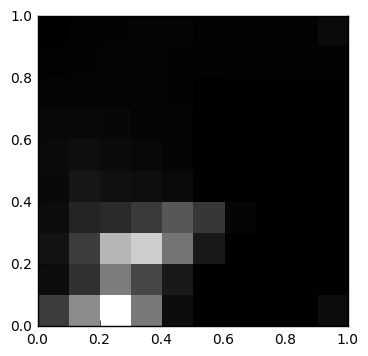

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1391.0   278.0   419.0   280.0  228.0  244.0  185.0  108.0   56.0   12.0
1  3212.0  1104.0  1380.0   867.0  516.0  330.0  201.0  113.0   88.0   61.0
2  5871.0  2864.0  4174.0   972.0  387.0  257.0  169.0  107.0  108.0   79.0
3  2775.0  1651.0  4737.0  1340.0  324.0  196.0   99.0  126.0  107.0   94.0
4   320.0   591.0  2680.0  1998.0  230.0  130.0   99.0   75.0   88.0   92.0
5    20.0    35.0   569.0  1272.0   33.0   35.0   45.0   39.0   71.0   59.0
6     2.0     2.0    20.0   122.0    4.0   17.0   21.0   38.0   55.0   90.0
7     0.0     3.0     0.0     1.0    0.0    9.0   28.0   30.0   48.0   79.0
8     0.0     3.0     0.0     0.0    0.0    0.0    4.0   18.0   47.0   61.0
9   287.0     0.0     0.0     0.0    0.0    0.0    4.0   17.0   65.0  234.0
(10, 10)


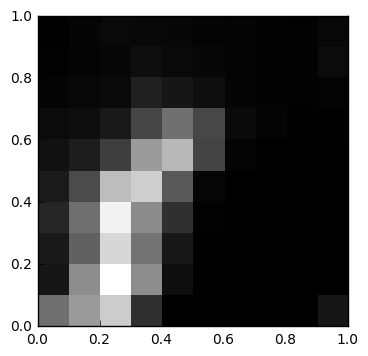

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1373.0   270.0   308.0   474.0   319.0   215.0   147.0   60.0   30.0    5.0
1  1895.0  1739.0  1198.0  1372.0   924.0   357.0   162.0  101.0   52.0   72.0
2  2510.0  3140.0  2641.0  2979.0  2325.0   762.0   309.0  133.0   78.0  111.0
3   589.0  1733.0  1422.0  1713.0  2536.0  1909.0   867.0  403.0  176.0  101.0
4     6.0   173.0   286.0   594.0  1116.0  2269.0  1379.0  270.0  119.0   91.0
5     8.0     0.0    13.0    32.0    76.0   845.0   878.0  176.0   93.0   57.0
6     0.0     0.0     2.0     2.0    10.0    52.0   124.0   66.0   54.0   61.0
7     0.0     0.0     0.0     3.0     0.0    12.0    55.0   48.0   35.0   45.0
8     0.0     0.0     0.0     3.0     0.0     4.0    17.0   34.0   39.0   36.0
9   282.0     0.0     1.0     4.0     0.0     8.0    13.0   50.0  146.0  103.0
(10, 10)


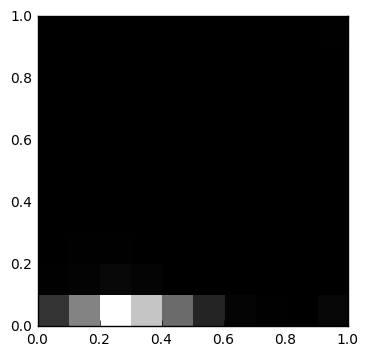

(10, 10)
         0      1     2     3     4     5     6     7     8     9
0   2897.0   61.0  50.0  26.0  20.0  24.0  23.0  23.0  22.0  55.0
1   7421.0  202.0  77.0  55.0  30.0  13.0  10.0  20.0   8.0  36.0
2  14320.0  464.0  80.0  18.0  10.0  18.0  17.0  18.0  13.0  30.0
3  11059.0  250.0  24.0  17.0   6.0  14.0  18.0  23.0   9.0  29.0
4   6037.0   52.0  37.0  31.0  23.0  39.0  21.0  18.0  10.0  35.0
5   2084.0    8.0   6.0   6.0   9.0  10.0  12.0  12.0  11.0  20.0
6    242.0    8.0  12.0  10.0  10.0  14.0  14.0  14.0  11.0  36.0
7     97.0    7.0  15.0  10.0  10.0  12.0   6.0  11.0   9.0  21.0
8     40.0    3.0  10.0   6.0   5.0  11.0   4.0  12.0  16.0  26.0
9    382.0   16.0  12.0  17.0  30.0  19.0  21.0  14.0  33.0  63.0
(10, 10)


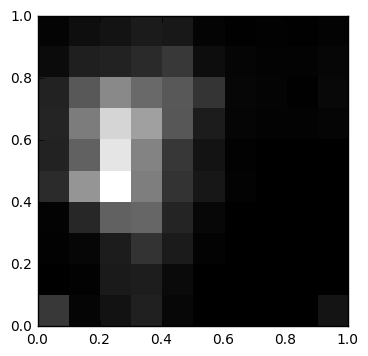

(10, 10)
       0      1      2       3       4       5       6       7      8      9
0  795.0    7.0   42.0    51.0   607.0   481.0   508.0   491.0  161.0   58.0
1   72.0   32.0   88.0   553.0  2113.0  1369.0  1758.0  1246.0  441.0  200.0
2  255.0  379.0  408.0  1377.0  3610.0  3237.0  3013.0  1939.0  493.0  277.0
3  474.0  412.0  725.0  1450.0  1782.0  1870.0  2262.0  1482.0  602.0  390.0
4  112.0  142.0  389.0   525.0   728.0   780.0  1230.0  1245.0  802.0  350.0
5    8.0    4.0   52.0   104.0   331.0   279.0   402.0   750.0  187.0   61.0
6    0.0    0.0    0.0     4.0    43.0    40.0    83.0    98.0   77.0   26.0
7    0.0    0.0    0.0     0.0     3.0     0.0    55.0    64.0   46.0   30.0
8    0.0    0.0    0.0     3.0     0.0     2.0    50.0    18.0   44.0   16.0
9  284.0    2.0    1.0     0.0     0.0     4.0    73.0   113.0   86.0   44.0
(10, 10)


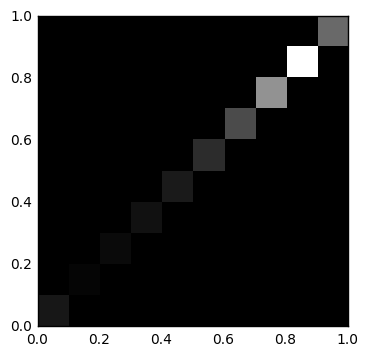

(10, 10)
        0      1      2       3       4       5       6       7        8  \
0  1549.0    0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0   
1     0.0  394.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0   
2     0.0    0.0  671.0     0.0     0.0     0.0     0.0     0.0      0.0   
3     0.0    0.0    0.0  1152.0     0.0     0.0     0.0     0.0      0.0   
4     0.0    0.0    0.0     0.0  1741.0     0.0     0.0     0.0      0.0   
5     0.0    0.0    0.0     0.0     0.0  3010.0     0.0     0.0      0.0   
6     0.0    0.0    0.0     0.0     0.0     0.0  4995.0     0.0      0.0   
7     0.0    0.0    0.0     0.0     0.0     0.0     0.0  9767.0      0.0   
8     0.0    0.0    0.0     0.0     0.0     0.0     0.0     0.0  17017.0   
9     0.0    0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  7004.0  
(10, 10)


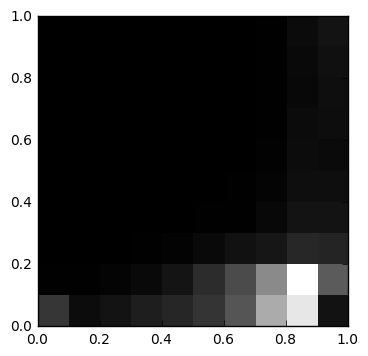

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  1504.0    37.0     8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
1   344.0    39.0    11.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
2   533.0   128.0    10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
3   841.0   267.0    31.0   13.0    0.0    0.0    0.0    0.0    0.0    0.0
4  1060.0   564.0   108.0    8.0    1.0    0.0    0.0    0.0    0.0    0.0
5  1478.0  1218.0   261.0   38.0   15.0    0.0    0.0    0.0    0.0    0.0
6  2369.0  2071.0   470.0   52.0   28.0    5.0    0.0    0.0    0.0    0.0
7  4744.0  3824.0   616.0  231.0  128.0   69.0   41.0   36.0   48.0   30.0
8  6390.0  7067.0  1099.0  544.0  406.0  358.0  321.0  247.0  255.0  330.0
9   502.0  2532.0   996.0  533.0  400.0  290.0  364.0  410.0  443.0  534.0
(10, 10)


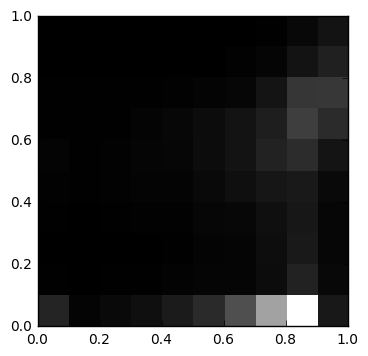

(10, 10)
        0       1      2      3      4       5       6       7       8      9
0  1136.0    32.0   21.0   44.0   71.0   141.0    58.0    44.0     2.0    0.0
1   127.0    13.0   17.0   26.0   42.0    56.0    54.0    52.0     7.0    0.0
2   290.0    31.0   22.0   45.0   81.0    88.0    61.0    44.0     6.0    3.0
3   481.0    61.0   26.0   73.0  147.0   161.0   143.0    52.0     6.0    2.0
4   849.0   106.0   57.0   72.0  144.0   213.0   215.0    79.0     4.0    2.0
5  1303.0   158.0  131.0  194.0  295.0   376.0   385.0   139.0    28.0    1.0
6  2447.0   165.0  183.0  243.0  461.0   607.0   612.0   209.0    64.0    4.0
7  4981.0   393.0  410.0  466.0  689.0  1052.0   948.0   617.0   178.0   33.0
8  7842.0  1072.0  780.0  705.0  772.0  1408.0  1905.0  1677.0   606.0  250.0
9   759.0   272.0  184.0  213.0  284.0   635.0  1344.0  1707.0  1005.0  601.0
(10, 10)


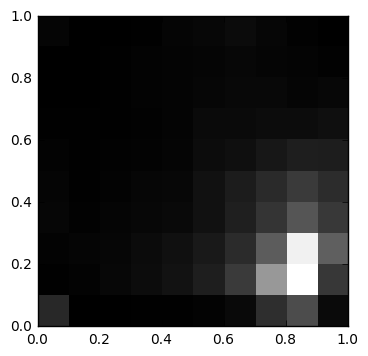

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0   906.0    29.0    87.0   143.0   120.0   82.0   27.0   17.0    8.0  130.0
1     0.0    68.0   127.0    57.0    43.0   41.0   22.0   12.0   10.0   14.0
2    10.0   175.0   138.0   121.0    74.0   44.0   26.0   39.0   30.0   14.0
3    26.0   277.0   245.0   171.0   147.0   66.0   47.0   69.0   71.0   33.0
4    31.0   415.0   370.0   206.0   174.0  124.0  105.0  105.0   96.0  115.0
5    76.0   668.0   560.0   392.0   374.0  277.0  225.0  147.0  121.0  170.0
6   216.0  1288.0   966.0   696.0   636.0  347.0  234.0  178.0  172.0  262.0
7  1025.0  3354.0  2039.0  1169.0   940.0  514.0  274.0  180.0  125.0  147.0
8  1681.0  5630.0  5315.0  1889.0  1284.0  665.0  276.0  126.0  104.0   47.0
9   228.0  1222.0  2104.0  1258.0   987.0  645.0  342.0  155.0   49.0   14.0
(10, 10)


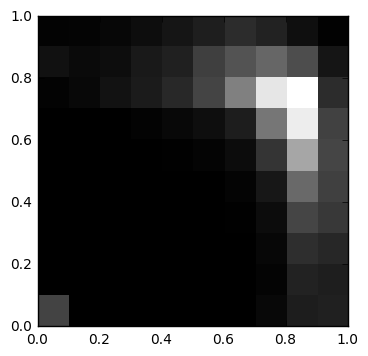

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1111.0   14.0    0.0     4.0     0.0     0.0     5.0    64.0   293.0   58.0
1     0.0    0.0    2.0     0.0     0.0     7.0     2.0   135.0   171.0   77.0
2     0.0    0.0    1.0     0.0     0.0     3.0    12.0   307.0   228.0  120.0
3     0.0    0.0    0.0     2.0     0.0     4.0    51.0   455.0   414.0  226.0
4     0.0    0.0    0.0     0.0     1.0    30.0   144.0   671.0   542.0  353.0
5     0.0    0.0    0.0     6.0    16.0    73.0   241.0  1125.0  1042.0  507.0
6     0.0    0.0    0.0    20.0    71.0   211.0   477.0  2100.0  1369.0  747.0
7   143.0   75.0  125.0   204.0   388.0   879.0  1933.0  3773.0  1682.0  565.0
8   484.0  567.0  769.0  1139.0  1728.0  2732.0  3884.0  4189.0  1265.0  260.0
9   525.0  491.0  654.0   932.0  1054.0  1139.0  1066.0   748.0   356.0   39.0
(10, 10)


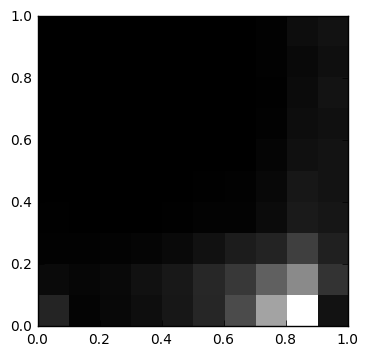

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  1087.0   320.0    86.0   38.0    6.0   12.0    0.0    0.0    0.0    0.0
1   129.0   195.0    62.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0
2   266.0   292.0   103.0    4.0    6.0    0.0    0.0    0.0    0.0    0.0
3   425.0   516.0   166.0   29.0   13.0    3.0    0.0    0.0    0.0    0.0
4   706.0   714.0   275.0   38.0    6.0    2.0    0.0    0.0    0.0    0.0
5  1159.0  1182.0   515.0   99.0   31.0   19.0    5.0    0.0    0.0    0.0
6  2230.0  1703.0   842.0  118.0   66.0   25.0    9.0    2.0    0.0    0.0
7  4860.0  2861.0  1064.0  352.0  240.0  153.0   72.0   43.0   62.0   60.0
8  7608.0  4117.0  1884.0  793.0  691.0  489.0  392.0  348.0  295.0  400.0
9   562.0  1532.0  1004.0  676.0  576.0  565.0  484.0  578.0  465.0  562.0
(10, 10)


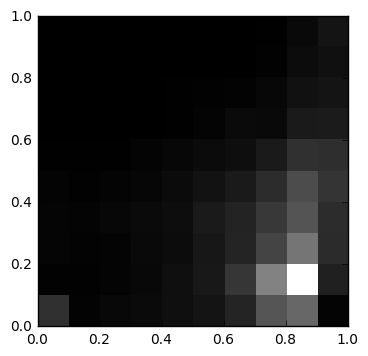

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1103.0    51.0   124.0   134.0   102.0    23.0    4.0    4.0    0.0    4.0
1    81.0    55.0    79.0    92.0    57.0    30.0    0.0    0.0    0.0    0.0
2   182.0    93.0    98.0   168.0    95.0    30.0    5.0    0.0    0.0    0.0
3   239.0   184.0   208.0   246.0   153.0    99.0   19.0    2.0    2.0    0.0
4   341.0   341.0   277.0   307.0   252.0   165.0   29.0   24.0    5.0    0.0
5   471.0   558.0   526.0   591.0   425.0   268.0   95.0   65.0    6.0    5.0
6   854.0  1229.0   842.0   808.0   605.0   333.0  232.0   75.0   13.0    4.0
7  1924.0  2949.0  1537.0  1289.0   998.0   595.0  225.0  166.0   58.0   26.0
8  2327.0  5775.0  2650.0  1905.0  1716.0  1125.0  608.0  398.0  293.0  220.0
9   102.0   755.0   984.0   995.0  1205.0  1039.0  613.0  471.0  381.0  459.0
(10, 10)


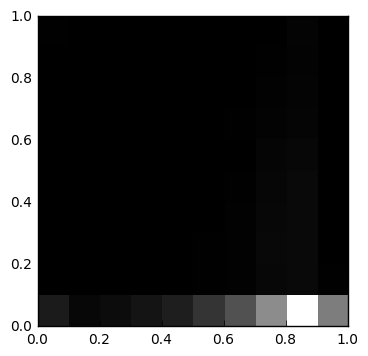

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0   1465.0    8.0    4.0    8.0    0.0    0.0    0.0    0.0    0.0   64.0
1    386.0    6.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
2    659.0    6.0    2.0    2.0    2.0    0.0    0.0    0.0    0.0    0.0
3   1109.0   19.0   19.0    3.0    2.0    0.0    0.0    0.0    0.0    0.0
4   1647.0   43.0   26.0   18.0    1.0    4.0    2.0    0.0    0.0    0.0
5   2809.0   57.0   54.0   32.0   27.0   13.0   14.0    2.0    2.0    0.0
6   4354.0  147.0  119.0  112.0  102.0   49.0   54.0   36.0   18.0    4.0
7   7491.0  408.0  436.0  377.0  352.0  306.0  183.0  113.0   54.0   47.0
8  13675.0  498.0  492.0  509.0  489.0  397.0  315.0  237.0  181.0  224.0
9   6721.0   55.0   39.0   46.0   40.0   19.0   17.0   17.0    5.0   45.0
(10, 10)


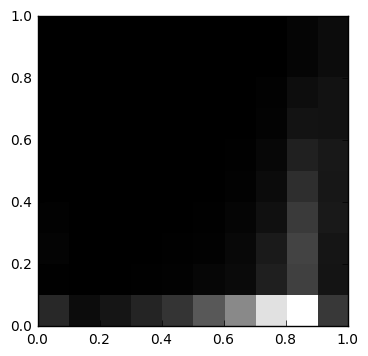

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1234.0    56.0   137.0    83.0     0.0    4.0    0.0    4.0    8.0   23.0
1   383.0     8.0     3.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
2   637.0    27.0     7.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
3  1076.0    39.0    25.0     8.0     4.0    0.0    0.0    0.0    0.0    0.0
4  1601.0    65.0    43.0    14.0     9.0    9.0    0.0    0.0    0.0    0.0
5  2647.0   180.0    85.0    48.0    27.0   20.0    1.0    2.0    0.0    0.0
6  4099.0   324.0   259.0   174.0    79.0   47.0    7.0    6.0    0.0    0.0
7  6743.0   942.0   787.0   497.0   358.0  214.0  118.0   63.0   24.0   21.0
8  7648.0  1926.0  2020.0  1755.0  1397.0  957.0  588.0  393.0  165.0  168.0
9  1692.0   608.0   642.0   768.0   715.0  724.0  567.0  544.0  381.0  363.0
(10, 10)


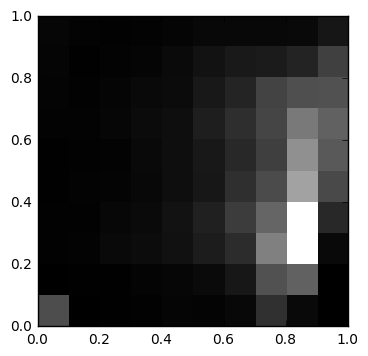

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  1118.0    13.0    32.0    34.0    24.0    23.0    58.0    74.0   78.0   
1    13.0    26.0    51.0    39.0    52.0    43.0    53.0    44.0   26.0   
2    22.0    28.0   143.0   104.0    60.0    54.0    96.0    78.0   50.0   
3    33.0    65.0   183.0   154.0   124.0   140.0   172.0   136.0   87.0   
4    78.0   103.0   249.0   277.0   212.0   206.0   210.0   167.0  156.0   
5    60.0   154.0   421.0   491.0   349.0   350.0   437.0   355.0  267.0   
6   121.0   339.0   667.0   880.0   690.0   596.0   673.0   527.0  372.0   
7   716.0  1192.0  1861.0  1471.0  1089.0   925.0  1006.0   977.0  406.0   
8   145.0  1421.0  3711.0  3709.0  2355.0  2091.0  1763.0  1153.0  523.0   
9     2.0    14.0   142.0   607.0  1077.0  1295.0  1431.0  1180.0  934.0   

       9  
0   95.0  
1   47.0  
2   36.0  
3   58.0  
4   83.0  
5  126.0  
6  130.0  
7  124.0  
8  146.0  
9  322.0  
(10, 10)


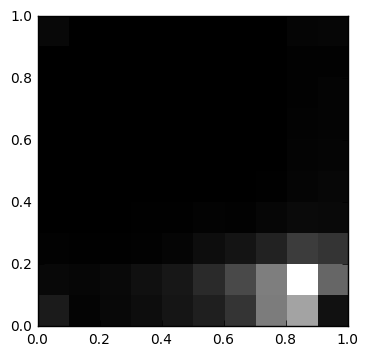

(10, 10)
        0       1       2      3      4      5      6      7     8      9
0   905.0   282.0    71.0   13.0    0.0    0.0    0.0    0.0   8.0  270.0
1   139.0   202.0    47.0    6.0    0.0    0.0    0.0    0.0   0.0    0.0
2   296.0   321.0    40.0   14.0    0.0    0.0    0.0    0.0   0.0    0.0
3   460.0   545.0    87.0   55.0    3.0    0.0    2.0    0.0   0.0    0.0
4   709.0   774.0   197.0   59.0    0.0    0.0    0.0    2.0   0.0    0.0
5  1034.0  1422.0   431.0  117.0    6.0    0.0    0.0    0.0   0.0    0.0
6  1738.0  2474.0   686.0   83.0    7.0    7.0    0.0    0.0   0.0    0.0
7  4113.0  4177.0  1129.0  213.0   65.0   23.0   16.0   11.0   6.0   14.0
8  5403.0  8475.0  1998.0  352.0  175.0  147.0  131.0   84.0  85.0  167.0
9   580.0  3381.0  1748.0  314.0  252.0  168.0  136.0  133.0  81.0  211.0
(10, 10)


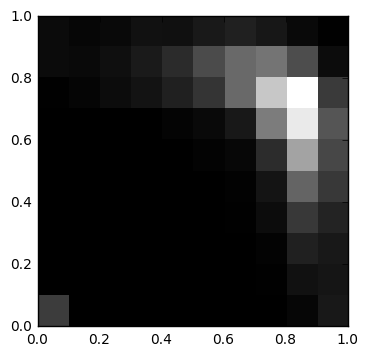

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1089.0    7.0    0.0     5.0    11.0     5.0     3.0    27.0   203.0  199.0
1     0.0    0.0    0.0     0.0     0.0     0.0     0.0    94.0   177.0  123.0
2     0.0    0.0    0.0     0.0     0.0     0.0     5.0   228.0   271.0  167.0
3     0.0    0.0    0.0     0.0     2.0     0.0    12.0   347.0   473.0  318.0
4     0.0    0.0    0.0     0.0     2.0     5.0    72.0   598.0   777.0  287.0
5     0.0    0.0    0.0     0.0    17.0    61.0   173.0   959.0  1351.0  449.0
6     0.0    0.0    0.0    20.0    41.0   129.0   445.0  1880.0  1905.0  575.0
7     7.0   18.0   70.0   221.0   371.0   800.0  2225.0  3548.0  2080.0  427.0
8   121.0  313.0  578.0  1003.0  1792.0  2913.0  4183.0  4564.0  1379.0  171.0
9   440.0  380.0  444.0   637.0  1002.0  1281.0  1533.0  1049.0   216.0   22.0
(10, 10)


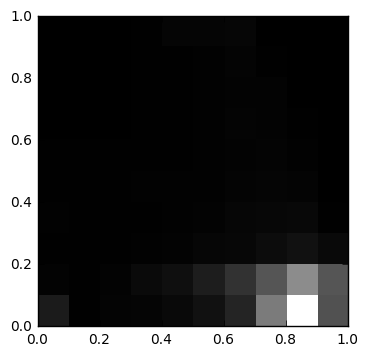

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0   1070.0   126.0   68.0   84.0   78.0   51.0   34.0   15.0   14.0    9.0
1     52.0    72.0   55.0   59.0   42.0   42.0   21.0   21.0    7.0   23.0
2    166.0   154.0   71.0   60.0   51.0   54.0   36.0   20.0   27.0   32.0
3    204.0   396.0   95.0   73.0   91.0   71.0   64.0   51.0   48.0   59.0
4    383.0   627.0  123.0   85.0   92.0   72.0   40.0   46.0   76.0  197.0
5    681.0  1157.0  242.0  147.0  102.0  114.0  107.0  113.0  117.0  230.0
6   1433.0  1972.0  306.0  240.0  179.0  151.0  169.0  145.0  158.0  242.0
7   4846.0  3364.0  497.0  291.0  210.0  180.0  156.0  129.0   57.0   37.0
8  10084.0  5538.0  670.0  354.0  167.0  115.0   60.0   21.0    8.0    0.0
9   3222.0  3365.0  356.0   43.0   14.0    4.0    0.0    0.0    0.0    0.0
(10, 10)


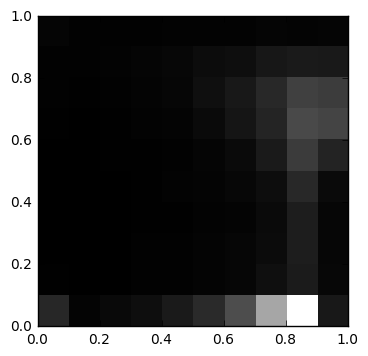

(10, 10)
        0      1      2      3       4       5       6       7      8      9
0  1091.0   42.0   14.0   25.0    17.0    31.0    37.0    64.0   67.0  161.0
1   119.0   22.0    4.0   11.0    20.0    15.0    26.0    43.0   61.0   73.0
2   267.0   29.0   23.0   22.0    26.0    32.0    53.0    60.0   95.0   64.0
3   415.0   76.0   66.0   39.0    45.0    52.0    97.0   124.0  153.0   85.0
4   744.0   85.0   74.0   49.0    95.0    60.0   132.0   195.0  208.0   99.0
5  1193.0  139.0  115.0   93.0   127.0   149.0   309.0   424.0  356.0  105.0
6  2151.0  190.0  187.0  129.0   210.0   301.0   611.0   697.0  408.0  111.0
7  4638.0  427.0  329.0  305.0   371.0   745.0  1030.0  1122.0  649.0  151.0
8  7108.0  769.0  814.0  821.0  1164.0  1657.0  2035.0  1804.0  727.0  118.0
9   694.0  203.0  187.0  175.0   308.0   994.0  1908.0  1675.0  709.0  151.0
(10, 10)


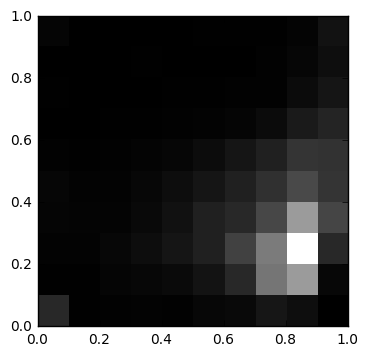

(10, 10)
       0       1       2       3       4       5      6      7      8      9
0  929.0    41.0    83.0   128.0   144.0    52.0   20.0   26.0    5.0  121.0
1   34.0    26.0    84.0    95.0    71.0    44.0   11.0   12.0    3.0   14.0
2   49.0   128.0   179.0   109.0    69.0    50.0   30.0   21.0   22.0   14.0
3   74.0   161.0   305.0   223.0   179.0    94.0   42.0   22.0   31.0   21.0
4   66.0   246.0   476.0   393.0   311.0   140.0   46.0   30.0   14.0   19.0
5  170.0   436.0   740.0   728.0   483.0   289.0   80.0   43.0   15.0   26.0
6  220.0   922.0  1462.0   943.0   754.0   478.0  128.0   46.0   16.0   26.0
7  501.0  2634.0  2770.0  1612.0  1105.0   737.0  254.0   65.0   47.0   42.0
8  336.0  3500.0  5745.0  3497.0  1641.0  1193.0  594.0  261.0  145.0  105.0
9    1.0   173.0   908.0  1561.0  1173.0  1126.0  817.0  494.0  325.0  426.0
(10, 10)


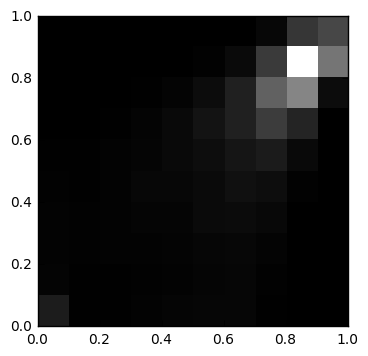

(10, 10)
       0      1      2      3      4      5       6       7       8       9
0  996.0  165.0  118.0  105.0   74.0   47.0    10.0    10.0    21.0     3.0
1   36.0   61.0   75.0   89.0   60.0   43.0    28.0     0.0     2.0     0.0
2   56.0   66.0  122.0  122.0  123.0  108.0    58.0    15.0     1.0     0.0
3  108.0   80.0  111.0  185.0  254.0  200.0   150.0    58.0     4.0     2.0
4  201.0  125.0  155.0  193.0  255.0  313.0   330.0   157.0    10.0     2.0
5  211.0  182.0  240.0  353.0  347.0  477.0   672.0   436.0    91.0     1.0
6  231.0  213.0  268.0  382.0  562.0  729.0  1116.0  1130.0   363.0     1.0
7   54.0   78.0  149.0  283.0  457.0  947.0  2121.0  3404.0  2026.0   248.0
8    0.0    0.0    4.0   22.0   98.0  326.0  1257.0  4609.0  8826.0  1875.0
9    0.0    0.0    0.0    0.0    0.0    2.0    34.0   439.0  4059.0  2470.0
(10, 10)


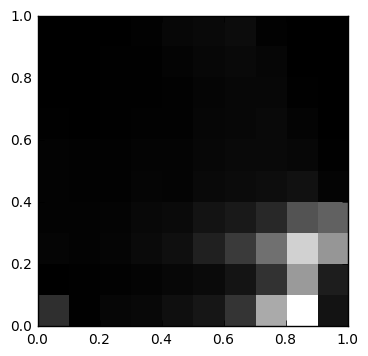

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1093.0     4.0   126.0    92.0   90.0   76.0   32.0   16.0   13.0    7.0
1    43.0    24.0    84.0    72.0   58.0   49.0   23.0    6.0   15.0   20.0
2   141.0    69.0   126.0    98.0   48.0   67.0   38.0   33.0   30.0   21.0
3   195.0   113.0   239.0   186.0  117.0   94.0   64.0   36.0   41.0   67.0
4   348.0   185.0   352.0   233.0  112.0  106.0   66.0   59.0   97.0  183.0
5   521.0   240.0   745.0   445.0  218.0  173.0  147.0  133.0  171.0  217.0
6  1212.0   484.0  1347.0   589.0  275.0  224.0  174.0  185.0  216.0  289.0
7  3942.0  1172.0  2615.0   940.0  311.0  220.0  210.0  163.0  139.0   55.0
8  5926.0  3567.0  4852.0  1941.0  395.0  184.0   99.0   40.0   11.0    2.0
9   457.0   673.0  3493.0  2256.0   98.0   25.0    2.0    0.0    0.0    0.0
(10, 10)


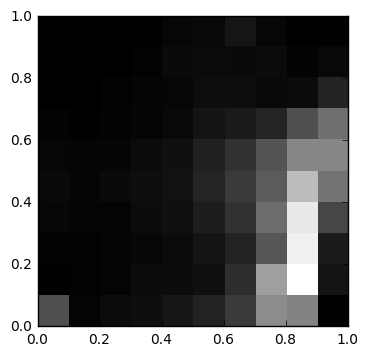

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1067.0    22.0    52.0   109.0   142.0    90.0    47.0   10.0    6.0    4.0
1    61.0    35.0    40.0    65.0    72.0    72.0    19.0   12.0   14.0    4.0
2   156.0    68.0    66.0    64.0   138.0    80.0    49.0   32.0   14.0    4.0
3   193.0   151.0   102.0   170.0   193.0   153.0    72.0   58.0   33.0   27.0
4   307.0   165.0   151.0   222.0   241.0   227.0   114.0   90.0  139.0   85.0
5   454.0   221.0   273.0   389.0   491.0   441.0   271.0  185.0  152.0  133.0
6   774.0   615.0   475.0   677.0   776.0   676.0   366.0  194.0  149.0  293.0
7  1867.0  2111.0  1151.0  1443.0  1221.0  1118.0   482.0  126.0  152.0   96.0
8  1755.0  3392.0  3193.0  3100.0  2494.0  1796.0  1057.0  162.0   53.0   15.0
9    29.0   275.0   368.0   937.0  1538.0  1780.0  1474.0  472.0  110.0   21.0
(10, 10)


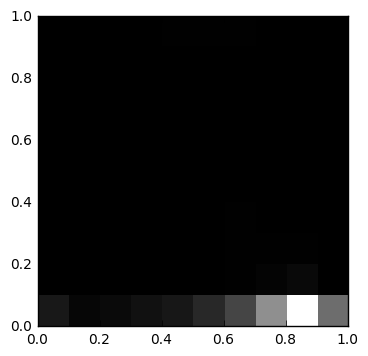

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0   1545.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0
1    392.0    2.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
2    649.0    0.0    6.0   2.0   2.0   0.0   2.0   2.0   2.0    6.0
3   1097.0    6.0    8.0   2.0   8.0   0.0   2.0   2.0   6.0   21.0
4   1480.0   20.0   23.0  16.0  15.0  14.0  17.0  23.0  33.0  100.0
5   2586.0   46.0   26.0  32.0  42.0  59.0  47.0  54.0  27.0   91.0
6   4396.0   75.0   76.0  65.0  44.0  56.0  60.0  55.0  60.0  108.0
7   9148.0  315.0  104.0  53.0  34.0  43.0  16.0  27.0  12.0   15.0
8  16302.0  588.0   79.0  26.0   8.0   2.0   2.0   2.0   2.0    6.0
9   6984.0   19.0    1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
(10, 10)


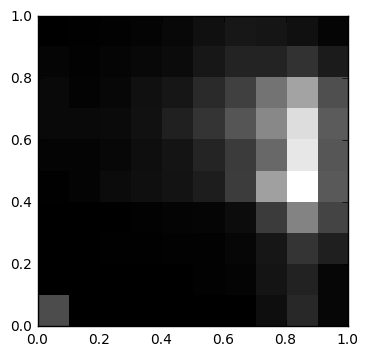

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1089.0    7.0    6.0     5.0    26.0    59.0   129.0   134.0   81.0   13.0
1     0.0    0.0    9.0     0.0    70.0    61.0   133.0    55.0   38.0   28.0
2     0.0    0.0   15.0    12.0   166.0   101.0   152.0   110.0   75.0   40.0
3     0.0    3.0   21.0    32.0   219.0   206.0   246.0   236.0  122.0   67.0
4     2.0    2.0   31.0    69.0   276.0   289.0   478.0   314.0  166.0  114.0
5     2.0   30.0   36.0    82.0   420.0   529.0   737.0   596.0  339.0  239.0
6    10.0   59.0   87.0   179.0   864.0   844.0  1205.0   912.0  499.0  336.0
7   210.0  286.0  313.0   839.0  2277.0  1477.0  1928.0  1630.0  508.0  299.0
8   588.0  494.0  741.0  1877.0  3622.0  3275.0  3136.0  2332.0  719.0  233.0
9    99.0   97.0  446.0   972.0  1277.0  1221.0  1290.0  1127.0  392.0   83.0
(10, 10)


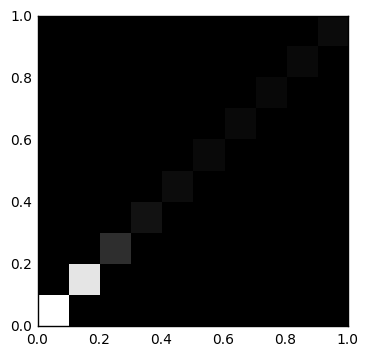

(10, 10)
         0        1       2       3      4      5      6      7      8      9
0  19765.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
1      0.0  17747.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
2      0.0      0.0  3610.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
3      0.0      0.0     0.0  1419.0    0.0    0.0    0.0    0.0    0.0    0.0
4      0.0      0.0     0.0     0.0  978.0    0.0    0.0    0.0    0.0    0.0
5      0.0      0.0     0.0     0.0    0.0  722.0    0.0    0.0    0.0    0.0
6      0.0      0.0     0.0     0.0    0.0    0.0  726.0    0.0    0.0    0.0
7      0.0      0.0     0.0     0.0    0.0    0.0    0.0  693.0    0.0    0.0
8      0.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0  746.0    0.0
9      0.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0  894.0
(10, 10)


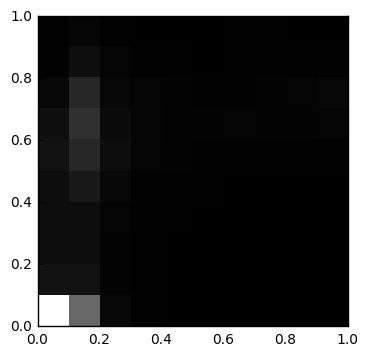

(10, 10)
         0       1      2      3       4       5       6       7      8      9
0  14018.0  1007.0  756.0  760.0   731.0   983.0   833.0   453.0  131.0   93.0
1   5651.0   964.0  746.0  745.0  1355.0  2163.0  2729.0  2170.0  857.0  367.0
2    475.0   213.0  177.0  256.0   433.0   661.0   592.0   416.0  284.0  103.0
3     55.0    65.0   78.0  155.0   154.0   247.0   281.0   226.0  108.0   50.0
4     10.0    36.0   42.0   89.0   127.0   171.0   205.0   169.0   89.0   40.0
5      4.0    14.0   14.0   28.0    72.0   154.0   207.0   140.0   54.0   35.0
6      2.0     2.0   12.0   18.0    44.0   114.0   230.0   158.0   84.0   62.0
7      0.0     2.0    6.0   22.0    34.0    76.0   193.0   182.0   85.0   93.0
8      0.0     0.0    0.0    8.0    30.0    98.0   208.0   269.0   92.0   41.0
9      0.0     0.0    0.0    0.0     6.0    70.0   247.0   437.0  122.0   12.0
(10, 10)


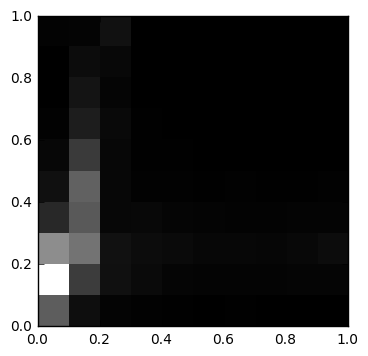

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  3293.0  8983.0  4973.0  1454.0   589.0   266.0    73.0   12.0    8.0  114.0
1   495.0  2175.0  4055.0  3166.0  3419.0  2062.0  1036.0  723.0  446.0  170.0
2   174.0   583.0   625.0   270.0   265.0   271.0   316.0  188.0  306.0  612.0
3    77.0   353.0   452.0   283.0   100.0    55.0    39.0   22.0    7.0   31.0
4    39.0   177.0   353.0   200.0    84.0    41.0    32.0   26.0    8.0   18.0
5    24.0   147.0   271.0   148.0    65.0    32.0    22.0   12.0    0.0    1.0
6    40.0   168.0   250.0   119.0    71.0    28.0    26.0   19.0    5.0    0.0
7    35.0   162.0   225.0   140.0    55.0    30.0    19.0   23.0    4.0    0.0
8    20.0   186.0   307.0   149.0    55.0     9.0    15.0    3.0    2.0    0.0
9     2.0   192.0   440.0   173.0    76.0    11.0     0.0    0.0    0.0    0.0
(10, 10)


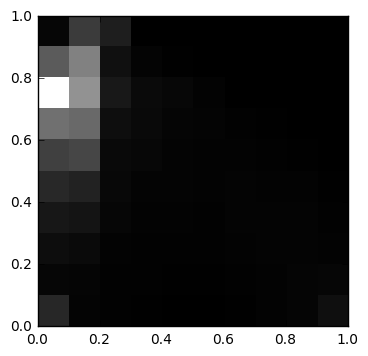

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1199.0  202.0  401.0  696.0  1213.0  1956.0  3415.0  7737.0  2760.0   186.0
1   142.0  169.0  316.0  616.0  1029.0  2121.0  3210.0  4430.0  3908.0  1806.0
2    67.0   64.0   98.0  210.0   256.0   296.0   452.0   742.0   500.0   925.0
3    46.0   73.0   86.0  119.0   124.0   217.0   289.0   306.0   136.0    23.0
4    21.0   45.0   74.0  113.0   141.0   137.0   176.0   215.0    45.0    11.0
5    15.0   52.0   90.0   86.0   106.0   117.0   140.0   106.0     9.0     1.0
6    35.0   62.0  116.0  134.0   151.0   117.0    78.0    29.0     4.0     0.0
7    93.0   95.0  138.0  129.0   107.0    79.0    50.0     2.0     0.0     0.0
8   180.0  174.0  130.0  125.0    98.0    34.0     5.0     0.0     0.0     0.0
9   465.0  211.0  102.0   79.0    33.0     4.0     0.0     0.0     0.0     0.0
(10, 10)


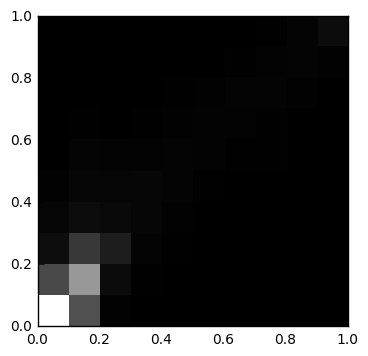

(10, 10)
         0       1       2      3      4      5      6      7      8      9
0  14380.0  4125.0   737.0  318.0  129.0   41.0   23.0   12.0    0.0    0.0
1   4502.0  8544.0  3257.0  675.0  370.0  247.0  104.0   34.0   14.0    0.0
2    146.0   634.0  1672.0  560.0  329.0  179.0   55.0   24.0   11.0    0.0
3      4.0   108.0   228.0  366.0  366.0  169.0  102.0   53.0   22.0    1.0
4      0.0    19.0    91.0  154.0  261.0  241.0  124.0   69.0   19.0    0.0
5      0.0     2.0    16.0   54.0  109.0  193.0  181.0  123.0   38.0    6.0
6      0.0     0.0     0.0   23.0   48.0  103.0  220.0  229.0   96.0    7.0
7      0.0     0.0     0.0    5.0   18.0   67.0   96.0  238.0  212.0   57.0
8      0.0     0.0     0.0    0.0    5.0   24.0   52.0  144.0  263.0  258.0
9      0.0     0.0     0.0    0.0    0.0    4.0    5.0   45.0  147.0  693.0
(10, 10)


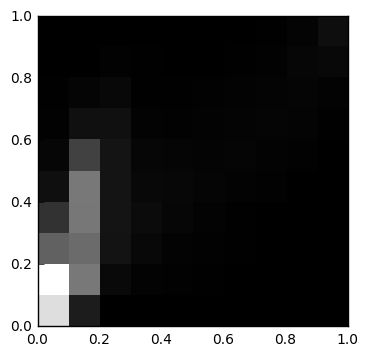

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  6727.0  7743.0  2977.0  1541.0   468.0   188.0   63.0   50.0    4.0    4.0
1   859.0  3644.0  3257.0  3610.0  3659.0  2013.0  508.0  175.0   22.0    0.0
2    20.0   297.0   580.0   629.0   619.0   633.0  500.0  269.0   62.0    1.0
3    10.0   113.0   253.0   347.0   268.0   198.0  112.0   57.0   42.0   19.0
4     6.0    90.0   120.0   190.0   224.0   176.0   85.0   55.0   11.0   21.0
5     0.0    36.0    65.0   106.0   158.0   136.0   95.0   78.0   29.0   19.0
6     2.0    24.0    35.0    59.0   106.0   173.0  137.0  120.0   42.0   28.0
7     0.0    25.0    22.0    30.0    76.0   109.0  159.0  140.0   77.0   55.0
8     0.0    18.0    12.0    18.0    16.0    70.0  128.0  157.0  200.0  127.0
9     0.0     0.0     4.0     5.0    14.0    11.0   43.0  104.0  269.0  444.0
(10, 10)


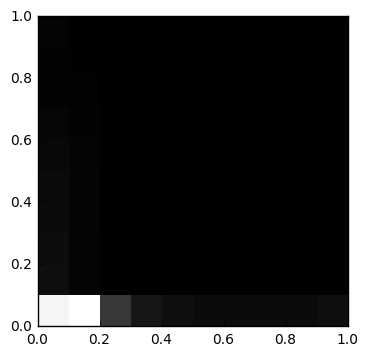

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0  15031.0  904.0  857.0  730.0  669.0  518.0  370.0  244.0  167.0  275.0
1  15682.0  300.0  305.0  352.0  331.0  255.0  197.0  150.0   93.0   82.0
2   3541.0   13.0   10.0   11.0    2.0    8.0    8.0    4.0    0.0   13.0
3   1385.0    2.0    4.0    4.0    2.0    2.0    8.0    4.0    0.0    8.0
4    966.0    4.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0
5    716.0    2.0    2.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0
6    721.0    0.0    0.0    2.0    2.0    0.0    1.0    0.0    0.0    0.0
7    676.0    3.0    2.0    2.0    4.0    3.0    0.0    3.0    0.0    0.0
8    727.0    7.0    7.0    0.0    3.0    0.0    0.0    0.0    0.0    2.0
9    871.0   12.0    2.0    6.0    2.0    0.0    1.0    0.0    0.0    0.0
(10, 10)


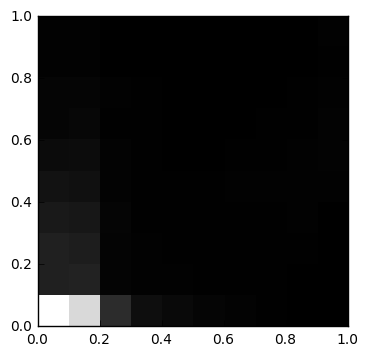

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  12869.0  1694.0  1662.0  1270.0  910.0  558.0  293.0  263.0  118.0  128.0
1  10938.0  1755.0  1503.0  1170.0  819.0  632.0  385.0  280.0  154.0  111.0
2   2221.0   218.0   241.0   285.0  191.0  158.0  102.0  107.0   38.0   49.0
3    719.0   128.0   124.0   104.0   77.0   73.0   55.0   56.0   39.0   44.0
4    468.0   118.0    92.0    60.0   57.0   49.0   52.0   31.0   32.0   19.0
5    269.0    81.0    83.0    76.0   58.0   44.0   39.0   14.0   22.0   36.0
6    157.0    83.0   103.0   104.0  109.0   62.0   44.0   24.0   22.0   18.0
7     91.0    61.0    98.0    76.0  107.0   94.0   68.0   50.0   26.0   22.0
8     24.0    25.0    78.0   151.0  119.0  126.0   77.0   62.0   45.0   39.0
9      4.0    12.0    24.0    51.0  142.0  179.0  166.0  125.0   82.0  109.0
(10, 10)


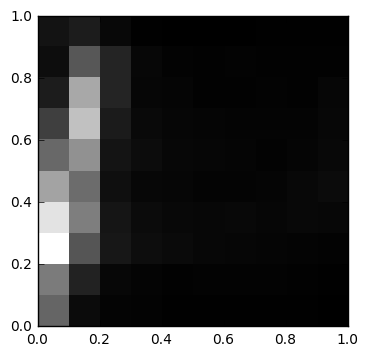

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  1821.0  2223.0  4590.0  4072.0  2942.0  1878.0  1144.0   510.0   235.0   
1   214.0   621.0  1532.0  2260.0  1953.0  2601.0  3471.0  3021.0  1560.0   
2    72.0   127.0   413.0   385.0   276.0   366.0   495.0   649.0   670.0   
3    55.0    83.0   245.0   210.0   143.0   232.0   170.0   118.0   133.0   
4    32.0    53.0   195.0   154.0   117.0   126.0   124.0    97.0    65.0   
5    22.0    58.0   130.0   126.0    89.0   109.0    93.0    51.0    40.0   
6    32.0    64.0   112.0   148.0    75.0    96.0    88.0    37.0    60.0   
7    32.0    55.0    97.0   124.0    92.0    69.0    86.0    54.0    52.0   
8    28.0    51.0    84.0   153.0   147.0    98.0    86.0    45.0    36.0   
9     0.0    20.0    62.0   134.0   198.0   148.0   142.0   109.0    48.0   

       9  
0  350.0  
1  514.0  
2  157.0  
3   30.0  
4   15.0  
5    4.0  
6   14.0  
7   32.0  
8   18.0  
9   33.0  
(10, 10)


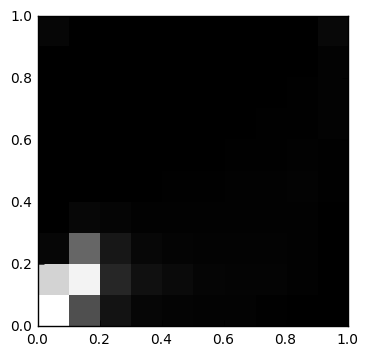

(10, 10)
         0       1       2      3      4      5      6      7      8      9
0  10492.0  8714.0   263.0   16.0    0.0    0.0    2.0    0.0    8.0  270.0
1   3250.0  9985.0  4199.0  310.0    0.0    1.0    0.0    2.0    0.0    0.0
2    807.0  1598.0   956.0  241.0    8.0    0.0    0.0    0.0    0.0    0.0
3    277.0   691.0   300.0  111.0   32.0    8.0    0.0    0.0    0.0    0.0
4    200.0   411.0   199.0   93.0   55.0   14.0    4.0    0.0    2.0    0.0
5    136.0   226.0   145.0  111.0   56.0   25.0   15.0    3.0    2.0    3.0
6    133.0   172.0   128.0  102.0   82.0   59.0   29.0    7.0    8.0    6.0
7     62.0   164.0   123.0  115.0   91.0   65.0   45.0   12.0    6.0   10.0
8     20.0    90.0   107.0   97.0  141.0  110.0   61.0   60.0   24.0   36.0
9      0.0     2.0    14.0   30.0   43.0   63.0  129.0  146.0  130.0  337.0
(10, 10)


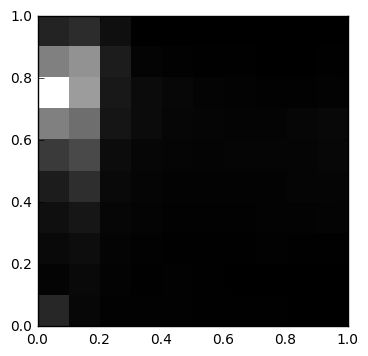

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1097.0  123.0  262.0  426.0   798.0  1655.0  3620.0  7187.0  3603.0   994.0
1   205.0  264.0  370.0  641.0  1315.0  2056.0  3094.0  4406.0  4124.0  1272.0
2    82.0   98.0  121.0  179.0   260.0   341.0   597.0   697.0   793.0   442.0
3    68.0   53.0   57.0  116.0   155.0   187.0   326.0   323.0   118.0    16.0
4    73.0   62.0   48.0   66.0    93.0   168.0   193.0   198.0    67.0    10.0
5    29.0   32.0   40.0   73.0    99.0   117.0   148.0   135.0    47.0     2.0
6    43.0   27.0   45.0   73.0   112.0   158.0   139.0    96.0    31.0     2.0
7    43.0   26.0   71.0   89.0   110.0   158.0   118.0    67.0    11.0     0.0
8    15.0   21.0   46.0   95.0   150.0   148.0   191.0    76.0     4.0     0.0
9     2.0   12.0   32.0  128.0   146.0   206.0   225.0   109.0    34.0     0.0
(10, 10)


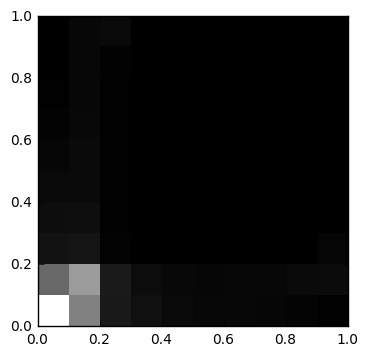

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0  12207.0  4989.0  880.0  621.0  440.0  302.0  175.0   93.0   43.0   15.0
1   6194.0  7394.0  964.0  704.0  516.0  480.0  426.0  368.0  343.0  358.0
2   1234.0  1261.0  177.0   69.0   58.0   66.0   78.0   90.0  121.0  456.0
3    765.0   573.0   47.0   13.0    6.0    1.0    8.0    5.0    1.0    0.0
4    495.0   421.0   26.0   16.0    6.0    5.0    0.0    5.0    4.0    0.0
5    359.0   329.0   32.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0
6    338.0   355.0   27.0    6.0    0.0    0.0    0.0    0.0    0.0    0.0
7    307.0   368.0   16.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0
8    193.0   510.0   40.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0
9     49.0   571.0  274.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


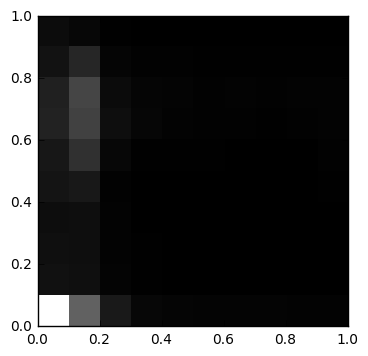

(10, 10)
         0      1      2      3       4       5       6       7       8      9
0  11384.0  779.0  699.0  597.0   899.0  1050.0  1519.0  1439.0   843.0  556.0
1   4381.0  690.0  637.0  641.0  1108.0  2179.0  2952.0  3087.0  1719.0  353.0
2   1158.0  188.0  170.0  160.0   132.0   346.0   665.0   505.0   232.0   54.0
3    347.0   78.0   66.0   49.0    41.0    95.0   316.0   263.0   129.0   35.0
4    233.0   45.0   45.0   38.0    40.0    84.0   171.0   195.0   111.0   16.0
5    200.0   32.0   36.0   30.0    11.0    67.0   120.0   120.0    84.0   22.0
6    196.0   42.0   35.0   39.0    16.0    40.0   112.0   152.0    72.0   22.0
7    187.0   30.0   33.0   37.0    21.0    32.0    95.0   141.0    81.0   36.0
8    173.0   47.0   46.0   42.0    50.0    42.0   119.0   142.0    69.0   16.0
9    161.0   51.0   46.0   36.0    65.0   101.0   169.0   164.0    93.0    8.0
(10, 10)


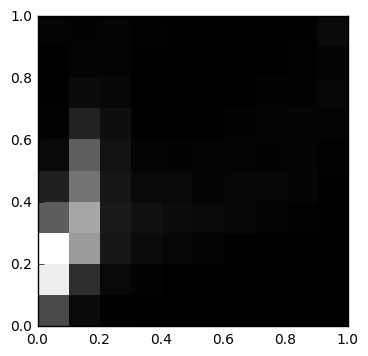

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  2033.0  6603.0  7093.0  2582.0   929.0   274.0   64.0   53.0   17.0  117.0
1   284.0  1301.0  4313.0  4604.0  3196.0  2617.0  944.0  287.0  113.0   88.0
2    39.0   233.0   649.0   697.0   624.0   514.0  390.0  220.0  129.0  115.0
3    18.0    95.0   317.0   444.0   262.0   116.0   54.0   26.0   23.0   64.0
4     6.0    21.0   191.0   321.0   226.0    88.0   48.0   22.0   14.0   41.0
5     0.0    10.0   116.0   231.0   136.0   124.0   44.0   17.0   26.0   18.0
6     0.0     4.0    50.0   200.0   183.0   133.0   87.0   20.0   26.0   23.0
7     0.0     0.0    17.0   136.0   174.0   109.0  118.0   86.0   27.0   26.0
8     0.0     0.0     6.0    69.0   149.0   150.0  141.0  105.0   83.0   43.0
9     0.0     0.0     0.0     5.0    51.0    78.0  132.0  184.0  165.0  279.0
(10, 10)


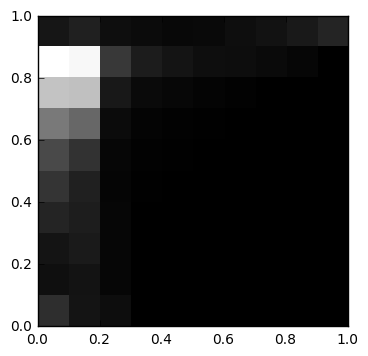

(10, 10)
        0      1      2      3       4       5       6       7       8      9
0  1093.0  373.0  483.0  864.0  1235.0  1744.0  2856.0  4577.0  6003.0  537.0
1   474.0  455.0  614.0  695.0   797.0  1180.0  2421.0  4506.0  5826.0  779.0
2   326.0  142.0  143.0  155.0   139.0   156.0   268.0   578.0  1355.0  348.0
3     0.0    0.0    2.0   16.0    46.0    55.0   100.0   256.0   679.0  265.0
4     0.0    0.0    0.0    4.0    13.0    43.0    67.0   172.0   479.0  200.0
5     0.0    0.0    0.0    0.0     0.0    14.0    46.0   100.0   333.0  229.0
6     0.0    0.0    0.0    0.0     0.0     0.0    16.0    56.0   320.0  334.0
7     0.0    0.0    0.0    0.0     0.0     0.0     2.0    11.0   247.0  433.0
8     0.0    0.0    0.0    0.0     0.0     0.0     0.0     2.0   148.0  596.0
9     0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    13.0  881.0
(10, 10)


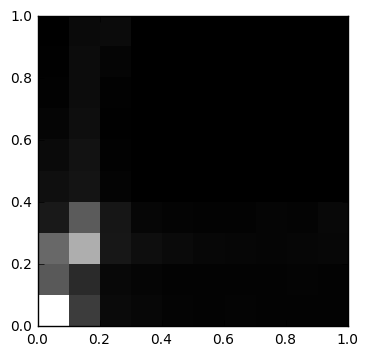

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  9902.0  3495.0  4050.0   976.0  610.0  389.0  197.0   85.0   48.0   13.0
1  2343.0  1630.0  6767.0  3554.0  809.0  713.0  575.0  476.0  470.0  410.0
2   400.0   338.0   917.0   864.0  175.0   86.0   67.0  110.0  215.0  438.0
3   299.0   222.0   568.0   270.0   38.0   12.0   10.0    0.0    0.0    0.0
4   184.0   149.0   407.0   187.0   29.0   16.0    6.0    0.0    0.0    0.0
5   151.0   130.0   287.0   134.0   18.0    2.0    0.0    0.0    0.0    0.0
6   166.0   130.0   252.0   152.0   26.0    0.0    0.0    0.0    0.0    0.0
7   144.0   138.0   200.0   197.0   14.0    0.0    0.0    0.0    0.0    0.0
8   154.0   156.0   250.0   183.0    3.0    0.0    0.0    0.0    0.0    0.0
9   135.0   143.0   281.0   335.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


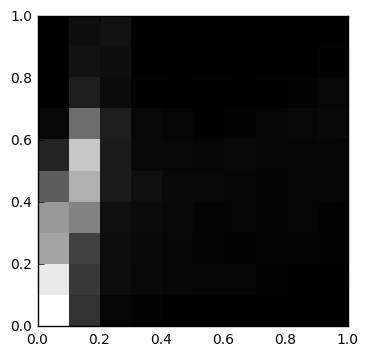

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  5327.0  4868.0  3437.0  3203.0  1952.0   755.0   165.0   38.0   13.0    7.0
1  1043.0  1204.0  1374.0  2749.0  3658.0  4145.0  2272.0  627.0  383.0  292.0
2   113.0   262.0   277.0   322.0   546.0   572.0   625.0  229.0  302.0  362.0
3    74.0   184.0   197.0   231.0   325.0   187.0   148.0   56.0   17.0    0.0
4    23.0   125.0   138.0   174.0   205.0   151.0   124.0   22.0   16.0    0.0
5    30.0   107.0   104.0   104.0   163.0   106.0    61.0   44.0    3.0    0.0
6    14.0   116.0    82.0   109.0   111.0   161.0    78.0   39.0   16.0    0.0
7    22.0    68.0    98.0   101.0    87.0   120.0   121.0   62.0   14.0    0.0
8    17.0    62.0    84.0   112.0   121.0   106.0   163.0   64.0   14.0    3.0
9     0.0    59.0    80.0    71.0   138.0   130.0   194.0  160.0   44.0   18.0
(10, 10)


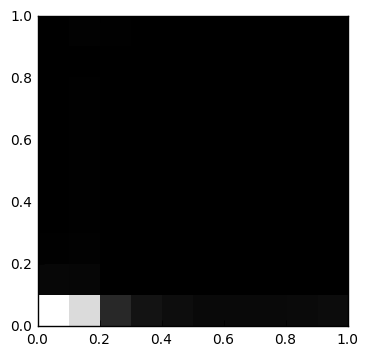

(10, 10)
         0      1      2     3     4     5     6      7     8      9
0  19039.0  524.0   91.0  46.0  18.0  14.0  11.0    8.0   4.0   10.0
1  16331.0  493.0  187.0  93.0  87.0  86.0  81.0  108.0  69.0  212.0
2   3031.0   54.0   45.0  57.0  48.0  74.0  54.0   49.0  69.0  129.0
3   1419.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
4    978.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
5    722.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
6    726.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
7    693.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
8    746.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
9    894.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0   0.0    0.0
(10, 10)


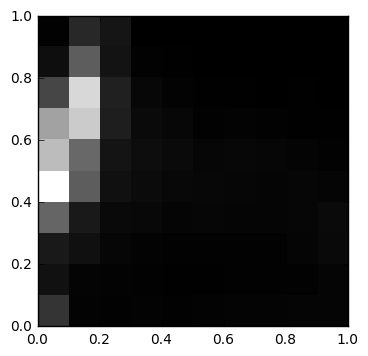

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1166.0  396.0  574.0  2247.0  5666.0  4163.0  3603.0  1566.0   327.0   57.0
1    86.0  107.0  373.0   561.0  2071.0  2311.0  4506.0  4783.0  2059.0  890.0
2    61.0   79.0  147.0   206.0   367.0   446.0   680.0   732.0   421.0  471.0
3    80.0   63.0   72.0   187.0   249.0   298.0   234.0   169.0    45.0   22.0
4    61.0   32.0   58.0   129.0   183.0   230.0   162.0    78.0    34.0   11.0
5    71.0   39.0   45.0   133.0   158.0   154.0    61.0    41.0    19.0    1.0
6   110.0   47.0   48.0   113.0   138.0   155.0    69.0    25.0    21.0    0.0
7   110.0   47.0   62.0   111.0   129.0   140.0    64.0    20.0    10.0    0.0
8   131.0   50.0  111.0   152.0   138.0   106.0    24.0    31.0     3.0    0.0
9   124.0  118.0  215.0   228.0   118.0    59.0    31.0     1.0     0.0    0.0
(10, 10)


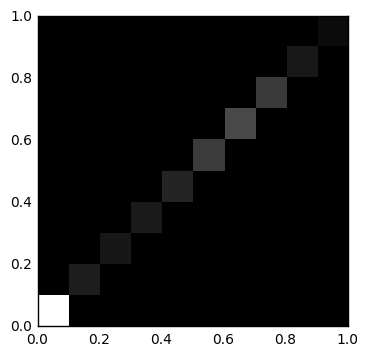

(10, 10)
         0       1       2       3       4       5       6       7       8  \
0  20215.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.0  2303.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.0     0.0  1831.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.0     0.0     0.0  2081.0     0.0     0.0     0.0     0.0     0.0   
4      0.0     0.0     0.0     0.0  2986.0     0.0     0.0     0.0     0.0   
5      0.0     0.0     0.0     0.0     0.0  4737.0     0.0     0.0     0.0   
6      0.0     0.0     0.0     0.0     0.0     0.0  5725.0     0.0     0.0   
7      0.0     0.0     0.0     0.0     0.0     0.0     0.0  4620.0     0.0   
8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1906.0   
9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  896.0  
(10, 10)


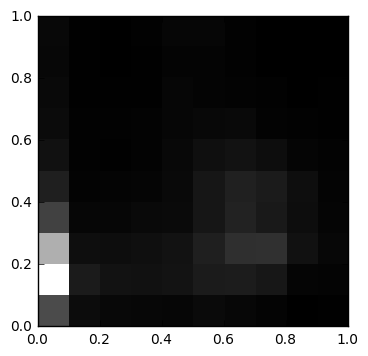

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  2327.0  7845.0  5391.0  1999.0  959.0  537.0  355.0  284.0  244.0  274.0
1   381.0   857.0   444.0   198.0   95.0   88.0   73.0   61.0   61.0   45.0
2   271.0   564.0   419.0   214.0  136.0   61.0   79.0   41.0   17.0   29.0
3   242.0   523.0   461.0   278.0  182.0  116.0   93.0   48.0   58.0   80.0
4   209.0   605.0   582.0   312.0  280.0  256.0  214.0  185.0  141.0  202.0
5   320.0   839.0   956.0   694.0  687.0  481.0  251.0  152.0  151.0  206.0
6   228.0   867.0  1466.0  1055.0  987.0  569.0  299.0  118.0   63.0   73.0
7   147.0   707.0  1473.0   770.0  855.0  422.0  106.0   88.0   22.0   30.0
8    22.0   173.0   539.0   424.0  450.0  182.0   68.0   16.0   25.0    7.0
9    52.0   146.0   220.0   158.0  148.0   93.0   40.0   35.0    4.0    0.0
(10, 10)


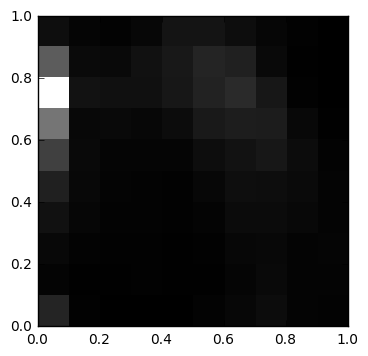

(10, 10)
        0      1      2      3       4       5       6       7       8      9
0  1150.0  148.0  270.0  555.0  1051.0  2013.0  3680.0  7996.0  2897.0  455.0
1    77.0   49.0  122.0  192.0   262.0   283.0   267.0   565.0   315.0  171.0
2    26.0   34.0   92.0  117.0   153.0   175.0   308.0   510.0   297.0  119.0
3    28.0   65.0   83.0   94.0   115.0   185.0   227.0   507.0   550.0  227.0
4    28.0   50.0   52.0   76.0    90.0   183.0   389.0   732.0   759.0  627.0
5    95.0   54.0   84.0  139.0   222.0   431.0   791.0  1092.0  1185.0  644.0
6   220.0  182.0  236.0  347.0   456.0   584.0   933.0  1335.0  1003.0  429.0
7   392.0  294.0  280.0  356.0   414.0   740.0   887.0   731.0   311.0  215.0
8   136.0  131.0  156.0  276.0   343.0   386.0   280.0    92.0    41.0   65.0
9   111.0  140.0  176.0  155.0   152.0    98.0    53.0     7.0     4.0    0.0
(10, 10)


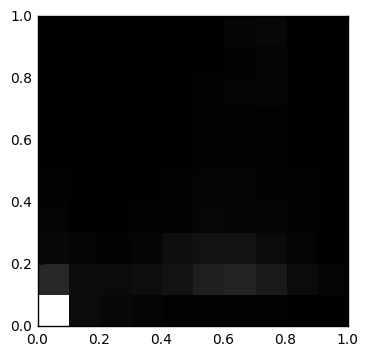

(10, 10)
         0       1       2      3      4      5      6      7      8      9
0  16520.0  2609.0   547.0  270.0  176.0   65.0   20.0    8.0    0.0    0.0
1    832.0   822.0   304.0  127.0   99.0   75.0   32.0   10.0    2.0    0.0
2    533.0   770.0   226.0  108.0   97.0   58.0   23.0    8.0    8.0    0.0
3    369.0   965.0   385.0  137.0   71.0   63.0   40.0   37.0   10.0    4.0
4    187.0  1267.0   932.0  196.0  141.0  107.0   64.0   46.0   31.0   15.0
5    146.0  2031.0  1179.0  401.0  281.0  202.0  149.0  144.0  100.0  104.0
6    167.0  2269.0  1254.0  372.0  289.0  256.0  246.0  278.0  254.0  340.0
7    146.0  1690.0   748.0  333.0  255.0  226.0  182.0  285.0  286.0  469.0
8     63.0   719.0   318.0  157.0  136.0   90.0  112.0  109.0  114.0   88.0
9     69.0   290.0   108.0   54.0   90.0  126.0   94.0   46.0   17.0    2.0
(10, 10)


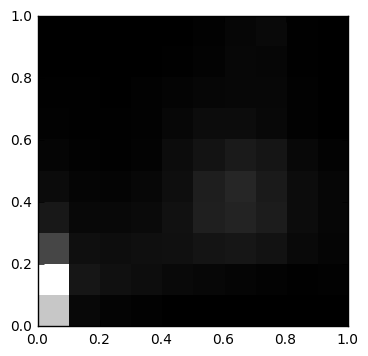

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  7040.0  9054.0  2510.0   881.0   424.0  179.0   81.0   40.0    6.0    0.0
1   293.0   795.0   533.0   299.0   182.0   95.0   53.0   38.0    8.0    7.0
2   142.0   584.0   460.0   306.0   167.0   70.0   62.0   26.0    8.0    6.0
3    91.0   477.0   534.0   384.0   264.0  134.0   83.0   83.0   25.0    6.0
4    24.0   334.0   572.0   634.0   522.0  437.0  255.0  155.0   38.0   15.0
5     2.0   256.0   721.0  1126.0  1087.0  695.0  438.0  221.0  113.0   78.0
6    22.0   185.0   790.0  1241.0  1351.0  933.0  438.0  282.0  262.0  221.0
7    10.0   130.0   669.0   991.0   937.0  745.0  296.0  275.0  238.0  329.0
8     0.0    69.0   336.0   453.0   455.0  306.0  101.0   72.0   58.0   56.0
9     0.0   106.0   200.0   220.0   219.0  113.0   23.0   13.0    2.0    0.0
(10, 10)


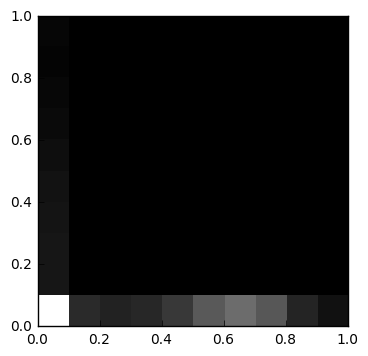

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  13436.0  1203.0  1160.0  1086.0  997.0  779.0  567.0  386.0  249.0  352.0
1   2236.0     8.0     8.0     8.0    7.0    2.0    8.0   10.0    4.0   12.0
2   1808.0     2.0     2.0     0.0    0.0    2.0    2.0    4.0    7.0    4.0
3   2067.0     2.0     2.0     0.0    0.0    0.0    2.0    2.0    0.0    6.0
4   2972.0     2.0     6.0     0.0    2.0    0.0    4.0    0.0    0.0    0.0
5   4704.0     7.0     7.0     3.0    5.0    5.0    1.0    3.0    0.0    2.0
6   5704.0    11.0     0.0     4.0    2.0    0.0    0.0    0.0    0.0    4.0
7   4599.0     8.0     4.0     4.0    0.0    0.0    1.0    0.0    0.0    4.0
8   1894.0     4.0     4.0     2.0    2.0    0.0    0.0    0.0    0.0    0.0
9    896.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


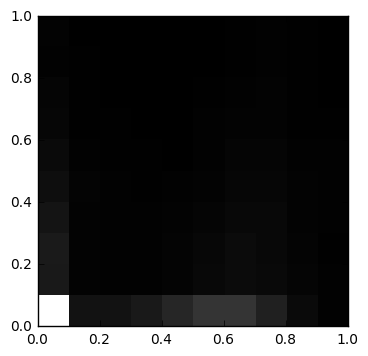

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  13919.0  1409.0  1444.0  1092.0  789.0  574.0  363.0  303.0  150.0  172.0
1   1024.0   214.0   194.0   217.0  222.0  158.0   91.0   97.0   57.0   29.0
2   1001.0   143.0   162.0   136.0  144.0   93.0   64.0   54.0   24.0   10.0
3   1376.0   139.0   163.0   120.0  105.0   84.0   37.0   33.0   20.0    4.0
4   2095.0   251.0   230.0   170.0  111.0   52.0   36.0   26.0   13.0    2.0
5   2930.0   488.0   396.0   322.0  203.0  140.0  116.0   71.0   35.0   36.0
6   2837.0   620.0   608.0   460.0  373.0  309.0  203.0  137.0   75.0  103.0
7   1824.0   518.0   467.0   483.0  340.0  322.0  203.0  184.0  136.0  143.0
8    594.0   279.0   245.0   198.0  173.0  126.0   98.0   69.0   58.0   66.0
9    160.0   114.0    99.0   149.0  129.0  117.0   70.0   38.0   10.0   10.0
(10, 10)


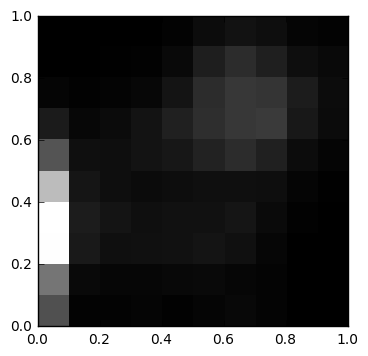

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  1605.0  2339.0  5065.0  5095.0  3758.0  1675.0   549.0   119.0    8.0   
1    70.0   181.0   516.0   568.0   431.0   307.0   159.0    57.0   14.0   
2    70.0   136.0   303.0   413.0   281.0   285.0   232.0    83.0   28.0   
3   102.0   131.0   330.0   310.0   232.0   391.0   384.0   147.0   48.0   
4    54.0   160.0   351.0   341.0   264.0   470.0   666.0   415.0  199.0   
5   111.0   184.0   409.0   345.0   317.0   680.0   921.0   901.0  613.0   
6   166.0   128.0   319.0   424.0   312.0   880.0  1107.0  1110.0  902.0   
7    93.0    90.0   138.0   215.0   298.0   675.0  1159.0  1045.0  624.0   
8    18.0     6.0    14.0    45.0   114.0   258.0   495.0   567.0  279.0   
9    19.0     0.0    15.0    10.0    25.0   102.0   227.0   247.0  184.0   

       9  
0    2.0  
1    0.0  
2    0.0  
3    6.0  
4   66.0  
5  256.0  
6  377.0  
7  283.0  
8  110.0  
9   67.0  
(10, 10)


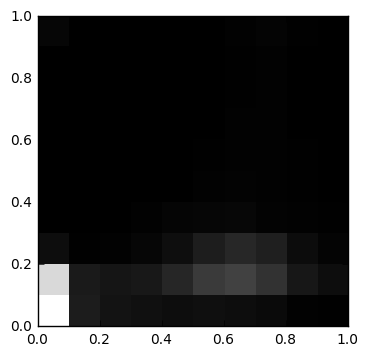

(10, 10)
         0       1       2      3      4      5      6      7     8      9
0  10466.0  8892.0   556.0   18.0    0.0    1.0    2.0    2.0   8.0  270.0
1   1145.0  1064.0    81.0   11.0    2.0    0.0    0.0    0.0   0.0    0.0
2    796.0   878.0   121.0   33.0    3.0    0.0    0.0    0.0   0.0    0.0
3    664.0  1004.0   286.0  110.0   13.0    2.0    2.0    0.0   0.0    0.0
4    550.0  1565.0   582.0  215.0   26.0   10.0   15.0    2.0  10.0   11.0
5    623.0  2412.0  1201.0  261.0   90.0   54.0   38.0   12.0  14.0   32.0
6    570.0  2676.0  1616.0  291.0  151.0  107.0   90.0   77.0  47.0  100.0
7    425.0  2062.0  1277.0  158.0  118.0  108.0  101.0  108.0  85.0  178.0
8     85.0   959.0   529.0   83.0   68.0   42.0   30.0   25.0  16.0   69.0
9     53.0   541.0   185.0   46.0   37.0   21.0    7.0    4.0   0.0    2.0
(10, 10)


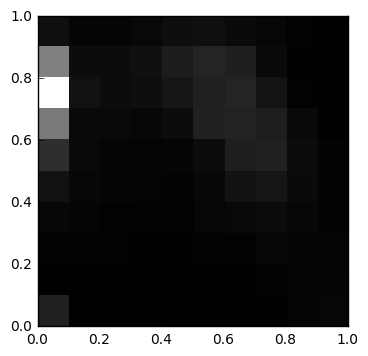

(10, 10)
        0      1      2      3      4       5       6       7       8      9
0  1041.0   38.0  103.0  255.0  586.0  1493.0  3884.0  8187.0  4110.0  518.0
1    29.0   38.0   79.0  162.0  235.0   300.0   350.0   554.0   393.0  163.0
2    14.0   18.0   75.0   92.0  172.0   190.0   289.0   386.0   408.0  187.0
3    16.0   62.0   63.0  109.0  173.0   144.0   250.0   469.0   520.0  275.0
4    51.0   37.0   51.0   75.0  114.0   183.0   403.0   709.0   902.0  461.0
5    47.0   27.0   81.0  196.0  235.0   400.0  1026.0  1047.0  1170.0  508.0
6    46.0   61.0  110.0  272.0  598.0   989.0  1100.0  1215.0   999.0  335.0
7    53.0  106.0  228.0  382.0  700.0  1039.0   986.0   630.0   292.0  204.0
8   152.0  145.0  172.0  234.0  340.0   353.0   301.0    89.0    33.0   87.0
9   208.0  186.0  130.0  109.0   85.0   103.0    62.0     8.0     5.0    0.0
(10, 10)


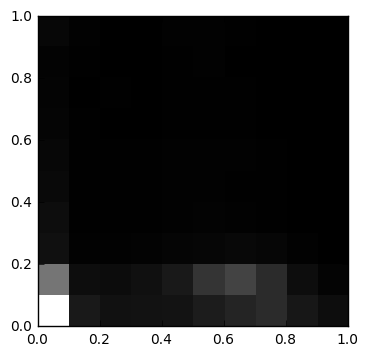

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0  11721.0  5375.0  769.0  598.0  431.0  326.0  267.0  206.0  156.0  366.0
1   1159.0   597.0  104.0   89.0   59.0   54.0   56.0   45.0   47.0   93.0
2    816.0   576.0   97.0   91.0   47.0   47.0   41.0   50.0   24.0   42.0
3    853.0   733.0  151.0   88.0   77.0   59.0   42.0   29.0   33.0   16.0
4    897.0  1186.0  253.0  127.0  111.0  101.0   70.0   72.0   72.0   97.0
5   1321.0  2391.0  303.0  183.0  116.0   96.0   63.0   58.0  110.0   96.0
6   1710.0  3110.0  367.0  136.0   84.0   96.0   85.0   49.0   33.0   55.0
7   1976.0  2009.0  287.0   81.0   70.0   54.0   38.0   35.0   28.0   42.0
8   1056.0   596.0  111.0   29.0   24.0   19.0   23.0   17.0    9.0   22.0
9    632.0   198.0   41.0   14.0    7.0    2.0    2.0    0.0    0.0    0.0
(10, 10)


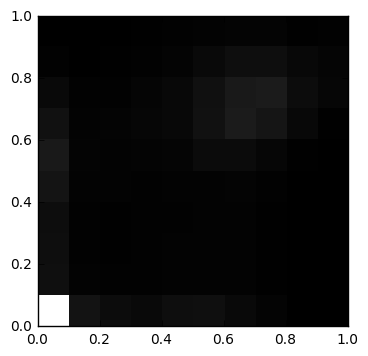

(10, 10)
         0      1      2      3       4       5       6       7      8      9
0  13813.0  851.0  783.0  726.0  1092.0  1395.0   925.0   492.0  125.0   13.0
1   1040.0  204.0  160.0  130.0   165.0   252.0   206.0   113.0   33.0    0.0
2    666.0  140.0  102.0   78.0   194.0   191.0   218.0   134.0   95.0   13.0
3    535.0  126.0  126.0  124.0   145.0   240.0   331.0   271.0  125.0   58.0
4    774.0  165.0  176.0  157.0   190.0   277.0   446.0   443.0  220.0  138.0
5    825.0  209.0  165.0  196.0   199.0   603.0   938.0   886.0  527.0  189.0
6    524.0  196.0  167.0  164.0   234.0   600.0  1492.0  1368.0  756.0  224.0
7    220.0   79.0  103.0   80.0   124.0   364.0  1161.0  1468.0  798.0  223.0
8     14.0   12.0   31.0   12.0    33.0    91.0   443.0   701.0  462.0  107.0
9      9.0    0.0    0.0    2.0     7.0    23.0    78.0   332.0  292.0  153.0
(10, 10)


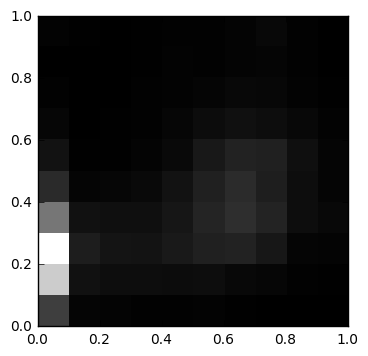

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1777.0  5777.0  7227.0  3347.0  1196.0  510.0  177.0   70.0   27.0  107.0
1   168.0   492.0   821.0   499.0   169.0   47.0   20.0   27.0   19.0   41.0
2   132.0   367.0   577.0   428.0   187.0   44.0   39.0   14.0   17.0   26.0
3    80.0   373.0   562.0   450.0   275.0  135.0   65.0   65.0   30.0   46.0
4    72.0   353.0   716.0   623.0   526.0  265.0  174.0  104.0   90.0   63.0
5    94.0   374.0   940.0  1021.0   933.0  694.0  359.0  166.0   76.0   80.0
6    37.0   246.0   968.0  1307.0  1227.0  986.0  462.0  243.0  128.0  121.0
7    16.0   181.0   659.0  1001.0   868.0  929.0  379.0  199.0  147.0  241.0
8     4.0    60.0   168.0   370.0   381.0  451.0  237.0   97.0   66.0   72.0
9     0.0    44.0   114.0   243.0   168.0  142.0  110.0   35.0   23.0   17.0
(10, 10)


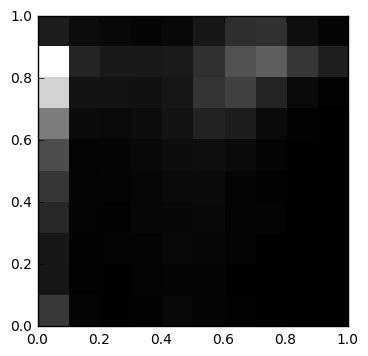

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1300.0  502.0  523.0  884.0  1230.0  1740.0  2839.0  4749.0  5776.0   672.0
1    95.0   58.0   66.0   77.0    81.0   107.0   249.0   430.0   855.0   285.0
2    28.0   45.0   70.0   57.0    93.0   135.0   212.0   420.0   580.0   191.0
3    52.0   69.0   80.0  152.0   140.0   185.0   286.0   401.0   582.0   134.0
4   203.0  107.0  203.0  177.0   225.0   310.0   449.0   516.0   594.0   202.0
5   125.0  113.0  168.0  199.0   244.0   322.0   778.0  1175.0  1092.0   521.0
6    65.0   41.0   82.0  105.0   135.0   263.0   668.0  1457.0  1856.0  1053.0
7    25.0   26.0   33.0   74.0    63.0   102.0   232.0   837.0  2127.0  1101.0
8     0.0    9.0   17.0    9.0    19.0    27.0    55.0   209.0  1234.0   327.0
9     0.0    0.0    0.0    0.0     0.0     1.0     8.0    64.0   707.0   116.0
(10, 10)


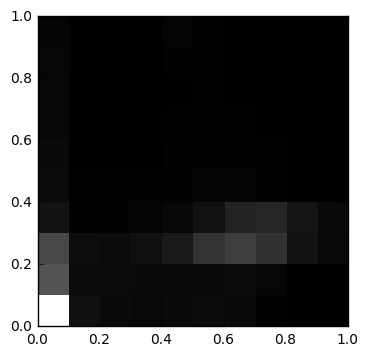

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  10806.0  3527.0  3019.0   812.0  493.0  464.0  335.0  257.0  285.0  217.0
1    686.0   496.0   588.0   137.0  108.0   50.0   51.0   37.0   69.0   81.0
2    427.0   487.0   489.0   129.0   89.0   63.0   26.0   35.0   49.0   37.0
3    362.0   451.0   689.0   208.0  129.0   75.0   59.0   33.0   31.0   44.0
4    441.0   389.0  1087.0   318.0  150.0  141.0   98.0   61.0  101.0  200.0
5    534.0   412.0  2174.0   734.0  245.0  145.0  102.0  104.0  119.0  168.0
6    445.0   470.0  2624.0  1502.0  245.0  133.0  107.0   83.0   54.0   62.0
7    167.0   266.0  2145.0  1638.0  154.0  102.0   54.0   44.0   15.0   35.0
8      6.0    28.0   795.0   914.0   63.0   33.0   23.0   17.0   10.0   17.0
9      4.0     5.0   369.0   460.0   46.0   12.0    0.0    0.0    0.0    0.0
(10, 10)


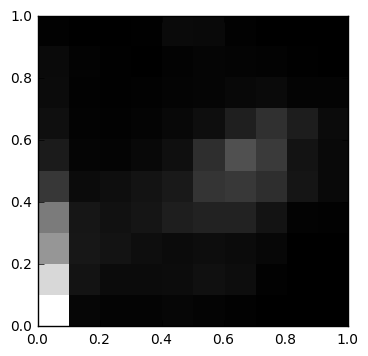

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  5958.0  5037.0  3492.0  2864.0  1302.0   636.0   365.0  274.0  233.0   54.0
1   150.0   443.0   551.0   525.0   265.0   128.0    89.0   59.0   75.0   18.0
2   116.0   272.0   456.0   398.0   332.0   104.0    63.0   44.0   41.0    5.0
3   105.0   263.0   332.0   498.0   447.0   207.0   113.0   65.0   22.0   29.0
4   161.0   283.0   267.0   699.0   588.0   366.0   189.0  107.0   77.0  249.0
5    99.0   384.0   317.0   799.0  1239.0  1089.0   337.0  128.0  118.0  227.0
6    58.0   306.0   262.0   795.0  1338.0  1871.0   723.0  193.0  112.0   67.0
7    16.0    67.0   167.0   452.0  1077.0  1358.0  1127.0  245.0   89.0   22.0
8     0.0     0.0    18.0    84.0   504.0   461.0   678.0  115.0   35.0   11.0
9     0.0     0.0     9.0    62.0   214.0   213.0   267.0  111.0   20.0    0.0
(10, 10)


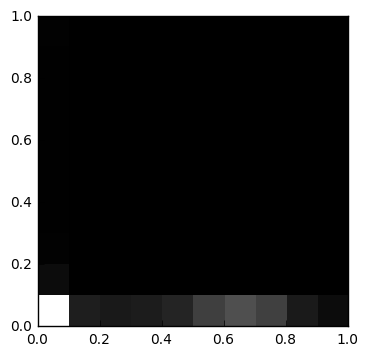

(10, 10)
         0      1      2      3     4     5     6      7     8      9
0  18348.0  930.0  209.0  118.0  75.0  82.0  76.0  101.0  99.0  177.0
1   2200.0    8.0    2.0    2.0  12.0   2.0   4.0    9.0   8.0   56.0
2   1796.0    8.0    3.0    4.0   0.0   0.0   0.0    4.0   4.0   12.0
3   2009.0   13.0   11.0    4.0   5.0   6.0  15.0    8.0   4.0    6.0
4   2609.0   59.0   56.0   35.0  23.0  53.0  37.0   27.0  18.0   69.0
5   4537.0   35.0   24.0   22.0  22.0  27.0  14.0   16.0   9.0   31.0
6   5664.0   14.0   18.0    9.0  16.0   4.0   0.0    0.0   0.0    0.0
7   4614.0    4.0    0.0    2.0   0.0   0.0   0.0    0.0   0.0    0.0
8   1906.0    0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0    0.0
9    896.0    0.0    0.0    0.0   0.0   0.0   0.0    0.0   0.0    0.0
(10, 10)


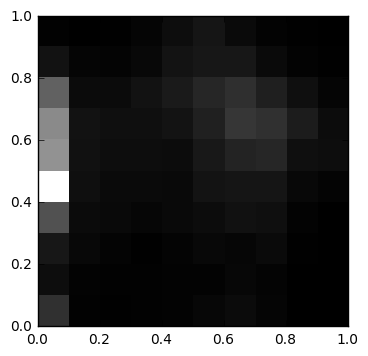

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1206.0  335.0  569.0  2003.0  6243.0  3561.0  3380.0  2403.0  462.0   53.0
1    50.0   86.0  201.0   272.0   381.0   418.0   460.0   291.0  125.0   19.0
2    27.0   52.0  102.0   228.0   256.0   338.0   386.0   292.0  109.0   41.0
3    49.0   55.0   44.0   153.0   265.0   325.0   390.0   450.0  215.0  135.0
4    87.0   80.0  107.0   237.0   237.0   301.0   479.0   654.0  483.0  321.0
5   188.0   83.0  212.0   308.0   483.0   609.0   821.0   929.0  585.0  519.0
6   269.0  175.0  167.0   416.0   523.0   872.0  1326.0  1149.0  566.0  262.0
7   124.0  104.0  255.0   373.0   517.0   931.0  1207.0   778.0  257.0   74.0
8     0.0    8.0   48.0    77.0   214.0   375.0   690.0   374.0   92.0   28.0
9     0.0    0.0    0.0     0.0    98.0   332.0   295.0   126.0   45.0    0.0
(10, 10)


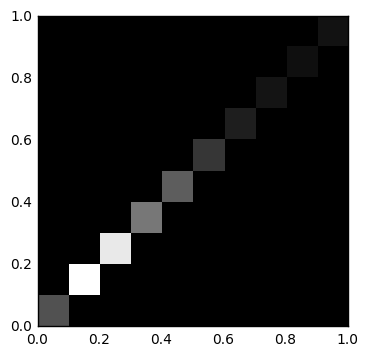

(10, 10)
        0        1        2       3       4       5       6       7      8  \
0  4199.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1     0.0  13126.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2     0.0      0.0  11951.0     0.0     0.0     0.0     0.0     0.0    0.0   
3     0.0      0.0      0.0  6102.0     0.0     0.0     0.0     0.0    0.0   
4     0.0      0.0      0.0     0.0  4779.0     0.0     0.0     0.0    0.0   
5     0.0      0.0      0.0     0.0     0.0  2805.0     0.0     0.0    0.0   
6     0.0      0.0      0.0     0.0     0.0     0.0  1578.0     0.0    0.0   
7     0.0      0.0      0.0     0.0     0.0     0.0     0.0  1028.0    0.0   
8     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0  786.0   
9     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  946.0  
(10, 10)


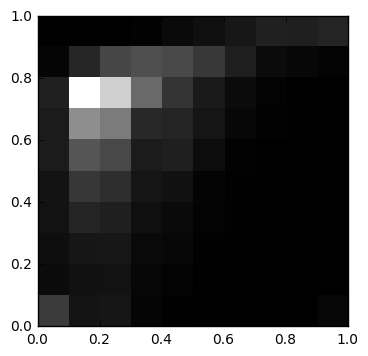

(10, 10)
        0      1      2      3       4       5       6       7       8      9
0  1149.0  215.0  278.0  354.0   386.0   534.0   537.0   642.0   104.0    0.0
1   395.0  343.0  443.0  712.0  1078.0  1654.0  2766.0  4977.0   758.0    0.0
2   430.0  354.0  449.0  613.0   901.0  1412.0  2394.0  4037.0  1361.0    0.0
3   111.0  134.0  178.0  311.0   411.0   532.0   793.0  2053.0  1539.0   40.0
4    27.0   66.0  140.0  208.0   344.0   622.0   717.0  1016.0  1444.0  195.0
5     9.0   14.0   36.0   69.0    91.0   249.0   418.0   521.0  1105.0  293.0
6    14.0    9.0   16.0   32.0    33.0    51.0   137.0   222.0   612.0  452.0
7     6.0    0.0    9.0    4.0    12.0    19.0    46.0    69.0   233.0  630.0
8     4.0    0.0    2.0    2.0     2.0     3.0     1.0    18.0   146.0  608.0
9   118.0   12.0    0.0    2.0     0.0     2.0     6.0    12.0    60.0  734.0
(10, 10)


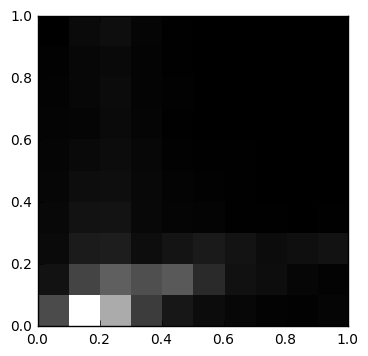

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  2304.0   582.0  328.0  257.0  205.0  162.0  135.0  120.0   88.0   18.0
1  7864.0  2117.0  848.0  580.0  427.0  304.0  182.0  243.0  244.0  317.0
2  5278.0  2929.0  909.0  585.0  433.0  375.0  321.0  365.0  304.0  452.0
3  1870.0  2456.0  424.0  248.0  266.0  235.0  173.0  134.0  131.0  165.0
4   721.0  2787.0  640.0  172.0  145.0   90.0   61.0   65.0   38.0   60.0
5   398.0  1298.0  815.0  125.0   78.0   32.0   23.0   14.0   14.0    8.0
6   234.0   544.0  612.0   52.0   46.0   35.0   26.0   24.0    3.0    2.0
7   107.0   406.0  377.0   55.0   24.0   27.0   28.0    4.0    0.0    0.0
8    85.0   192.0  475.0   23.0    0.0    5.0    6.0    0.0    0.0    0.0
9   171.0   121.0  573.0   58.0   11.0    3.0    7.0    2.0    0.0    0.0
(10, 10)


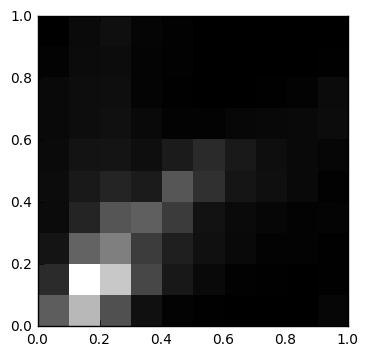

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1835.0   849.0   399.0   222.0   251.0  203.0  179.0  186.0   67.0    8.0
1  3619.0  5015.0  1948.0   710.0   499.0  374.0  259.0  267.0  233.0  202.0
2  1578.0  3927.0  2489.0  1684.0   715.0  399.0  326.0  285.0  251.0  297.0
3   332.0  1395.0  1201.0  1868.0   546.0  279.0  194.0   79.0   91.0  117.0
4    75.0   485.0   615.0  1173.0  1688.0  544.0   60.0   32.0   55.0   52.0
5    27.0   191.0   318.0   370.0   963.0  837.0   64.0    9.0   10.0   16.0
6    19.0    58.0   187.0   215.0   413.0  494.0  154.0   14.0    9.0   15.0
7    13.0    31.0    69.0   131.0   301.0  278.0  157.0   38.0    8.0    2.0
8     8.0    18.0    61.0    74.0   178.0  180.0  186.0   78.0    3.0    0.0
9   118.0    21.0    38.0    88.0    54.0  119.0  251.0  217.0   31.0    9.0
(10, 10)


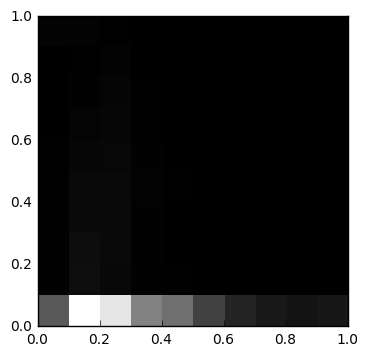

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0   3644.0  101.0   86.0   78.0   44.0   41.0   31.0   22.0   18.0  134.0
1  10439.0  576.0  542.0  431.0  375.0  279.0  180.0   86.0   65.0  153.0
2   9416.0  348.0  380.0  415.0  390.0  312.0  281.0  207.0  130.0   72.0
3   5305.0  111.0  103.0  112.0  142.0  120.0   75.0   80.0   35.0   19.0
4   4527.0   59.0   37.0   39.0   47.0   26.0   16.0   10.0   12.0    6.0
5   2720.0   20.0   19.0   21.0   17.0    8.0    0.0    0.0    0.0    0.0
6   1521.0   24.0   20.0    9.0    0.0    2.0    2.0    0.0    0.0    0.0
7   1018.0    2.0    6.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0
8    784.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    942.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


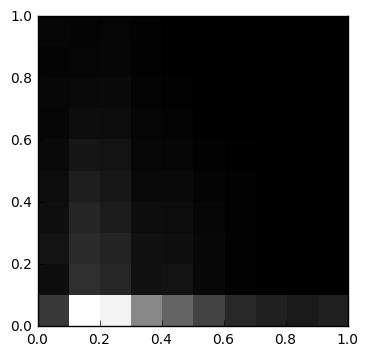

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1569.0   369.0   554.0   435.0  341.0  257.0  192.0  199.0  114.0  169.0
1  7136.0  1320.0  1206.0  1072.0  850.0  620.0  389.0  274.0  146.0  113.0
2  6810.0  1114.0  1023.0   797.0  653.0  551.0  357.0  306.0  186.0  154.0
3  3803.0   482.0   452.0   384.0  277.0  215.0  164.0  125.0   96.0  104.0
4  2788.0   548.0   434.0   345.0  251.0  159.0  119.0   76.0   30.0   29.0
5  1888.0   223.0   224.0   192.0  114.0  100.0   37.0   19.0    4.0    4.0
6  1163.0    67.0    81.0   109.0   83.0   48.0   16.0    7.0    2.0    2.0
7   909.0    35.0    18.0    10.0   18.0   25.0    7.0    6.0    0.0    0.0
8   752.0    17.0    14.0     3.0    0.0    0.0    0.0    0.0    0.0    0.0
9   942.0     0.0     2.0     0.0    2.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


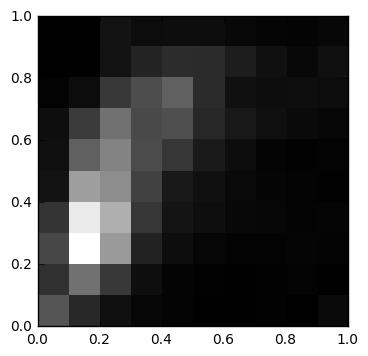

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  1155.0   654.0   961.0   721.0   258.0   204.0   194.0    52.0    0.0   
1   558.0  1541.0  3442.0  3147.0  2136.0  1302.0   800.0   166.0   24.0   
2   223.0   773.0  2081.0  2357.0  1896.0  1784.0  1546.0   779.0  252.0   
3    89.0   201.0   460.0   736.0   900.0  1009.0  1004.0  1047.0  482.0   
4    49.0    57.0   187.0   269.0   337.0   731.0  1065.0  1297.0  599.0   
5    21.0    30.0    92.0   196.0   225.0   359.0   533.0   583.0  582.0   
6    24.0    17.0    54.0   113.0   125.0   187.0   329.0   219.0  399.0   
7    31.0    29.0    52.0    89.0    75.0    61.0   209.0   179.0  226.0   
8    12.0    41.0    73.0    63.0    45.0    40.0   136.0   200.0  115.0   
9   146.0    12.0    58.0    75.0    35.0    46.0    83.0   169.0  220.0   

       9  
0    0.0  
1   10.0  
2  260.0  
3  174.0  
4  188.0  
5  184.0  
6  111.0  
7   77.0  
8   61.0  
9  102.0  
(10, 10)


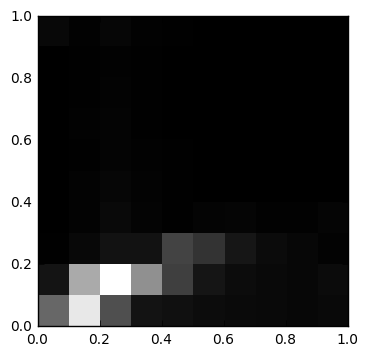

(10, 10)
        0       1       2      3      4      5      6     7     8      9
0  3179.0   636.0    48.0   30.0   12.0   16.0    0.0   0.0   8.0  270.0
1  7131.0  5233.0   248.0  116.0   99.0   59.0   75.0  55.0  42.0   68.0
2  2425.0  7857.0   569.0  285.0  191.0  143.0  125.0  97.0  62.0  197.0
3   585.0  4427.0   563.0  136.0  105.0   79.0   47.0  49.0  42.0   69.0
4   494.0  1963.0  2079.0   47.0   51.0   37.0   30.0  29.0  12.0   37.0
5   396.0   651.0  1580.0  130.0   11.0    3.0    7.0   0.0  12.0   15.0
6   328.0   389.0   682.0  162.0    4.0    4.0    1.0   0.0   2.0    6.0
7   300.0   290.0   347.0   77.0   12.0    2.0    0.0   0.0   0.0    0.0
8   238.0   241.0   219.0   82.0    4.0    2.0    0.0   0.0   0.0    0.0
9   301.0   366.0    99.0  161.0   19.0    0.0    0.0   0.0   0.0    0.0
(10, 10)


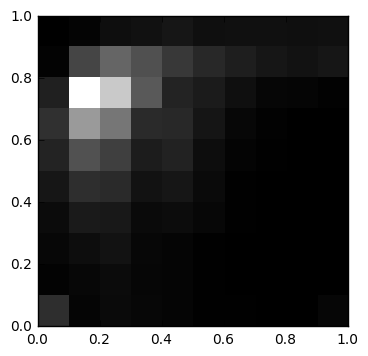

(10, 10)
       0      1      2      3      4       5       6       7       8      9
0  915.0   60.0  150.0  231.0  446.0   708.0   949.0   663.0    77.0    0.0
1  102.0  147.0  272.0  525.0  909.0  1600.0  3057.0  5049.0  1368.0   97.0
2  203.0  227.0  364.0  483.0  837.0  1246.0  2331.0  3976.0  2006.0  278.0
3  140.0  135.0  142.0  212.0  357.0   567.0   837.0  1781.0  1581.0  350.0
4  117.0  107.0  108.0  250.0  445.0   680.0   818.0   701.0  1118.0  435.0
5   24.0   20.0   35.0  151.0  201.0   270.0   430.0   537.0   822.0  315.0
6   23.0   12.0   13.0   20.0   31.0    87.0   157.0   307.0   611.0  317.0
7    9.0    3.0    8.0   12.0    8.0    31.0    57.0   123.0   444.0  333.0
8    4.0    4.0    0.0    2.0    0.0     2.0    13.0   104.0   361.0  296.0
9  120.0    3.0    0.0    0.0    4.0     3.0     2.0    53.0   444.0  317.0
(10, 10)


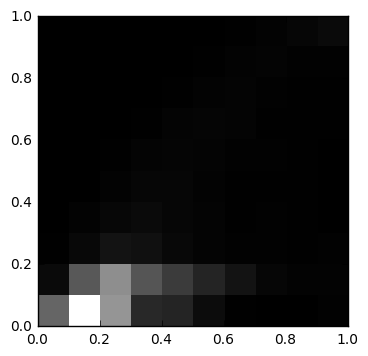

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  3740.0   392.0   49.0   16.0    0.0    2.0    0.0    0.0    0.0    0.0
1  9411.0  3269.0  295.0  113.0   28.0   10.0    0.0    0.0    0.0    0.0
2  5497.0  5243.0  716.0  294.0  138.0   55.0    8.0    0.0    0.0    0.0
3  1486.0  3159.0  595.0  375.0  252.0  163.0   52.0   18.0    2.0    0.0
4  1355.0  2169.0  321.0  252.0  242.0  209.0  157.0   60.0   14.0    0.0
5   463.0  1352.0  175.0  151.0  142.0  150.0  185.0  134.0   45.0    8.0
6    55.0   726.0  100.0   71.0   65.0   88.0  153.0  167.0  111.0   42.0
7    22.0   222.0  101.0   91.0   69.0   93.0   42.0   80.0  178.0  130.0
8     8.0   121.0   53.0   65.0   64.0   50.0   40.0   51.0   82.0  252.0
9   104.0   118.0   78.0    8.0   26.0   34.0   50.0   51.0   80.0  397.0
(10, 10)


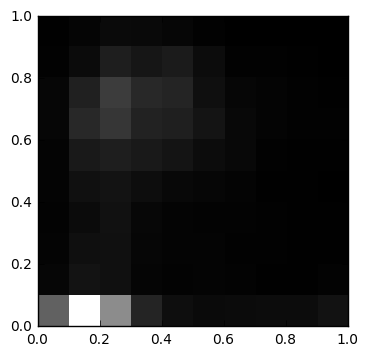

(10, 10)
        0      1      2      3      4      5       6       7      8      9
0  2969.0  187.0  138.0   98.0  143.0  144.0   201.0   191.0   69.0   59.0
1  7723.0  583.0  459.0  336.0  486.0  761.0  1264.0   979.0  361.0  174.0
2  4234.0  483.0  485.0  521.0  594.0  930.0  1631.0  1845.0  914.0  314.0
3  1092.0  180.0  197.0  216.0  417.0  774.0  1049.0  1224.0  681.0  272.0
4   432.0  117.0  145.0  124.0  269.0  622.0   950.0  1089.0  837.0  194.0
5   313.0  127.0  136.0  116.0  208.0  388.0   617.0   453.0  372.0   75.0
6   356.0  107.0   83.0   96.0  138.0  245.0   262.0   189.0   84.0   18.0
7   383.0   58.0   66.0   63.0   57.0   75.0   128.0   126.0   64.0    8.0
8   365.0   45.0   60.0   57.0   43.0   40.0    70.0    62.0   40.0    4.0
9   553.0   95.0   44.0   42.0   28.0   57.0    66.0    50.0   11.0    0.0
(10, 10)


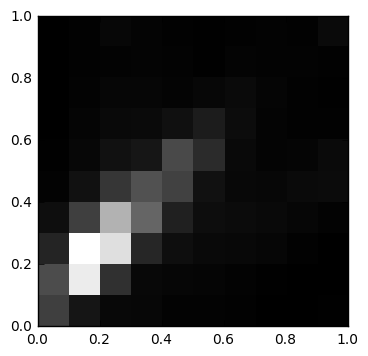

(10, 10)
        0       1       2       3       4       5      6      7     8      9
0  1354.0  1629.0   789.0   302.0    70.0    25.0   15.0    0.0   0.0   15.0
1   458.0  5046.0  5468.0  1347.0   365.0   153.0  118.0   75.0  48.0   48.0
2   185.0  1026.0  4784.0  3821.0  1156.0   377.0  210.0  143.0  84.0  165.0
3   150.0   185.0   831.0  2169.0  1742.0   488.0  223.0  130.0  97.0   87.0
4    76.0   130.0   305.0   705.0  1417.0  1565.0  363.0   91.0  70.0   57.0
5    66.0   111.0   208.0   281.0   373.0   939.0  603.0  155.0  41.0   28.0
6    46.0    83.0   172.0   241.0   190.0   208.0  269.0  223.0  89.0   57.0
7    15.0    38.0   137.0   204.0   157.0   103.0  101.0  118.0  76.0   79.0
8     6.0    19.0    47.0   146.0   215.0   121.0   61.0   53.0  66.0   52.0
9    24.0     0.0    11.0    73.0   245.0   224.0   59.0   32.0  52.0  226.0
(10, 10)


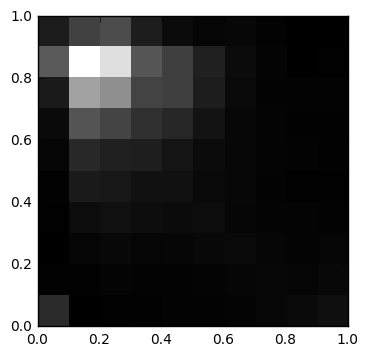

(10, 10)
       0      1      2      3      4      5       6       7       8       9
0  861.0   38.0    4.0   34.0   60.0  112.0   216.0   536.0  1781.0   557.0
1    6.0   39.0  108.0  242.0  525.0  816.0  1697.0  3247.0  5113.0  1333.0
2   39.0   93.0  169.0  331.0  464.0  626.0  1362.0  2858.0  4471.0  1538.0
3   54.0   71.0  110.0  263.0  351.0  611.0   986.0  1351.0  1720.0   585.0
4   77.0   64.0  126.0  225.0  334.0  413.0   770.0  1272.0  1263.0   235.0
5   78.0   96.0  179.0  242.0  195.0  233.0   392.0   598.0   678.0   114.0
6   94.0  122.0  199.0  137.0  143.0  149.0   157.0   185.0   239.0   153.0
7  145.0  161.0  126.0   92.0   77.0   95.0    95.0    73.0    95.0    69.0
8  218.0  109.0  101.0   88.0   41.0   81.0    53.0    63.0    16.0    16.0
9  321.0  177.0  120.0   80.0   40.0   56.0    48.0    75.0    27.0     2.0
(10, 10)


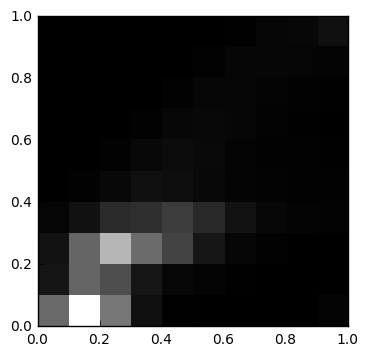

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  2923.0   599.0   510.0   153.0   14.0    0.0    0.0    0.0    0.0    0.0
1  7019.0  2789.0  2779.0   476.0   60.0    3.0    0.0    0.0    0.0    0.0
2  3282.0  2153.0  4992.0  1185.0  238.0   81.0   14.0    4.0    2.0    0.0
3   466.0   606.0  2954.0  1316.0  444.0  226.0   79.0    9.0    2.0    0.0
4    48.0   215.0  1841.0  1652.0  385.0  352.0  218.0   61.0    7.0    0.0
5     8.0   113.0   609.0  1112.0  224.0  265.0  220.0  167.0   70.0   17.0
6    12.0    50.0   169.0   504.0  134.0  113.0  179.0  188.0  183.0   46.0
7     4.0     2.0    81.0   217.0  103.0   71.0   84.0  119.0  184.0  163.0
8     4.0     0.0    21.0   128.0   59.0   68.0   51.0   82.0  155.0  218.0
9   112.0     4.0    23.0   109.0   61.0   39.0   10.0   41.0  130.0  417.0
(10, 10)


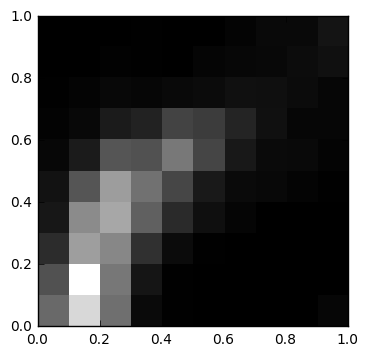

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1561.0  1193.0   646.0   341.0   277.0   103.0   55.0   19.0    4.0    0.0
1  3172.0  3748.0  2316.0  2038.0  1256.0   396.0  128.0   72.0    0.0    0.0
2  1635.0  1752.0  1989.0  2448.0  2304.0  1255.0  398.0  130.0   35.0    5.0
3   152.0   319.0   709.0  1412.0  1683.0  1191.0  502.0   90.0   28.0   16.0
4    27.0    27.0   171.0   627.0  1033.0  1760.0  985.0  135.0   14.0    0.0
5     8.0     4.0    26.0   224.0   380.0  1014.0  891.0  171.0   74.0   13.0
6    12.0     0.0     2.0    76.0   158.0   358.0  546.0  245.0  110.0   71.0
7     4.0     0.0     0.0     6.0   127.0   150.0  247.0  220.0  130.0  144.0
8     4.0     0.0     0.0     0.0    63.0   139.0  101.0  163.0  182.0  134.0
9    88.0    12.0    12.0     4.0    25.0    67.0   98.0   96.0  245.0  299.0
(10, 10)


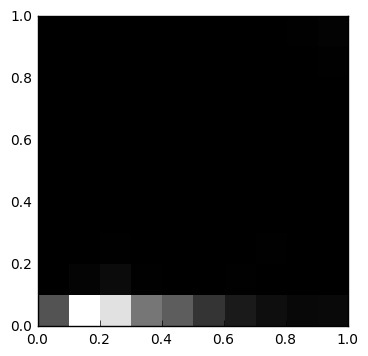

(10, 10)
         0      1     2     3     4     5     6     7     8      9
0   4181.0   14.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0
1  12822.0  248.0  44.0  12.0   0.0   0.0   0.0   0.0   0.0    0.0
2  11309.0  554.0  60.0  20.0   5.0   2.0   1.0   0.0   0.0    0.0
3   5914.0   67.0  34.0  28.0  21.0  12.0  10.0  12.0   4.0    0.0
4   4673.0   12.0  12.0  16.0   8.0  20.0   8.0  14.0   4.0   12.0
5   2679.0   27.0  17.0  15.0   7.0  10.0  19.0   8.0  10.0   13.0
6   1345.0   51.0  37.0  20.0  20.0  22.0  20.0  28.0  10.0   25.0
7    731.0   46.0  66.0  26.0  23.0  22.0  22.0  23.0  21.0   48.0
8    445.0   15.0  22.0  30.0  32.0  40.0  37.0  36.0  33.0   96.0
9    480.0   37.0  31.0  29.0  37.0  46.0  29.0  44.0  60.0  153.0
(10, 10)


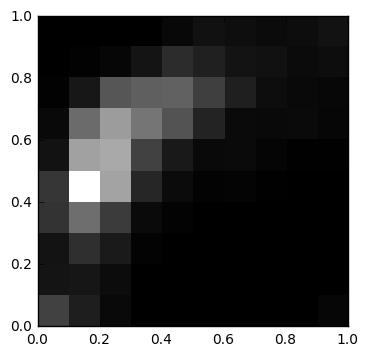

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1134.0  357.0  344.0   889.0   937.0   327.0   170.0    39.0    2.0    0.0
1   527.0  385.0  817.0  1899.0  4414.0  2776.0  1854.0   412.0   42.0    0.0
2   167.0  211.0  464.0  1031.0  2842.0  2921.0  2701.0  1492.0  117.0    5.0
3    12.0   16.0   67.0   179.0   669.0  1127.0  2022.0  1639.0  359.0   12.0
4    16.0    2.0    7.0    52.0   196.0   435.0  1438.0  1705.0  786.0  142.0
5     8.0    0.0    0.0    14.0    64.0   163.0   609.0  1089.0  561.0  297.0
6    12.0    0.0    2.0     0.0    69.0   185.0   177.0   544.0  339.0  250.0
7     4.0    0.0    0.0     0.0    25.0    90.0   168.0   236.0  303.0  202.0
8     4.0    0.0    0.0     0.0     1.0    19.0   179.0   156.0  196.0  231.0
9   116.0    7.0    4.0     3.0     0.0    19.0   116.0   134.0  234.0  313.0
(10, 10)


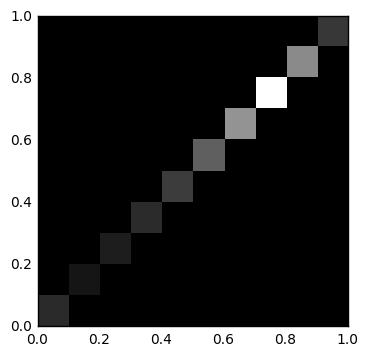

(10, 10)
        0       1       2       3       4       5       6        7       8  \
0  2263.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   
1     0.0  1147.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   
2     0.0     0.0  1551.0     0.0     0.0     0.0     0.0      0.0     0.0   
3     0.0     0.0     0.0  2307.0     0.0     0.0     0.0      0.0     0.0   
4     0.0     0.0     0.0     0.0  3258.0     0.0     0.0      0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0  5078.0     0.0      0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0  7815.0      0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0  13567.0     0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0  7362.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  2952.0  


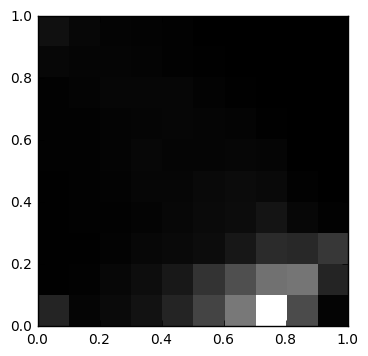

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  1101.0    53.0    45.0   49.0   58.0   88.0   68.0   84.0  229.0  488.0
1   170.0    83.0    53.0   62.0   90.0   69.0   76.0  145.0  175.0  224.0
2   310.0   217.0   112.0   71.0  101.0  141.0  125.0  187.0  162.0  125.0
3   556.0   393.0   236.0  127.0  183.0  221.0  160.0  193.0  129.0  109.0
4  1122.0   722.0   295.0  218.0  210.0  174.0  189.0  191.0   76.0   61.0
5  2065.0  1555.0   388.0  301.0  280.0  172.0  157.0  107.0   38.0   15.0
6  3624.0  2379.0   702.0  380.0  336.0  209.0  121.0   51.0   13.0    0.0
7  7685.0  3425.0  1295.0  629.0  288.0  180.0   54.0   11.0    0.0    0.0
8  2276.0  3522.0  1221.0  231.0   84.0   14.0   12.0    2.0    0.0    0.0
9   123.0  1083.0  1654.0   87.0    5.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


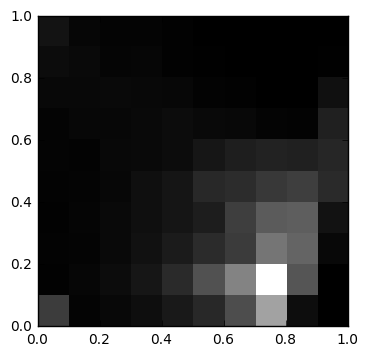

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1123.0    38.0    66.0    41.0    66.0   78.0   87.0  164.0  235.0  365.0
1    90.0   122.0    90.0   109.0    90.0   74.0  133.0  154.0  168.0  117.0
2   163.0   238.0   177.0   172.0   137.0  152.0  138.0  172.0  111.0   91.0
3   270.0   428.0   324.0   291.0   284.0  186.0  177.0  151.0  118.0   78.0
4   480.0   794.0   512.0   396.0   397.0  232.0  224.0  133.0   42.0   48.0
5   752.0  1516.0   818.0   544.0   756.0  411.0  169.0   69.0   34.0    9.0
6  1452.0  2469.0  1114.0  1162.0   845.0  572.0  153.0   38.0   10.0    0.0
7  3034.0  4777.0  2191.0  1713.0  1078.0  652.0   87.0   18.0   12.0    5.0
8   260.0  1595.0  1876.0  1761.0  1167.0  631.0   60.0    5.0    2.0    5.0
9     0.0    13.0   157.0   346.0   788.0  719.0  602.0  301.0   26.0    0.0
(10, 10)


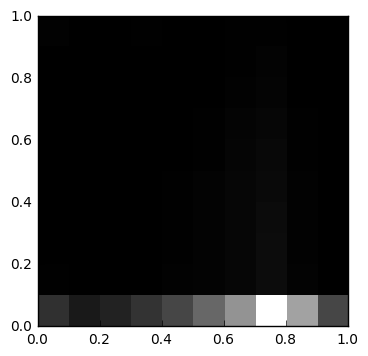

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0   1998.0   42.0   23.0   26.0   15.0   11.0   16.0    9.0    9.0  114.0
1   1051.0    5.0    8.0   12.0    9.0    8.0    8.0    8.0   12.0   26.0
2   1443.0   17.0   17.0    9.0   13.0    4.0    8.0    8.0    2.0   30.0
3   2129.0   37.0   40.0   22.0   10.0   11.0    6.0    2.0    2.0   48.0
4   2918.0   91.0   56.0   48.0   50.0   34.0   17.0   10.0   12.0   22.0
5   4287.0  154.0  154.0  132.0  135.0   77.0   50.0   39.0   26.0   24.0
6   6127.0  268.0  275.0  274.0  270.0  223.0  170.0  105.0   57.0   46.0
7  10647.0  504.0  506.0  493.0  396.0  365.0  266.0  199.0  127.0   64.0
8   6764.0  129.0  114.0   91.0  117.0   55.0   44.0   25.0   13.0   10.0
9   2952.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


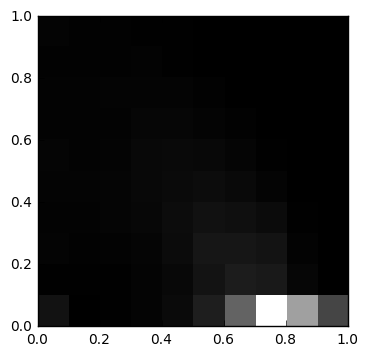

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0    802.0    72.0  170.0  153.0  181.0  236.0  158.0  164.0  124.0  203.0
1     40.0    48.0   94.0  154.0  172.0  147.0  142.0  146.0   96.0  108.0
2     63.0    73.0  147.0  242.0  253.0  203.0  163.0  185.0  107.0  115.0
3    205.0   186.0  216.0  320.0  365.0  348.0  255.0  197.0  135.0   80.0
4    467.0   350.0  493.0  541.0  462.0  385.0  258.0  172.0   78.0   52.0
5   1310.0   847.0  965.0  728.0  529.0  340.0  204.0  109.0   31.0   15.0
6   4236.0  1215.0  944.0  659.0  394.0  233.0   92.0   33.0    7.0    2.0
7  10875.0  1098.0  824.0  484.0  202.0   73.0    7.0    4.0    0.0    0.0
8   6817.0   279.0  155.0   66.0   31.0   10.0    2.0    2.0    0.0    0.0
9   2945.0     7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


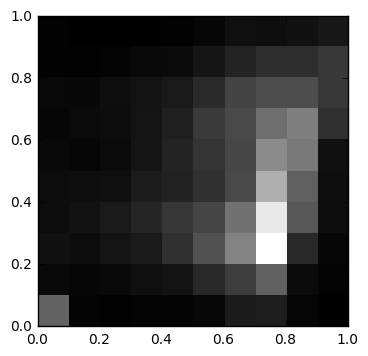

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1141.0   124.0   215.0   158.0   165.0   133.0    92.0  122.0   65.0   48.0
1    68.0    96.0   159.0   235.0   184.0    95.0   134.0  112.0   44.0   20.0
2    45.0   131.0   257.0   322.0   197.0   148.0   177.0  182.0   72.0   20.0
3    68.0   201.0   324.0   451.0   339.0   261.0   251.0  241.0  132.0   39.0
4    74.0   246.0   567.0   641.0   408.0   437.0   393.0  303.0  142.0   47.0
5   105.0   492.0   940.0   808.0   584.0   609.0   683.0  497.0  269.0   91.0
6   329.0   708.0  1501.0  1314.0   864.0   831.0   867.0  784.0  426.0  191.0
7   363.0  1136.0  2917.0  2654.0  2006.0  1593.0  1272.0  896.0  542.0  188.0
8    82.0   146.0   486.0  1014.0  1097.0  1410.0  1465.0  899.0  542.0  221.0
9    33.0    75.0    94.0   169.0   188.0   206.0   565.0  655.0  665.0  302.0
(10, 10)


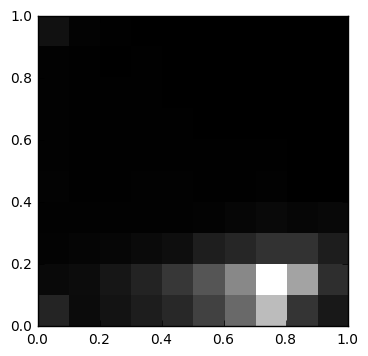

(10, 10)
        0       1       2      3     4     5     6     7     8      9
0  1001.0   252.0   101.0   54.0  82.0  70.0  80.0  76.0  66.0  481.0
1   317.0   322.0   149.0   67.0  52.0  39.0  38.0  51.0  31.0   81.0
2   508.0   603.0   181.0   55.0  37.0  41.0  32.0  29.0  24.0   41.0
3   776.0   960.0   268.0   63.0  66.0  42.0  49.0  32.0  27.0   24.0
4  1100.0  1486.0   395.0   71.0  74.0  35.0  39.0  23.0  18.0   17.0
5  1742.0  2297.0   826.0   83.0  44.0  48.0  13.0  12.0   4.0    9.0
6  2820.0  3657.0  1034.0  170.0  52.0  37.0  25.0   7.0   6.0    7.0
7  5028.0  6842.0  1337.0  251.0  65.0  29.0   9.0   0.0   4.0    2.0
8  1429.0  4378.0  1345.0  184.0  22.0   4.0   0.0   0.0   0.0    0.0
9   656.0  1256.0   798.0  228.0  14.0   0.0   0.0   0.0   0.0    0.0
(10, 10)


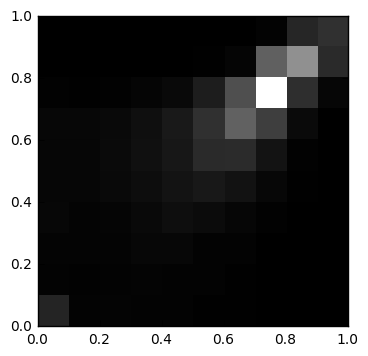

(10, 10)
        0      1      2      3      4       5       6       7       8       9
0  1103.0  109.0  125.0  216.0  203.0   190.0   215.0    84.0    18.0     0.0
1    98.0   85.0  143.0  136.0  189.0   208.0   220.0    49.0    17.0     2.0
2   149.0  106.0  145.0  161.0  287.0   329.0   286.0    86.0     2.0     0.0
3   100.0  144.0  219.0  287.0  410.0   486.0   479.0   174.0     8.0     0.0
4   103.0  109.0  228.0  443.0  587.0   698.0   778.0   299.0    13.0     0.0
5    59.0  110.0  110.0  351.0  732.0  1288.0  1503.0   886.0    39.0     0.0
6    38.0   39.0  111.0  195.0  568.0  1324.0  2972.0  2392.0   176.0     0.0
7     7.0   14.0   11.0   85.0  214.0   594.0  1884.0  7736.0  2912.0   110.0
8     0.0    2.0    0.0   12.0   48.0    70.0   303.0  1401.0  4359.0  1167.0
9     0.0    0.0    0.0    0.0    0.0     7.0    11.0   187.0  1288.0  1459.0
(10, 10)


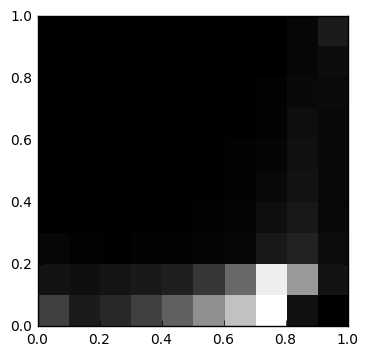

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  1571.0   488.0  171.0   11.0    7.0    6.0    6.0    0.0    3.0    0.0
1   683.0   382.0   72.0    4.0    4.0    0.0    2.0    0.0    0.0    0.0
2   990.0   506.0   46.0    6.0    1.0    2.0    0.0    0.0    0.0    0.0
3  1570.0   632.0   78.0   21.0    4.0    0.0    2.0    0.0    0.0    0.0
4  2370.0   762.0   81.0   25.0   16.0    4.0    0.0    0.0    0.0    0.0
5  3522.0  1339.0  100.0   72.0   31.0    8.0    6.0    0.0    0.0    0.0
6  4749.0  2566.0  195.0  138.0   91.0   52.0   20.0    4.0    0.0    0.0
7  6280.0  5840.0  600.0  357.0  212.0  140.0   78.0   55.0    5.0    0.0
8   400.0  3777.0  837.0  594.0  452.0  403.0  355.0  225.0  164.0  155.0
9     6.0   479.0  303.0  208.0  208.0  239.0  218.0  277.0  340.0  674.0
(10, 10)


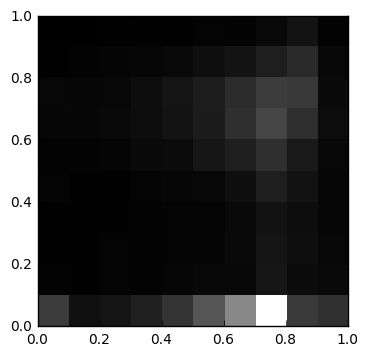

(10, 10)
        0      1      2      3      4       5       6       7       8      9
0  1476.0   93.0   60.0   68.0   98.0    75.0   161.0   186.0    44.0    2.0
1   391.0   72.0   63.0   62.0   65.0    82.0   149.0   158.0    92.0   13.0
2   500.0   98.0  103.0   59.0   67.0   138.0   241.0   185.0   134.0   26.0
3   812.0   89.0   93.0   87.0  108.0   262.0   333.0   325.0   146.0   52.0
4  1246.0  148.0   99.0  101.0  146.0   268.0   472.0   490.0   233.0   55.0
5  2041.0  209.0  133.0  110.0  182.0   539.0   689.0   707.0   369.0   99.0
6  3259.0  211.0  226.0  233.0  382.0   727.0  1135.0  1082.0   464.0   96.0
7  6129.0  546.0  503.0  450.0  730.0  1138.0  1655.0  1453.0   731.0  232.0
8  1414.0  279.0  339.0  333.0  449.0   602.0  1111.0  1360.0  1014.0  461.0
9  1152.0  237.0  194.0  166.0  156.0   205.0   292.0   262.0   206.0   82.0
(10, 10)


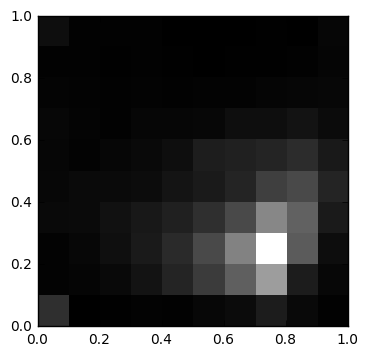

(10, 10)
       0       1       2       3       4      5      6      7      8      9
0  919.0    96.0    97.0   207.0   155.0  148.0  165.0  103.0   70.0  303.0
1   21.0   130.0   160.0   213.0   225.0   95.0   98.0   79.0   64.0   62.0
2   48.0   210.0   308.0   361.0   213.0  147.0   73.0   73.0   58.0   60.0
3   82.0   395.0   519.0   488.0   264.0  202.0  150.0   83.0   64.0   60.0
4   75.0   710.0   820.0   648.0   417.0  295.0  143.0   73.0   46.0   31.0
5  167.0  1154.0  1417.0   922.0   530.0  576.0  168.0   81.0   33.0   30.0
6  231.0  1834.0  2510.0  1411.0   722.0  644.0  294.0   88.0   46.0   35.0
7  557.0  3016.0  4890.0  2606.0  1232.0  734.0  298.0  128.0   50.0   56.0
8  208.0   566.0  1756.0  1900.0  1436.0  862.0  385.0  149.0   64.0   36.0
9   72.0   156.0   275.0   533.0   736.0  500.0  248.0  163.0  128.0  141.0
(10, 10)


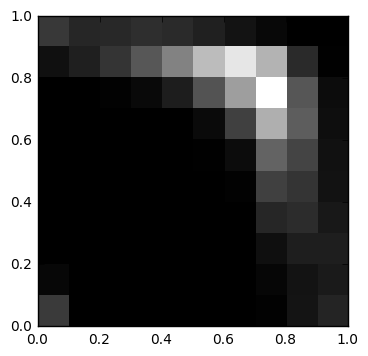

(10, 10)
       0      1      2      3       4       5       6       7       8      9
0  941.0  120.0   12.0    4.0     0.0     3.0     0.0     9.0   272.0  902.0
1    0.0    0.0    0.0    4.0     4.0     4.0     0.0     8.0   504.0  623.0
2    0.0    0.0    0.0    0.0     0.0     0.0     0.0    48.0   833.0  670.0
3    4.0    0.0    0.0    0.0     0.0     0.0     6.0   157.0  1400.0  740.0
4    0.0    0.0    0.0    0.0     0.0     2.0    14.0   472.0  2097.0  673.0
5    0.0    0.0    0.0    0.0     0.0    21.0   174.0  1338.0  3021.0  524.0
6    0.0    0.0    0.0    0.0    34.0   197.0  1033.0  2541.0  3696.0  314.0
7   35.0  106.0  244.0  622.0  1037.0  1597.0  2813.0  4099.0  2870.0  144.0
8  328.0  312.0  496.0  711.0   851.0  1091.0  1504.0  1378.0   679.0   12.0
9  585.0  432.0  490.0  393.0   304.0   277.0   232.0   208.0    31.0    0.0
(10, 10)


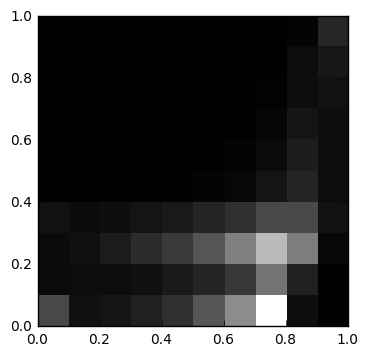

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1465.0   222.0   209.0   362.0    5.0    0.0    0.0    0.0    0.0    0.0
1   327.0   253.0   333.0   232.0    2.0    0.0    0.0    0.0    0.0    0.0
2   428.0   258.0   562.0   289.0   14.0    0.0    0.0    0.0    0.0    0.0
3   660.0   336.0   872.0   405.0   28.0    6.0    0.0    0.0    0.0    0.0
4   990.0   540.0  1178.0   506.0   23.0   17.0    4.0    0.0    0.0    0.0
5  1738.0   748.0  1737.0   747.0   84.0   12.0   10.0    2.0    0.0    0.0
6  2833.0  1137.0  2607.0   972.0  151.0   81.0   31.0    3.0    0.0    0.0
7  5172.0  2358.0  3776.0  1468.0  407.0  229.0  102.0   53.0    2.0    0.0
8   265.0   679.0  2539.0  1499.0  740.0  605.0  437.0  268.0  248.0   82.0
9     0.0     0.0   166.0   372.0  268.0  268.0  271.0  345.0  483.0  779.0
(10, 10)


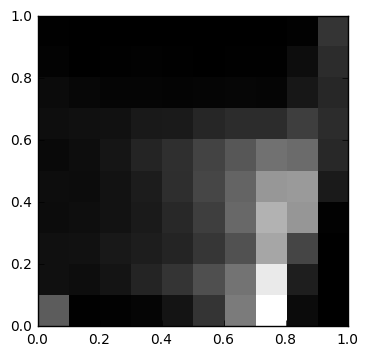

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1086.0   198.0   196.0   143.0   153.0   115.0  173.0  134.0   44.0   21.0
1    18.0   159.0   211.0   172.0   145.0   162.0  191.0   83.0    6.0    0.0
2    29.0   236.0   291.0   222.0   222.0   258.0  208.0   67.0   18.0    0.0
3    61.0   435.0   342.0   312.0   331.0   437.0  297.0   66.0   26.0    0.0
4   239.0   619.0   442.0   473.0   547.0   558.0  311.0   52.0   17.0    0.0
5   635.0   932.0   641.0   730.0   828.0   791.0  457.0   60.0    4.0    0.0
6  1447.0  1363.0   969.0  1227.0  1177.0  1024.0  523.0   73.0   12.0    0.0
7  3011.0  2753.0  1960.0  2098.0  1781.0  1350.0  540.0   62.0   12.0    0.0
8   137.0   360.0   819.0  1771.0  1816.0  1267.0  731.0  274.0  160.0   27.0
9     0.0     0.0     0.0    28.0   306.0   471.0  520.0  470.0  523.0  634.0
(10, 10)


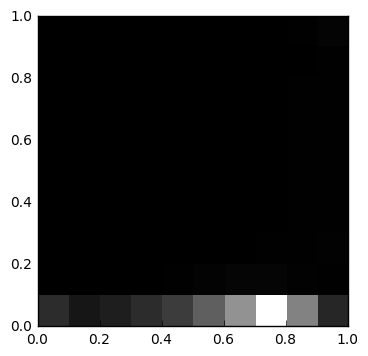

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0   2257.0    2.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0
1   1143.0    4.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
2   1543.0    8.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
3   2278.0   29.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
4   3171.0   85.0    2.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
5   4892.0  172.0   14.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
6   7498.0  279.0   32.0   6.0   0.0   0.0   0.0   0.0   0.0    0.0
7  13115.0  289.0   75.0  44.0  13.0  14.0   7.0   6.0   4.0    0.0
8   6700.0  106.0   95.0  82.0  53.0  61.0  62.0  64.0  47.0   92.0
9   1982.0   97.0  105.0  64.0  87.0  99.0  77.0  95.0  91.0  255.0
(10, 10)


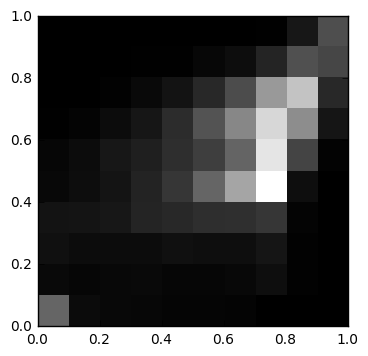

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1406.0  127.0  232.0  264.0   114.0    92.0    26.0     2.0     0.0     0.0
1   163.0   87.0  171.0  284.0   182.0   173.0    68.0     9.0    10.0     0.0
2   117.0  113.0  166.0  323.0   279.0   327.0   174.0    40.0    12.0     0.0
3    99.0  127.0  176.0  508.0   494.0   435.0   309.0   136.0    21.0     2.0
4    70.0   96.0  224.0  570.0   754.0   635.0   621.0   263.0    21.0     4.0
5    77.0   83.0  201.0  643.0  1397.0   857.0  1151.0   569.0    98.0     2.0
6    60.0  122.0  206.0  651.0  2275.0  1380.0  1869.0  1048.0   192.0    12.0
7     8.0  194.0  296.0  758.0  3529.0  3169.0  2966.0  2114.0   506.0    27.0
8     0.0   29.0   33.0   66.0   193.0   944.0  1956.0  2701.0  1114.0   326.0
9     0.0    0.0    0.0    0.0     0.0    50.0   294.0   564.0   965.0  1079.0
(10, 10)


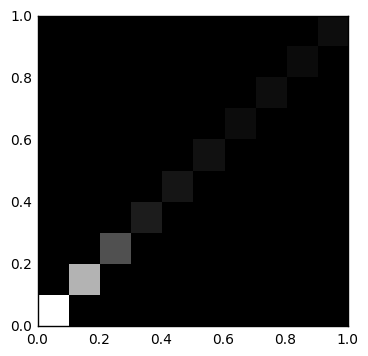

(10, 10)
         0        1       2       3       4       5      6      7      8  \
0  19032.0      0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
1      0.0  13432.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2      0.0      0.0  6001.0     0.0     0.0     0.0    0.0    0.0    0.0   
3      0.0      0.0     0.0  2155.0     0.0     0.0    0.0    0.0    0.0   
4      0.0      0.0     0.0     0.0  1635.0     0.0    0.0    0.0    0.0   
5      0.0      0.0     0.0     0.0     0.0  1268.0    0.0    0.0    0.0   
6      0.0      0.0     0.0     0.0     0.0     0.0  962.0    0.0    0.0   
7      0.0      0.0     0.0     0.0     0.0     0.0    0.0  971.0    0.0   
8      0.0      0.0     0.0     0.0     0.0     0.0    0.0    0.0  822.0   
9      0.0      0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  1022.0  
(10, 10)


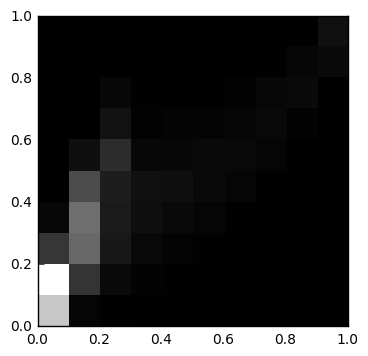

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  7332.0  9413.0  1997.0   286.0     4.0     0.0    0.0    0.0    0.0    0.0
1   184.0  1972.0  3841.0  4077.0  2772.0   576.0   10.0    0.0    0.0    0.0
2    64.0   373.0   891.0   969.0  1090.0  1667.0  665.0  269.0   13.0    0.0
3    30.0   138.0   360.0   585.0   591.0   270.0  106.0   55.0   20.0    0.0
4     6.0    69.0   162.0   349.0   553.0   315.0  157.0   22.0    2.0    0.0
5     8.0    23.0    60.0   214.0   366.0   338.0  170.0   66.0   18.0    5.0
6     0.0     2.0    14.0    51.0   185.0   342.0  225.0  109.0   25.0    9.0
7     0.0     0.0     0.0     4.0    47.0   185.0  365.0  279.0   61.0   30.0
8     0.0     0.0     0.0     0.0     0.0    14.0  132.0  373.0  245.0   58.0
9     0.0     0.0     0.0     0.0     0.0     0.0    0.0   32.0  374.0  616.0
(10, 10)


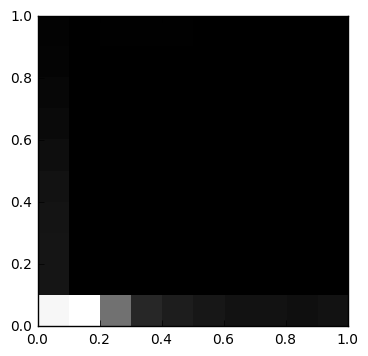

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  12802.0  1137.0  1090.0  1048.0  955.0  735.0  533.0  364.0  208.0  160.0
1  13237.0    44.0    38.0    18.0   25.0   18.0    5.0    8.0   17.0   22.0
2   5854.0    22.0    14.0     9.0   10.0   10.0    9.0    6.0   10.0   57.0
3   2034.0     9.0    18.0     1.0    1.0    4.0   12.0    4.0   12.0   60.0
4   1506.0     7.0    10.0     8.0    8.0   12.0   12.0   10.0    3.0   59.0
5   1210.0     0.0     6.0     6.0    3.0    4.0    8.0    6.0   10.0   15.0
6    934.0     4.0     2.0     7.0    2.0    0.0    4.0    4.0    0.0    5.0
7    961.0     0.0     4.0     2.0    0.0    0.0    0.0    0.0    0.0    4.0
8    805.0     4.0     0.0     0.0    6.0    4.0    1.0    0.0    0.0    2.0
9    973.0    20.0    11.0     8.0    5.0    1.0    1.0    3.0    0.0    0.0
(10, 10)


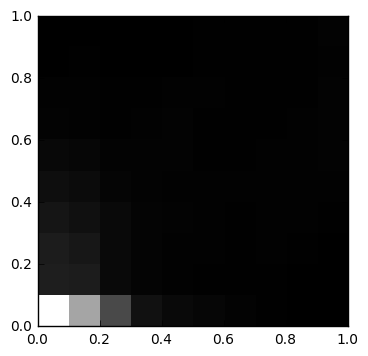

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  13286.0  1567.0  1498.0  1121.0  732.0  446.0  189.0  127.0   44.0   22.0
1   8579.0  1496.0  1223.0   862.0  584.0  327.0  150.0  116.0   52.0   43.0
2   3886.0   472.0   494.0   470.0  280.0  197.0   78.0   53.0   34.0   37.0
3    883.0   216.0   218.0   210.0  197.0  186.0  120.0   81.0   20.0   24.0
4    502.0   135.0   131.0   162.0  146.0  160.0  172.0  145.0   46.0   36.0
5    348.0    94.0   130.0   125.0  121.0  100.0   92.0  121.0   74.0   63.0
6    194.0   101.0   100.0    84.0  108.0   94.0   78.0   66.0   73.0   64.0
7     68.0    66.0   121.0   144.0  147.0  145.0   96.0   67.0   58.0   59.0
8     14.0    26.0    73.0   111.0  149.0  130.0  124.0   74.0   56.0   65.0
9      0.0     2.0    20.0    58.0  125.0  190.0  182.0  162.0  121.0  162.0
(10, 10)


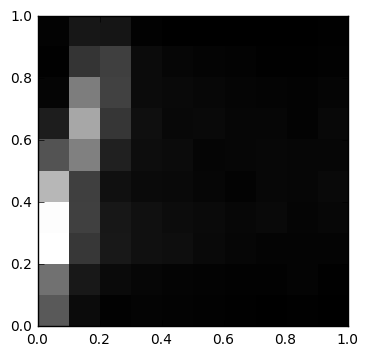

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  1676.0  2110.0  4759.0  4718.0  3410.0  1563.0   568.0   109.0    36.0   
1   228.0   469.0  1036.0  1206.0  1189.0  2398.0  3116.0  2346.0   988.0   
2    59.0   214.0   465.0   445.0   326.0   614.0  1032.0  1254.0  1185.0   
3    91.0   136.0   321.0   311.0   211.0   258.0   297.0   229.0   232.0   
4    70.0    94.0   278.0   247.0   194.0   218.0   178.0   192.0   132.0   
5    61.0    87.0   191.0   211.0   131.0   123.0   185.0   156.0   100.0   
6    41.0    65.0   129.0   159.0    85.0   127.0   131.0   123.0    87.0   
7    24.0    55.0    96.0   191.0   158.0   144.0   138.0    97.0    44.0   
8    44.0    90.0    90.0   118.0   130.0   141.0    87.0    72.0    34.0   
9    14.0    35.0    95.0   160.0   198.0   137.0   167.0   113.0    61.0   

       9  
0   83.0  
1  456.0  
2  407.0  
3   69.0  
4   32.0  
5   23.0  
6   15.0  
7   24.0  
8   16.0  
9   42.0  
(10, 10)


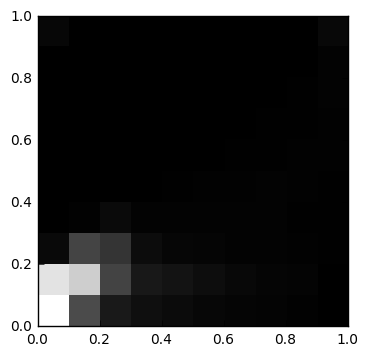

(10, 10)
        0       1       2      3      4     5      6      7      8      9
0  9734.0  8643.0   369.0    8.0    0.0   0.0    2.0    2.0    4.0  270.0
1  2868.0  7860.0  2617.0   85.0    1.0   1.0    0.0    0.0    0.0    0.0
2   964.0  2575.0  2050.0  395.0   13.0   0.0    0.0    0.0    4.0    0.0
3   595.0   950.0   471.0  127.0   12.0   0.0    0.0    0.0    0.0    0.0
4   439.0   756.0   260.0  122.0   42.0  14.0    2.0    0.0    0.0    0.0
5   276.0   530.0   218.0  121.0   84.0  28.0    8.0    1.0    2.0    0.0
6   196.0   329.0   137.0  124.0   81.0  50.0   26.0    4.0    8.0    7.0
7   182.0   217.0   138.0  126.0  115.0  72.0   67.0   25.0   12.0   17.0
8   106.0   159.0   102.0   66.0  100.0  98.0   72.0   58.0   35.0   26.0
9    17.0    34.0    72.0   52.0   60.0  82.0  108.0  140.0  115.0  342.0
(10, 10)


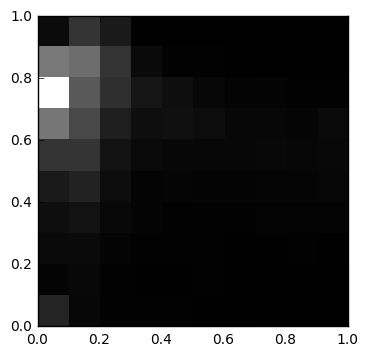

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1074.0  135.0  270.0  421.0   770.0  1515.0  3467.0  7508.0  3547.0   325.0
1   233.0  253.0  300.0  549.0  1014.0  1527.0  2127.0  2648.0  3198.0  1583.0
2    77.0   85.0  122.0  238.0   369.0   542.0   883.0  1394.0  1517.0   774.0
3    86.0   44.0   65.0  118.0   139.0   264.0   427.0   660.0   312.0    40.0
4    60.0   30.0   66.0   79.0   153.0   221.0   494.0   435.0    87.0    10.0
5    56.0   71.0   71.0   74.0   132.0   210.0   367.0   222.0    61.0     4.0
6    49.0   45.0   48.0   59.0   136.0   209.0   224.0   137.0    53.0     2.0
7    16.0   24.0   43.0  114.0   170.0   258.0   207.0   118.0    21.0     0.0
8     6.0   13.0   60.0  115.0   172.0   189.0   175.0    85.0     7.0     0.0
9     0.0   18.0   47.0  119.0   183.0   259.0   280.0    87.0    29.0     0.0
(10, 10)


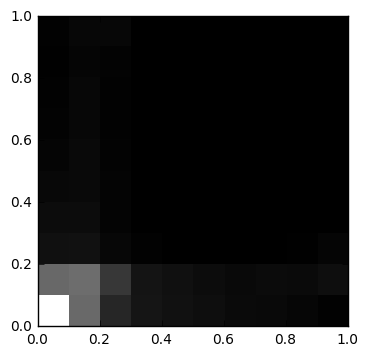

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0  11747.0  4806.0  771.0  570.0  404.0  243.0  166.0  107.0   89.0  129.0
1   4833.0  5030.0  812.0  590.0  424.0  427.0  367.0  327.0  266.0  356.0
2   1789.0  2564.0  349.0  213.0  184.0  168.0  137.0  113.0  146.0  338.0
3    982.0   961.0  129.0   33.0    6.0   14.0   11.0    6.0    7.0    6.0
4    818.0   763.0   23.0   15.0    8.0    2.0    4.0    2.0    0.0    0.0
5    677.0   562.0   23.0    3.0    0.0    0.0    2.0    1.0    0.0    0.0
6    485.0   435.0   30.0    5.0    0.0    0.0    0.0    5.0    2.0    0.0
7    419.0   512.0   36.0    2.0    0.0    0.0    0.0    0.0    2.0    0.0
8    285.0   483.0   51.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0
9    106.0   655.0  259.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


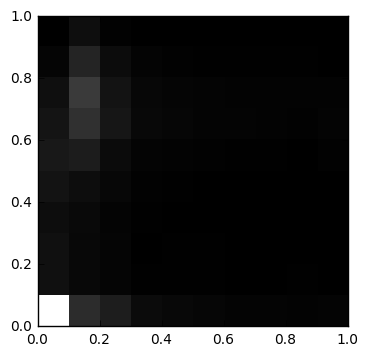

(10, 10)
         0      1      2      3      4       5       6       7       8      9
0  12525.0  818.0  809.0  654.0  944.0  1186.0  1015.0   768.0   262.0   51.0
1   2235.0  426.0  403.0  462.0  685.0  1407.0  2417.0  2888.0  1791.0  718.0
2   1454.0  264.0  267.0  244.0  375.0   570.0  1088.0   952.0   637.0  150.0
3    568.0   90.0   39.0   69.0  107.0   216.0   407.0   395.0   215.0   49.0
4    436.0  105.0   61.0   47.0   80.0   182.0   315.0   261.0   120.0   28.0
5    312.0   81.0   64.0   35.0   33.0   129.0   235.0   234.0   104.0   41.0
6    227.0   48.0   43.0   35.0   22.0    97.0   205.0   169.0    81.0   35.0
7    241.0   41.0   37.0   51.0   39.0    77.0   163.0   199.0    99.0   24.0
8    192.0   61.0   42.0   37.0   50.0    46.0   146.0   162.0    72.0   14.0
9    230.0   48.0   48.0   35.0   48.0   126.0   247.0   180.0    52.0    8.0
(10, 10)


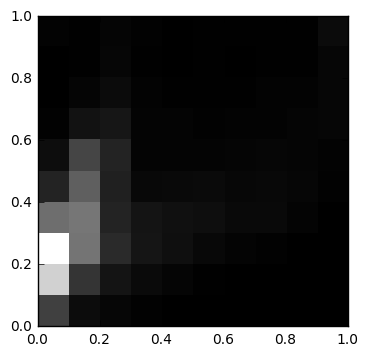

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1772.0  5733.0  6992.0  3024.0   959.0   377.0   79.0   14.0    0.0   82.0
1   332.0  1449.0  3170.0  3232.0  2620.0  1889.0  514.0  137.0   45.0   44.0
2   176.0   572.0  1157.0   963.0   908.0   972.0  603.0  319.0  175.0  156.0
3    60.0   278.0   590.0   564.0   221.0   130.0  118.0   84.0   41.0   69.0
4    19.0   147.0   416.0   464.0   270.0   126.0  115.0   32.0   26.0   20.0
5    19.0    53.0   226.0   394.0   274.0   125.0   78.0   36.0   33.0   30.0
6     2.0    27.0   133.0   265.0   199.0   152.0   99.0   31.0   23.0   31.0
7     0.0     8.0    56.0   258.0   235.0   168.0   85.0   84.0   37.0   40.0
8     0.0     0.0    12.0   117.0   180.0   163.0  158.0  102.0   54.0   36.0
9     0.0     0.0     0.0     8.0    64.0   101.0  173.0  181.0  189.0  306.0
(10, 10)


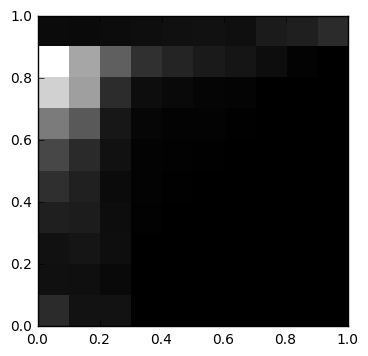

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1005.0  382.0  399.0  715.0  1091.0  1648.0  2831.0  4814.0  5884.0   263.0
1   418.0  355.0  497.0  644.0   753.0   967.0  2066.0  3655.0  3838.0   239.0
2   434.0  227.0  328.0  308.0   274.0   401.0   532.0  1019.0  2190.0   288.0
3    20.0    6.0   18.0   58.0    70.0    73.0   147.0   311.0  1108.0   344.0
4     4.0    0.0    0.0    9.0    34.0    61.0    79.0   213.0   866.0   369.0
5    12.0    0.0    0.0    0.0     8.0    40.0    83.0   125.0   608.0   392.0
6     0.0    0.0    0.0    0.0     0.0     2.0    32.0    97.0   484.0   347.0
7     0.0    0.0    0.0    0.0     0.0     0.0     6.0    20.0   318.0   627.0
8     0.0    0.0    0.0    0.0     0.0     0.0     0.0     4.0    90.0   728.0
9     0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0    17.0  1005.0
(10, 10)


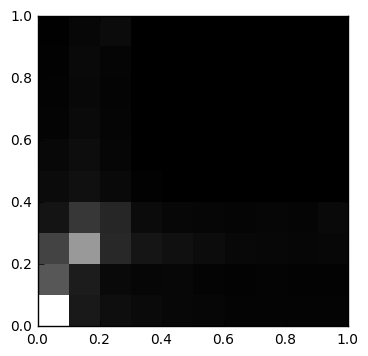

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  10498.0  3597.0  2748.0   821.0  486.0  344.0  200.0  148.0  117.0   73.0
1   1060.0  1155.0  6295.0  2272.0  660.0  556.0  428.0  331.0  379.0  296.0
2    582.0   388.0  1647.0  1593.0  400.0  286.0  209.0  184.0  230.0  482.0
3    414.0   269.0   880.0   457.0   86.0   12.0   12.0    8.0    7.0   10.0
4    322.0   301.0   677.0   298.0   27.0    6.0    4.0    0.0    0.0    0.0
5    259.0   199.0   505.0   282.0   16.0    7.0    0.0    0.0    0.0    0.0
6    174.0   156.0   359.0   225.0   41.0    7.0    0.0    0.0    0.0    0.0
7    201.0   170.0   305.0   287.0    6.0    0.0    2.0    0.0    0.0    0.0
8    175.0   149.0   268.0   230.0    0.0    0.0    0.0    0.0    0.0    0.0
9    193.0   147.0   295.0   387.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


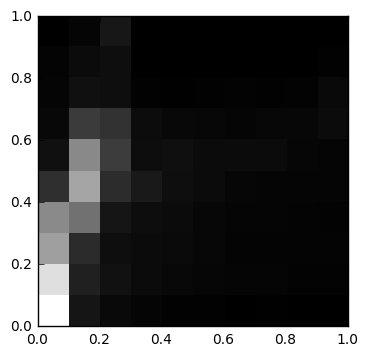

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  5658.0  4944.0  3528.0  3068.0  1040.0   373.0   188.0  114.0  109.0   10.0
1   478.0   747.0   962.0  2511.0  3647.0  3032.0  1321.0  367.0  248.0  119.0
2   210.0   388.0   320.0   468.0   987.0  1354.0  1112.0  321.0  326.0  515.0
3   120.0   261.0   248.0   302.0   568.0   290.0   283.0   57.0    9.0   17.0
4    66.0   183.0   237.0   254.0   322.0   353.0   181.0   29.0   10.0    0.0
5    50.0   146.0   164.0   175.0   254.0   255.0   162.0   55.0    7.0    0.0
6    22.0   123.0   107.0   114.0   133.0   252.0   124.0   69.0   18.0    0.0
7    28.0   116.0    99.0   111.0   129.0   250.0   164.0   53.0   21.0    0.0
8    20.0    71.0   100.0   104.0   115.0   151.0   169.0   72.0   20.0    0.0
9    11.0    76.0   106.0    69.0   111.0   123.0   247.0  204.0   54.0   21.0
(10, 10)


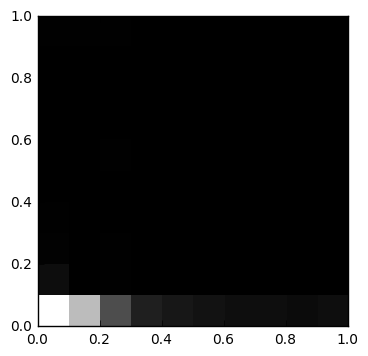

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0  17545.0  894.0  177.0  96.0  49.0  47.0  37.0  47.0  47.0   93.0
1  12924.0   63.0   55.0  30.0  40.0  39.0  45.0  65.0  56.0  115.0
2   5287.0  110.0   91.0  68.0  64.0  88.0  64.0  53.0  39.0  137.0
3   2143.0    4.0    0.0   2.0   0.0   0.0   0.0   0.0   0.0    6.0
4   1635.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
5   1268.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
6    962.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
7    971.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
8    822.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
9   1022.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
(10, 10)


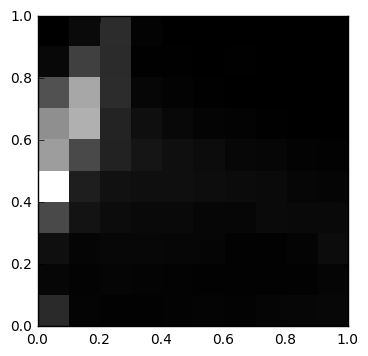

(10, 10)
        0      1      2       3       4       5       6       7       8  \
0  1034.0  160.0  381.0  1782.0  6183.0  3806.0  3473.0  1987.0   205.0   
1   101.0   83.0  136.0   475.0   733.0  1774.0  4272.0  4045.0  1560.0   
2    57.0  121.0  175.0   297.0   430.0   835.0   857.0  1096.0  1047.0   
3    72.0  116.0  175.0   241.0   369.0   517.0   378.0   161.0    44.0   
4    73.0   95.0  162.0   231.0   366.0   363.0   201.0    93.0    41.0   
5   101.0   70.0  143.0   168.0   319.0   301.0   113.0    39.0    14.0   
6    79.0   67.0   65.0   162.0   278.0   180.0    86.0    19.0    26.0   
7   141.0   59.0   70.0   251.0   250.0   149.0    43.0     6.0     2.0   
8   153.0   66.0  108.0   237.0   161.0    88.0     9.0     0.0     0.0   
9   189.0  141.0  290.0   223.0   128.0    49.0     2.0     0.0     0.0   

        9  
0    21.0  
1   253.0  
2  1086.0  
3    82.0  
4    10.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
(10, 10)


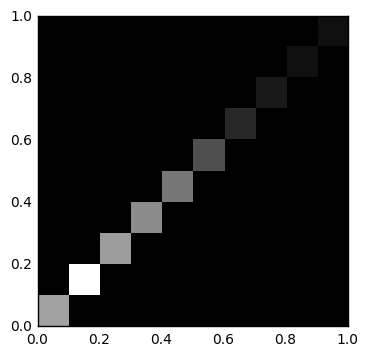

(10, 10)
        0        1       2       3       4       5       6       7      8  \
0  7624.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1     0.0  11990.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2     0.0      0.0  7325.0     0.0     0.0     0.0     0.0     0.0    0.0   
3     0.0      0.0     0.0  6535.0     0.0     0.0     0.0     0.0    0.0   
4     0.0      0.0     0.0     0.0  5608.0     0.0     0.0     0.0    0.0   
5     0.0      0.0     0.0     0.0     0.0  3707.0     0.0     0.0    0.0   
6     0.0      0.0     0.0     0.0     0.0     0.0  1830.0     0.0    0.0   
7     0.0      0.0     0.0     0.0     0.0     0.0     0.0  1205.0    0.0   
8     0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0  758.0   
9     0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  718.0  
(10, 10)


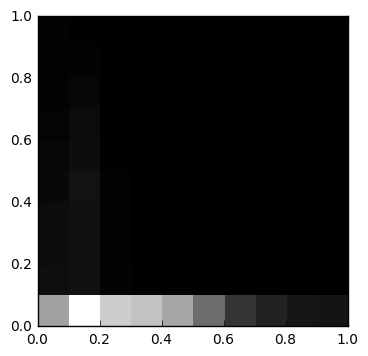

(10, 10)
        0      1      2      3      4      5      6      7      8      9
0  5347.0  484.0  445.0  398.0  265.0  257.0  144.0  105.0   73.0  106.0
1  8435.0  571.0  556.0  557.0  619.0  447.0  372.0  247.0  125.0   61.0
2  6765.0  103.0  117.0  103.0   94.0   45.0   25.0   18.0   27.0   28.0
3  6408.0   35.0   15.0   13.0    6.0   10.0    4.0    6.0   10.0   28.0
4  5498.0    7.0   19.0    4.0    2.0   10.0   10.0    2.0    4.0   52.0
5  3569.0   17.0   13.0    9.0    8.0    6.0   10.0    2.0    8.0   65.0
6  1744.0    4.0    7.0    6.0    6.0    6.0   10.0   18.0    7.0   22.0
7  1152.0    2.0    8.0    7.0    2.0    0.0    4.0    4.0    6.0   20.0
8   732.0    7.0    7.0    2.0    4.0    2.0    4.0    0.0    0.0    0.0
9   666.0   17.0    6.0    8.0    9.0    5.0    2.0    3.0    0.0    2.0
(10, 10)


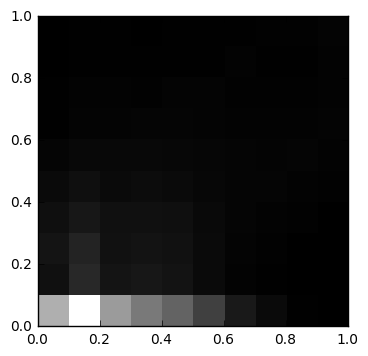

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  5361.0   495.0   619.0  491.0  327.0  181.0   58.0   46.0   23.0   23.0
1  7797.0  1262.0  1086.0  719.0  484.0  265.0  153.0  122.0   59.0   43.0
2  4729.0   633.0   549.0  509.0  327.0  259.0  138.0   96.0   40.0   45.0
3  3740.0   710.0   610.0  515.0  376.0  274.0  159.0   91.0   35.0   25.0
4  3030.0   592.0   550.0  475.0  338.0  243.0  168.0  136.0   40.0   36.0
5  1956.0   317.0   338.0  283.0  235.0  200.0  127.0  142.0   60.0   49.0
6   769.0   108.0   126.0  167.0  159.0  159.0  107.0   86.0  103.0   46.0
7   332.0    45.0    85.0  102.0  157.0  138.0  119.0   87.0   60.0   80.0
8    37.0     9.0    28.0   67.0  119.0  158.0  123.0   87.0   50.0   80.0
9     9.0     4.0    17.0   19.0   67.0   98.0  129.0  119.0  108.0  148.0
(10, 10)


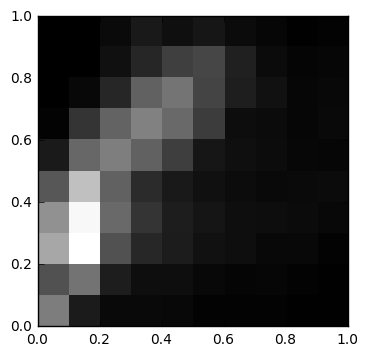

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  1498.0   985.0  2002.0  1738.0  1041.0   312.0    44.0     4.0    0.0   
1   331.0  1382.0  3052.0  2967.0  2298.0  1229.0   626.0   100.0    5.0   
2   115.0   355.0   971.0  1256.0  1158.0  1503.0  1187.0   462.0  192.0   
3   111.0   168.0   475.0   624.0   517.0  1166.0  1548.0  1160.0  457.0   
4    99.0   171.0   340.0   350.0   299.0   747.0  1273.0  1389.0  755.0   
5    38.0   100.0   205.0   262.0   192.0   263.0   720.0   818.0  838.0   
6    38.0    68.0   171.0   170.0   154.0   179.0   166.0   366.0  385.0   
7    38.0    75.0   105.0   156.0   116.0   152.0   139.0   214.0  134.0   
8    23.0    39.0   100.0   141.0   121.0    93.0    81.0    79.0   61.0   
9    17.0    12.0    39.0   102.0   136.0    79.0   115.0    99.0   72.0   

       9  
0    0.0  
1    0.0  
2  126.0  
3  309.0  
4  185.0  
5  271.0  
6  133.0  
7   76.0  
8   20.0  
9   47.0  
(10, 10)


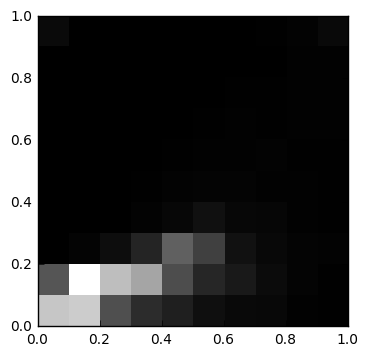

(10, 10)
        0       1       2      3      4     5     6     7     8      9
0  5120.0  2209.0     6.0   11.0    0.0   0.0   0.0   0.0   8.0  270.0
1  5282.0  6598.0   108.0    2.0    0.0   0.0   0.0   0.0   0.0    0.0
2  2040.0  4898.0   342.0   25.0    9.0   4.0   4.0   3.0   0.0    0.0
3  1144.0  4267.0   966.0   99.0   37.0  12.0   6.0   0.0   2.0    2.0
4   821.0  1985.0  2476.0  196.0   84.0  28.0   8.0   4.0   0.0    6.0
5   411.0   981.0  1674.0  417.0  119.0  61.0  30.0   7.0   4.0    3.0
6   256.0   656.0   442.0  195.0  107.0  64.0  59.0  27.0  20.0    4.0
7   215.0   302.0   220.0  169.0   69.0  81.0  51.0  45.0  24.0   29.0
8    61.0   107.0   118.0   77.0   55.0  49.0  71.0  68.0  61.0   91.0
9    27.0    50.0    82.0   35.0   28.0  46.0  56.0  76.0  61.0  257.0
(10, 10)


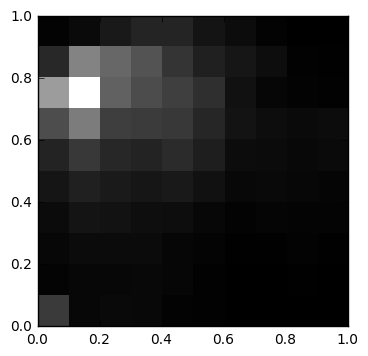

(10, 10)
        0      1      2      3      4       5       6       7       8      9
0  1075.0   74.0  130.0  204.0  386.0   656.0  1411.0  2858.0   758.0   72.0
1   130.0  131.0  212.0  367.0  594.0  1026.0  2271.0  4665.0  2404.0  190.0
2   167.0  135.0  209.0  331.0  480.0   713.0  1143.0  1797.0  1893.0  457.0
3   160.0  164.0  205.0  267.0  413.0   654.0  1081.0  1396.0  1529.0  666.0
4    57.0  124.0  112.0  249.0  465.0   788.0  1029.0  1155.0   951.0  678.0
5    46.0   47.0   85.0  144.0  322.0   552.0   695.0   857.0   587.0  372.0
6    10.0   11.0   30.0   67.0  161.0   231.0   363.0   322.0   405.0  230.0
7     6.0    5.0   33.0   95.0  181.0   214.0   239.0   122.0   239.0   71.0
8     2.0   23.0   55.0   84.0  132.0   164.0   183.0    72.0    41.0    2.0
9     4.0    4.0   21.0   78.0  104.0   196.0   236.0    50.0    25.0    0.0
(10, 10)


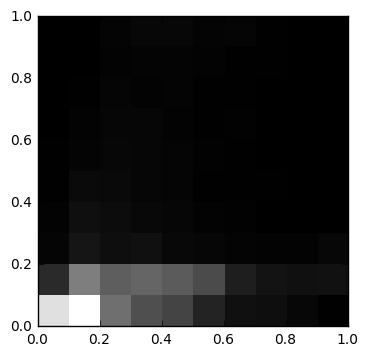

(10, 10)
        0       1      2      3      4      5      6      7      8      9
0  6085.0  1160.0  161.0   92.0   51.0   44.0   15.0   10.0    6.0    0.0
1  6953.0  3439.0  572.0  421.0  283.0  134.0   88.0   51.0   22.0   27.0
2  3018.0  2578.0  389.0  337.0  248.0  212.0  181.0  154.0   83.0  125.0
3  2149.0  2756.0  437.0  233.0  187.0  182.0  171.0  105.0  121.0  194.0
4  1874.0  2492.0  239.0  183.0  137.0  136.0  104.0  130.0  119.0  194.0
5   975.0  2048.0  189.0   82.0   46.0   63.0   53.0   47.0   84.0  120.0
6   449.0   841.0  120.0   69.0   32.0   50.0   56.0   31.0   44.0  138.0
7   381.0   542.0   96.0   16.0   42.0   27.0   14.0   27.0   29.0   31.0
8   204.0   451.0   88.0    3.0    0.0    6.0    5.0    1.0    0.0    0.0
9    53.0   464.0  192.0    0.0    0.0    0.0    0.0    5.0    4.0    0.0
(10, 10)


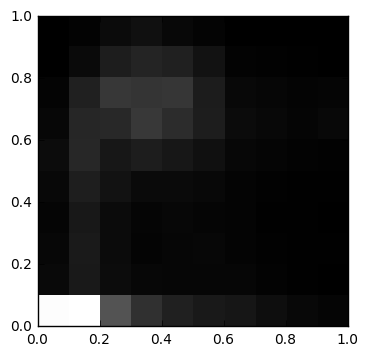

(10, 10)
        0      1      2      3      4      5       6       7      8      9
0  6221.0  232.0  179.0  145.0  207.0  302.0   199.0   110.0   25.0    4.0
1  6271.0  633.0  662.0  592.0  760.0  970.0   940.0   793.0  271.0   98.0
2  2047.0  302.0  296.0  275.0  450.0  569.0  1019.0  1357.0  727.0  283.0
3  1181.0  178.0  116.0  146.0  251.0  720.0  1379.0  1277.0  891.0  396.0
4   797.0  152.0  152.0  178.0  268.0  579.0  1111.0  1333.0  836.0  202.0
5   632.0  153.0  178.0  128.0  205.0  413.0   734.0   691.0  467.0  106.0
6   544.0  160.0  103.0  111.0  108.0  189.0   294.0   217.0   87.0   17.0
7   367.0   98.0   56.0   37.0   73.0  129.0   203.0   171.0   67.0    4.0
8   211.0   46.0   37.0   33.0   29.0   95.0   150.0   110.0   43.0    4.0
9   149.0   28.0   34.0   24.0   32.0   70.0   209.0   149.0   19.0    4.0
(10, 10)


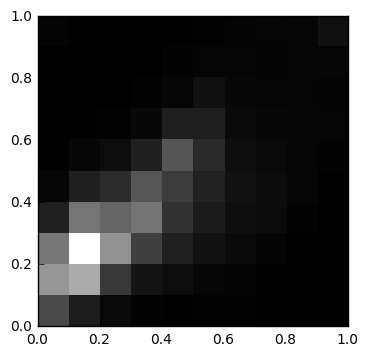

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1430.0  2926.0  2337.0   652.0   132.0    33.0    4.0   14.0    0.0   96.0
1   564.0  3339.0  4993.0  2284.0   616.0   143.0   34.0    3.0    2.0   12.0
2   185.0  1106.0  2847.0  1971.0   876.0   265.0   54.0   11.0    1.0    9.0
3    71.0   393.0  1264.0  2272.0  1696.0   606.0  161.0   40.0   19.0   13.0
4    26.0   255.0   649.0   986.0  1198.0  1662.0  595.0  132.0   74.0   31.0
5    54.0   124.0   366.0   532.0   677.0   855.0  596.0  342.0  106.0   55.0
6    40.0    85.0   208.0   298.0   368.0   277.0  200.0  168.0  107.0   79.0
7     6.0    39.0    84.0   226.0   226.0   190.0  146.0  106.0   79.0  103.0
8     0.0     0.0     4.0    64.0   118.0   112.0  130.0  115.0  113.0  102.0
9     4.0     0.0     0.0     4.0    23.0    60.0  102.0   89.0  122.0  314.0
(10, 10)


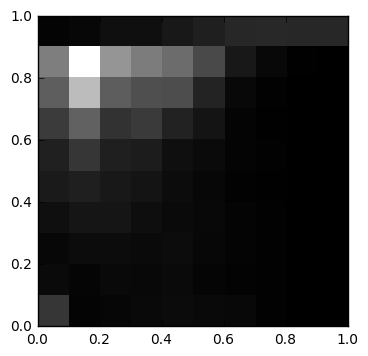

(10, 10)
       0      1      2      3      4      5       6       7       8      9
0  953.0  182.0  134.0  265.0  469.0  583.0  1044.0  1674.0  2234.0   86.0
1   80.0  103.0  216.0  381.0  559.0  954.0  1731.0  3316.0  4515.0  135.0
2  122.0  168.0  219.0  384.0  428.0  552.0   886.0  1654.0  2641.0  271.0
3  160.0  155.0  192.0  256.0  369.0  509.0  1025.0  1400.0  2188.0  281.0
4  209.0  177.0  227.0  191.0  212.0  273.0   606.0  1367.0  1907.0  439.0
5  173.0   94.0  125.0  142.0  128.0  184.0   364.0   633.0  1303.0  561.0
6  154.0   54.0   75.0   72.0   44.0   87.0    81.0   143.0   426.0  694.0
7   38.0   37.0   50.0   40.0   19.0   50.0    35.0    48.0   148.0  740.0
8    0.0    0.0    4.0    3.0    2.0    0.0     4.0    16.0    34.0  695.0
9    4.0    0.0    0.0    0.0    0.0    0.0     0.0     7.0     7.0  700.0
(10, 10)


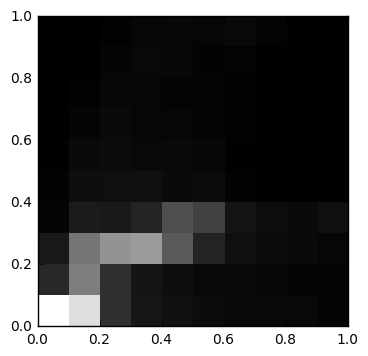

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  5829.0   949.0   560.0   136.0   74.0   39.0   16.0    8.0   13.0    0.0
1  5067.0  2877.0  2652.0   625.0  325.0  244.0  115.0   50.0   20.0   15.0
2  1081.0  1075.0  3355.0   587.0  346.0  286.0  235.0  172.0  125.0   63.0
3   502.0   484.0  3538.0   848.0  346.0  192.0  151.0  144.0  188.0  142.0
4   377.0   330.0  2044.0  1807.0  239.0  210.0  156.0  111.0  162.0  172.0
5   289.0   223.0   799.0  1514.0  265.0  172.0  110.0   96.0   86.0  153.0
6   204.0   241.0   355.0   466.0   87.0   44.0   56.0   65.0   97.0  215.0
7   221.0   160.0   292.0   298.0   40.0   21.0   14.0   19.0   39.0  101.0
8   199.0    92.0   234.0   221.0    0.0    3.0    0.0    6.0    3.0    0.0
9   109.0   100.0   150.0   350.0    0.0    7.0    2.0    0.0    0.0    0.0
(10, 10)


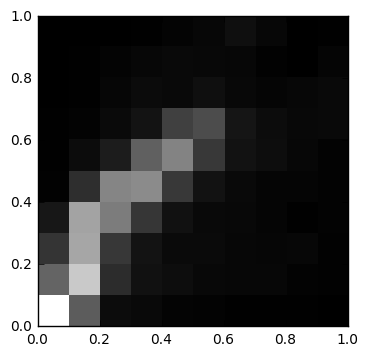

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  4444.0  1745.0   904.0   416.0    43.0    31.0    23.0    9.0    9.0    0.0
1  1611.0  3498.0  2896.0  2846.0   806.0   210.0    68.0   34.0   21.0    0.0
2   223.0   764.0   969.0  2166.0  2313.0   502.0   182.0  116.0   75.0   15.0
3   165.0   296.0   334.0   950.0  2424.0  1668.0   333.0  203.0  133.0   29.0
4    81.0   235.0   180.0   297.0   984.0  2302.0  1117.0  171.0  166.0   75.0
5    56.0   144.0   183.0   159.0   316.0   976.0  1323.0  275.0  144.0  131.0
6    28.0   125.0   126.0   154.0   167.0   313.0   370.0  146.0  125.0  276.0
7    28.0   133.0   111.0    97.0    97.0   240.0   222.0  100.0   51.0  126.0
8    23.0    67.0   124.0    31.0    92.0   136.0   143.0  124.0    9.0    9.0
9     4.0    48.0    44.0    60.0    64.0    55.0   170.0  163.0   89.0   21.0
(10, 10)


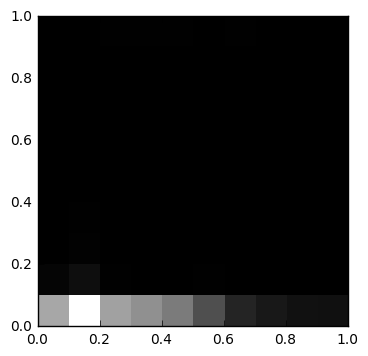

(10, 10)
         0      1      2     3     4     5     6     7     8     9
0   7283.0  229.0   34.0  14.0  10.0  14.0   5.0  11.0  10.0  14.0
1  11111.0  632.0  117.0  56.0  17.0  10.0  12.0  14.0   4.0  17.0
2   7019.0   64.0   32.0  36.0  29.0  27.0  15.0  26.0  29.0  48.0
3   6261.0   15.0   22.0   8.0  15.0  19.0  34.0  40.0  36.0  85.0
4   5354.0   26.0   36.0  16.0  16.0  18.0  14.0  23.0  32.0  73.0
5   3432.0   54.0   37.0  35.0  30.0  41.0  35.0  21.0   7.0  15.0
6   1565.0   40.0   26.0  17.0  29.0  31.0  19.0  28.0  16.0  59.0
7   1078.0   11.0   19.0  14.0   7.0  14.0  12.0   2.0   8.0  40.0
8    758.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
9    718.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
(10, 10)


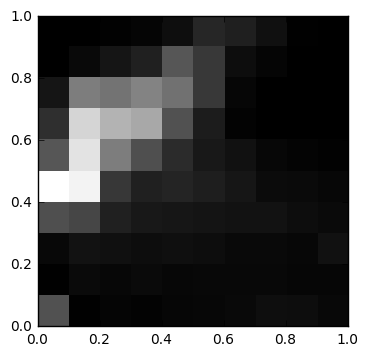

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1065.0   19.0  110.0  1043.0  3340.0  1132.0   620.0   286.0     9.0    0.0
1    14.0  133.0  245.0   915.0  3177.0  2970.0  2779.0  1633.0   123.0    1.0
2    75.0   96.0  211.0   437.0   718.0  1635.0  2344.0  1501.0   274.0   34.0
3    46.0  134.0  182.0   315.0   422.0  1033.0  2200.0  1710.0   423.0   70.0
4    85.0  103.0  203.0   295.0   478.0   569.0  1064.0  1489.0  1133.0  189.0
5   100.0  106.0  176.0   269.0   402.0   316.0   368.0   731.0   733.0  506.0
6   128.0  109.0  122.0   241.0   296.0   222.0    47.0    86.0   172.0  407.0
7   188.0  105.0  121.0   236.0   153.0    97.0     4.0    10.0    70.0  221.0
8   182.0   83.0  101.0   175.0   135.0    53.0     3.0     0.0     2.0   24.0
9   117.0   90.0  234.0   141.0    96.0    35.0     5.0     0.0     0.0    0.0
(10, 10)


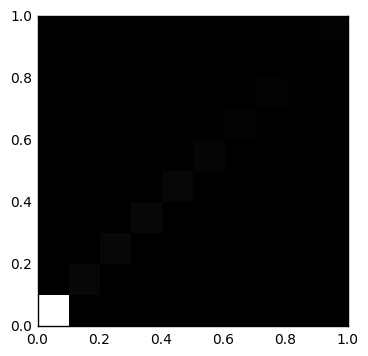

(10, 10)
         0       1       2       3       4      5      6      7      8      9
0  40316.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
1      0.0  1247.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
2      0.0     0.0  1193.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
3      0.0     0.0     0.0  1107.0     0.0    0.0    0.0    0.0    0.0    0.0
4      0.0     0.0     0.0     0.0  1015.0    0.0    0.0    0.0    0.0    0.0
5      0.0     0.0     0.0     0.0     0.0  788.0    0.0    0.0    0.0    0.0
6      0.0     0.0     0.0     0.0     0.0    0.0  585.0    0.0    0.0    0.0
7      0.0     0.0     0.0     0.0     0.0    0.0    0.0  405.0    0.0    0.0
8      0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0  260.0    0.0
9      0.0     0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0  384.0
(10, 10)


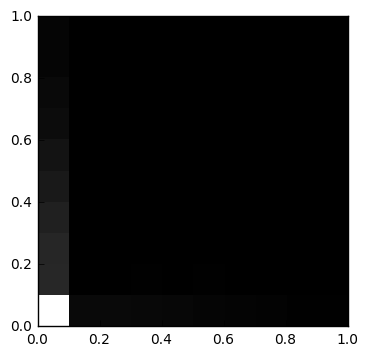

(10, 10)
         0       1       2       3       4       5       6      7      8  \
0  23171.0  3559.0  3526.0  3031.0  2295.0  1741.0  1120.0  865.0  507.0   
1    848.0    90.0    69.0    69.0    50.0    41.0    29.0   18.0   16.0   
2    846.0    74.0    78.0    32.0    42.0    45.0    39.0   25.0    6.0   
3    757.0   105.0    77.0    49.0    44.0    16.0    21.0   28.0    2.0   
4    660.0    80.0    76.0    53.0    49.0    45.0    21.0   19.0    8.0   
5    515.0    99.0    53.0    26.0    31.0    38.0    14.0   10.0    0.0   
6    379.0    69.0    45.0    22.0    20.0    15.0    10.0   10.0    4.0   
7    282.0    35.0    29.0    18.0     6.0    14.0     7.0    8.0    4.0   
8    157.0    30.0    28.0     6.0    12.0     2.0     7.0   10.0    6.0   
9    145.0    34.0    27.0    41.0    40.0    18.0    13.0   19.0   25.0   

       9  
0  501.0  
1   17.0  
2    6.0  
3    8.0  
4    4.0  
5    2.0  
6   11.0  
7    2.0  
8    2.0  
9   22.0  
(10, 10)


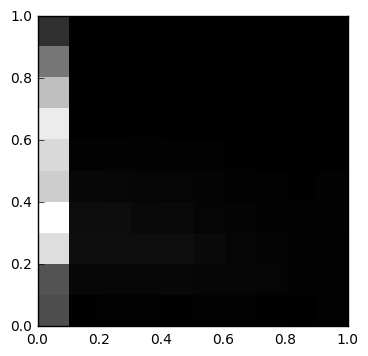

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  1883.0  2022.0  5408.0  6234.0  5008.0  5291.0  5764.0  4672.0  2886.0   
1    39.0   192.0   360.0   311.0   198.0    94.0    33.0     6.0     6.0   
2    56.0   186.0   342.0   321.0   172.0    76.0    28.0     2.0     6.0   
3    54.0   189.0   357.0   240.0   167.0    60.0    26.0     9.0     1.0   
4    34.0   208.0   350.0   223.0   125.0    58.0    15.0     0.0     0.0   
5    64.0   165.0   251.0   135.0   112.0    54.0     7.0     0.0     0.0   
6    55.0   152.0   157.0   111.0    61.0    38.0    10.0     0.0     0.0   
7    31.0   123.0   101.0    56.0    68.0    18.0     6.0     2.0     0.0   
8    20.0    65.0    70.0    57.0    27.0    15.0     6.0     0.0     0.0   
9    72.0    53.0    64.0    78.0    94.0    19.0     4.0     0.0     0.0   

        9  
0  1148.0  
1     8.0  
2     4.0  
3     4.0  
4     2.0  
5     0.0  
6     1.0  
7     0.0  
8     0.0  
9     0.0  
(10, 10)


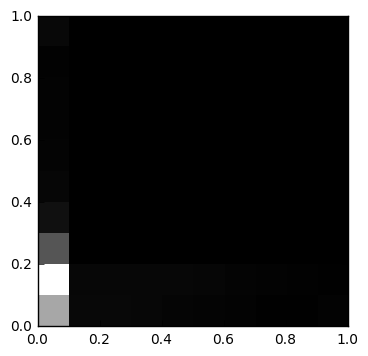

(10, 10)
         0        1       2       3      4      5      6      7      8      9
0  12155.0  18567.0  6203.0  1219.0  504.0  342.0  283.0  228.0  172.0  643.0
1    647.0    511.0    70.0     2.0    2.0    3.0    0.0    2.0    2.0    8.0
2    606.0    534.0    43.0     4.0    0.0    0.0    2.0    0.0    2.0    2.0
3    536.0    519.0    45.0     1.0    0.0    0.0    0.0    0.0    0.0    6.0
4    410.0    561.0    42.0     0.0    0.0    0.0    0.0    0.0    0.0    2.0
5    327.0    445.0    16.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
6    222.0    351.0    11.0     0.0    0.0    0.0    0.0    0.0    0.0    1.0
7    136.0    266.0     3.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
8     90.0    169.0     1.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    248.0    130.0     0.0     0.0    2.0    0.0    0.0    0.0    4.0    0.0
(10, 10)


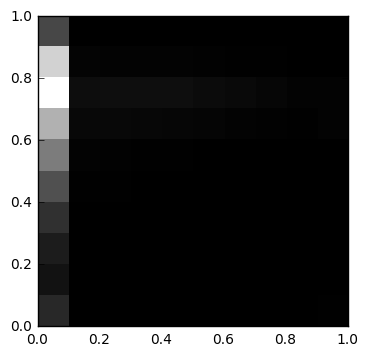

(10, 10)
        0      1       2       3       4       5       6       7       8  \
0  1573.0  709.0  1070.0  1838.0  3087.0  4748.0  6787.0  9766.0  8012.0   
1     8.0    6.0    15.0    22.0    46.0   121.0   321.0   517.0   188.0   
2     4.0    2.0     3.0    15.0    42.0    95.0   327.0   554.0   146.0   
3     8.0    1.0     0.0     5.0    29.0    76.0   305.0   564.0   119.0   
4     0.0    0.0     2.0     6.0    13.0    52.0   249.0   565.0   124.0   
5     0.0    0.0     0.0     0.0    11.0    33.0   216.0   449.0    79.0   
6     0.0    0.0     0.0     0.0     4.0    27.0   146.0   345.0    63.0   
7     0.0    0.0     0.0     0.0     4.0    14.0    91.0   249.0    47.0   
8     0.0    0.0     0.0     0.0     0.0     8.0    70.0   150.0    32.0   
9    64.0    0.0     2.0     0.0     2.0    20.0   139.0   135.0    22.0   

        9  
0  2726.0  
1     3.0  
2     5.0  
3     0.0  
4     4.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
(10, 10)


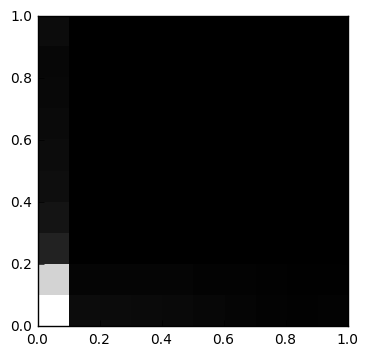

(10, 10)
         0        1       2       3       4      5      6      7      8      9
0  17545.0  14513.0  2385.0  1417.0  1022.0  849.0  687.0  557.0  512.0  829.0
1    829.0    359.0    36.0    13.0     4.0    2.0    0.0    4.0    0.0    0.0
2    805.0    369.0    14.0     4.0     0.0    1.0    0.0    0.0    0.0    0.0
3    723.0    366.0    16.0     0.0     0.0    2.0    0.0    0.0    0.0    0.0
4    646.0    353.0    16.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
5    536.0    243.0     9.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
6    371.0    209.0     3.0     2.0     0.0    0.0    0.0    0.0    0.0    0.0
7    262.0    143.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
8    153.0    107.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
9    271.0    109.0     4.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


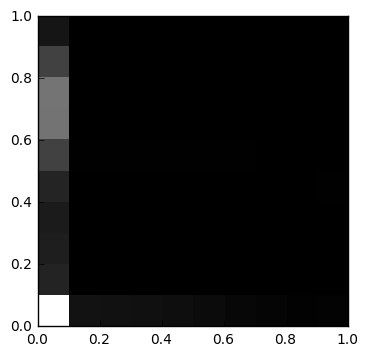

(10, 10)
         0       1       2       3       4       5       6       7       8  \
0  13366.0  1846.0  1612.0  1435.0  1955.0  3451.0  6023.0  6096.0  3414.0   
1    941.0    30.0    42.0    28.0    35.0    91.0    49.0    29.0     2.0   
2    889.0    36.0    22.0    21.0    46.0   103.0    49.0    19.0     8.0   
3    846.0    14.0    36.0    18.0    39.0    87.0    38.0    25.0     4.0   
4    763.0    17.0    31.0    27.0    47.0    77.0    34.0    14.0     5.0   
5    592.0     9.0    18.0    22.0    48.0    69.0    22.0     8.0     0.0   
6    409.0    10.0    32.0    28.0    35.0    53.0     7.0    11.0     0.0   
7    296.0     7.0    10.0    12.0    39.0    31.0     6.0     4.0     0.0   
8    145.0    10.0     6.0    35.0    35.0    23.0     4.0     2.0     0.0   
9    173.0     3.0     4.0    43.0   104.0    51.0     6.0     0.0     0.0   

        9  
0  1118.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  


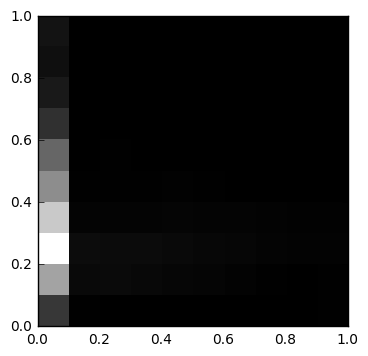

(10, 10)
        0       1        2       3       4       5       6      7      8  \
0  2150.0  6409.0  10002.0  7885.0  5511.0  4018.0  1952.0  997.0  614.0   
1    62.0   386.0    471.0   175.0    71.0    37.0    18.0   13.0    2.0   
2    33.0   395.0    461.0   183.0    54.0    42.0    13.0   10.0    0.0   
3    34.0   319.0    449.0   195.0    69.0    21.0    13.0    0.0    1.0   
4    19.0   259.0    383.0   226.0    81.0    27.0    16.0    0.0    0.0   
5    20.0   213.0    295.0   179.0    52.0    24.0     0.0    0.0    3.0   
6     0.0   123.0    247.0   162.0    31.0    14.0     6.0    0.0    0.0   
7     2.0    53.0    186.0   122.0    27.0    10.0     2.0    0.0    3.0   
8     4.0    32.0    125.0    83.0     8.0     8.0     0.0    0.0    0.0   
9    56.0    78.0    133.0    79.0    26.0     2.0     2.0    0.0    0.0   

       9  
0  778.0  
1   12.0  
2    2.0  
3    6.0  
4    4.0  
5    2.0  
6    2.0  
7    0.0  
8    0.0  
9    8.0  
(10, 10)


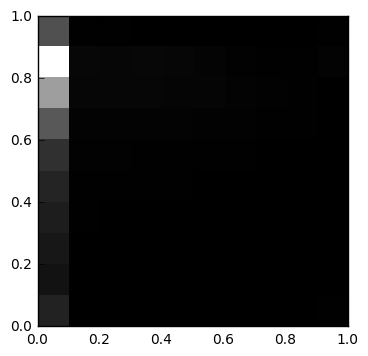

(10, 10)
        0      1       2       3       4       5       6       7        8  \
0  1813.0  964.0  1199.0  1549.0  1882.0  2575.0  4614.0  8246.0  13294.0   
1     4.0    6.0    12.0    55.0    74.0   110.0   191.0   330.0    392.0   
2     4.0    0.0     4.0    16.0    87.0   132.0   182.0   350.0    350.0   
3    10.0    0.0     0.0    25.0    67.0    99.0   183.0   320.0    371.0   
4     2.0    0.0     6.0    25.0    60.0    83.0   182.0   292.0    320.0   
5     0.0    0.0     5.0    22.0    23.0    75.0   122.0   288.0    224.0   
6     0.0    0.0    10.0    12.0    22.0    55.0   130.0   179.0    134.0   
7     0.0    0.0     2.0    18.0     8.0    44.0    70.0   132.0    100.0   
8     0.0    0.0     4.0     8.0     7.0    17.0    54.0    76.0     60.0   
9    60.0    0.0     0.0     4.0     0.0     2.0    48.0    45.0    158.0   

        9  
0  4180.0  
1    73.0  
2    68.0  
3    32.0  
4    45.0  
5    29.0  
6    43.0  
7    31.0  
8    34.0  
9    67.0  
(10, 10)


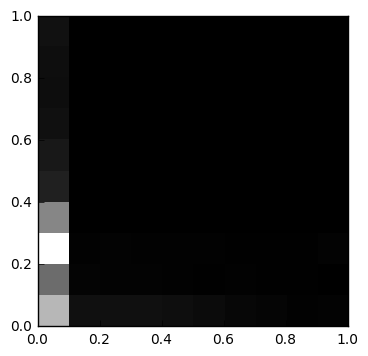

(10, 10)
        0       1        2       3       4       5      6      7      8      9
0  9221.0  5456.0  12846.0  6762.0  1701.0  1214.0  853.0  671.0  731.0  861.0
1   833.0   223.0    129.0    42.0    12.0     4.0    2.0    0.0    2.0    0.0
2   809.0   190.0    175.0    13.0     6.0     0.0    0.0    0.0    0.0    0.0
3   817.0   154.0    117.0    18.0     1.0     0.0    0.0    0.0    0.0    0.0
4   712.0   146.0    148.0     9.0     0.0     0.0    0.0    0.0    0.0    0.0
5   555.0    97.0    129.0     5.0     2.0     0.0    0.0    0.0    0.0    0.0
6   373.0   118.0     91.0     3.0     0.0     0.0    0.0    0.0    0.0    0.0
7   276.0    58.0     71.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0
8   128.0    52.0     80.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0
9   154.0    37.0    193.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0
(10, 10)


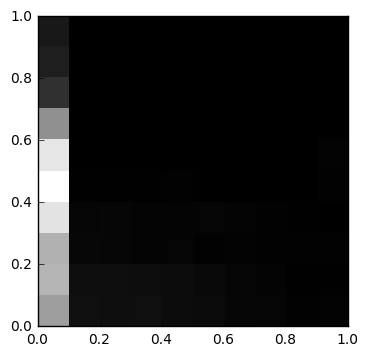

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  4312.0  4937.0  4834.0  6212.0  6978.0  6293.0  3926.0  1339.0  818.0   
1   410.0   397.0   212.0   151.0    47.0    12.0     8.0     0.0    4.0   
2   400.0   384.0   185.0   164.0    42.0    10.0     6.0     0.0    0.0   
3   409.0   369.0   134.0   134.0    45.0     7.0     3.0     2.0    0.0   
4   336.0   348.0   140.0   133.0    56.0     0.0     0.0     0.0    0.0   
5   284.0   258.0    77.0   137.0    24.0     8.0     0.0     0.0    0.0   
6   190.0   162.0    94.0   116.0    17.0     5.0     0.0     0.0    0.0   
7   143.0   118.0    71.0    59.0    10.0     4.0     0.0     0.0    0.0   
8    72.0    53.0    61.0    50.0    19.0     5.0     0.0     0.0    0.0   
9   107.0    29.0    63.0    20.0    68.0    89.0     8.0     0.0    0.0   

       9  
0  667.0  
1    6.0  
2    2.0  
3    4.0  
4    2.0  
5    0.0  
6    1.0  
7    0.0  
8    0.0  
9    0.0  
(10, 10)


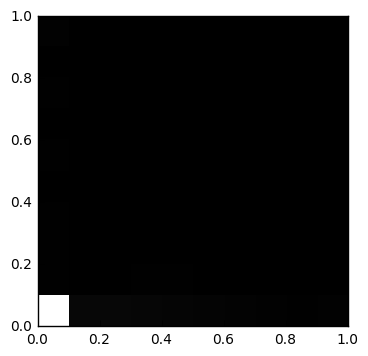

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0  38562.0  294.0  209.0  152.0  139.0  164.0  146.0  161.0  142.0  347.0
1   1173.0   46.0   10.0   10.0    0.0    6.0    0.0    2.0    0.0    0.0
2   1083.0   89.0   14.0    4.0    3.0    0.0    0.0    0.0    0.0    0.0
3    921.0  163.0   18.0    2.0    3.0    0.0    0.0    0.0    0.0    0.0
4    833.0  151.0   17.0   10.0    0.0    4.0    0.0    0.0    0.0    0.0
5    648.0  108.0   16.0   10.0    4.0    0.0    0.0    2.0    0.0    0.0
6    470.0   89.0   20.0    4.0    2.0    0.0    0.0    0.0    0.0    0.0
7    311.0   77.0   11.0    4.0    2.0    0.0    0.0    0.0    0.0    0.0
8    227.0   29.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    351.0   25.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0
(10, 10)


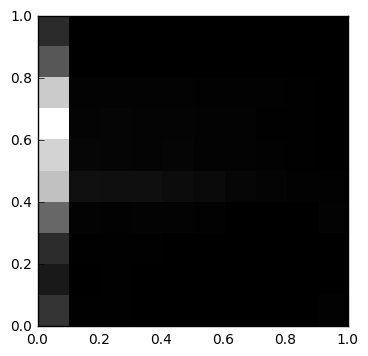

(10, 10)
        0      1       2       3       4       5       6       7       8  \
0  1727.0  829.0  1464.0  3414.0  6375.0  7018.0  8442.0  6704.0  2893.0   
1    40.0   19.0    48.0   122.0   537.0   200.0   150.0   120.0     9.0   
2    33.0   34.0    46.0    87.0   506.0   178.0   174.0   125.0    10.0   
3    21.0    8.0    36.0   114.0   521.0   135.0   164.0   100.0     8.0   
4    19.0   20.0    23.0   105.0   415.0   171.0   160.0   102.0     0.0   
5    17.0   11.0    24.0    68.0   334.0   115.0   127.0    84.0     8.0   
6    21.0   13.0    15.0    28.0   214.0   109.0   103.0    82.0     0.0   
7    13.0   14.0    14.0    12.0   163.0    75.0    40.0    67.0     7.0   
8    13.0   15.0     8.0    12.0    86.0    33.0    54.0    39.0     0.0   
9    96.0   15.0    27.0   105.0    66.0    28.0    20.0    23.0     4.0   

        9  
0  1450.0  
1     2.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0  
(10, 10)


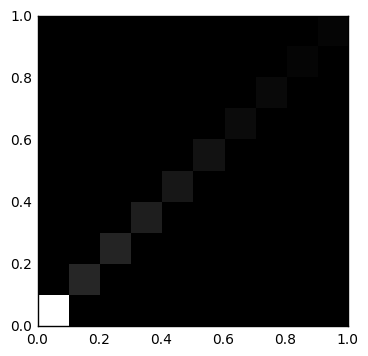

(10, 10)
         0       1       2       3       4       5       6       7      8  \
0  27760.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1      0.0  4175.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2      0.0     0.0  4008.0     0.0     0.0     0.0     0.0     0.0    0.0   
3      0.0     0.0     0.0  3347.0     0.0     0.0     0.0     0.0    0.0   
4      0.0     0.0     0.0     0.0  2589.0     0.0     0.0     0.0    0.0   
5      0.0     0.0     0.0     0.0     0.0  1975.0     0.0     0.0    0.0   
6      0.0     0.0     0.0     0.0     0.0     0.0  1281.0     0.0    0.0   
7      0.0     0.0     0.0     0.0     0.0     0.0     0.0  1012.0    0.0   
8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  578.0   
9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  575.0  
(10, 10)


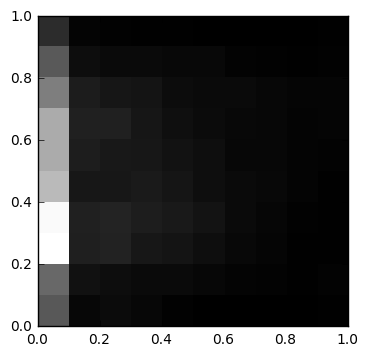

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  1658.0  1944.0  4764.0  4660.0  3481.0  3190.0  3186.0  2355.0  1688.0   
1   152.0   327.0   592.0   604.0   442.0   548.0   621.0   542.0   258.0   
2   224.0   266.0   642.0   665.0   443.0   458.0   621.0   434.0   200.0   
3   143.0   211.0   438.0   556.0   498.0   445.0   433.0   381.0   200.0   
4    48.0   196.0   390.0   477.0   404.0   343.0   301.0   232.0   165.0   
5    23.0   140.0   285.0   370.0   274.0   280.0   226.0   195.0   158.0   
6    13.0    83.0   165.0   212.0   195.0   156.0   162.0   194.0    76.0   
7    12.0    75.0   115.0   136.0   163.0   140.0   141.0   145.0    63.0   
8     8.0    35.0    42.0    50.0   100.0    97.0    92.0   105.0    40.0   
9    27.0    78.0    27.0    36.0    32.0    66.0   116.0   108.0    51.0   

       9  
0  834.0  
1   89.0  
2   55.0  
3   42.0  
4   33.0  
5   24.0  
6   25.0  
7   22.0  
8    9.0  
9   34.0  
(10, 10)


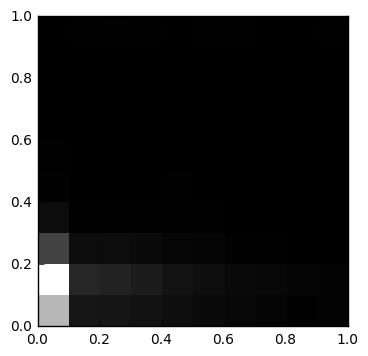

(10, 10)
        0        1       2      3      4     5     6     7     8      9
0  9713.0  13498.0  3555.0  683.0  161.0  65.0  38.0  16.0  14.0   17.0
1  1167.0   2033.0   701.0  118.0   53.0  15.0   9.0   7.0   8.0   64.0
2  1163.0   1841.0   644.0  106.0   39.0  25.0  22.0  12.0  12.0  144.0
3   961.0   1486.0   549.0   84.0   57.0  50.0  29.0  16.0   7.0  108.0
4   823.0   1045.0   375.0   78.0   60.0  45.0  53.0  33.0  22.0   55.0
5   570.0    777.0   273.0   61.0   57.0  58.0  47.0  39.0  31.0   62.0
6   382.0    500.0   132.0   34.0   40.0  38.0  36.0  33.0  26.0   60.0
7   279.0    442.0   111.0   25.0   13.0  25.0  29.0  31.0  21.0   36.0
8   146.0    246.0    47.0   24.0   13.0  15.0  13.0  20.0  11.0   43.0
9   173.0    185.0    47.0   13.0   15.0   9.0   9.0  23.0  28.0   73.0
(10, 10)


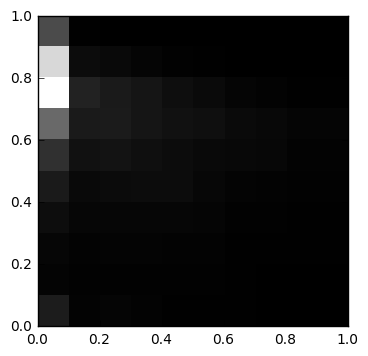

(10, 10)
        0      1      2      3      4       5       6       7       8       9
0  1019.0  176.0  217.0  495.0  929.0  1723.0  3756.0  9086.0  7690.0  2669.0
1   130.0   75.0  136.0  246.0  345.0   620.0   930.0  1217.0   428.0    48.0
2   184.0   80.0  146.0  228.0  414.0   695.0   980.0   948.0   324.0     9.0
3   125.0  105.0  163.0  225.0  445.0   562.0   755.0   771.0   188.0     8.0
4    44.0   83.0  127.0  225.0  429.0   437.0   635.0   505.0   100.0     4.0
5    48.0   83.0  110.0  179.0  258.0   331.0   551.0   363.0    52.0     0.0
6    38.0   36.0   65.0   96.0  153.0   307.0   370.0   185.0    31.0     0.0
7    21.0   30.0   48.0   79.0  114.0   265.0   305.0   137.0    13.0     0.0
8    13.0   26.0   37.0   61.0   80.0   122.0   189.0    46.0     4.0     0.0
9    35.0   24.0   43.0   52.0   71.0   132.0   180.0    36.0     2.0     0.0
(10, 10)


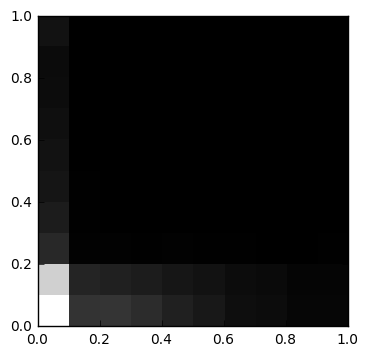

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  11244.0  9179.0  1775.0  1231.0  924.0  830.0  677.0  559.0  512.0  829.0
1   2274.0  1634.0   114.0    82.0   52.0   13.0    4.0    2.0    0.0    0.0
2   2358.0  1457.0   116.0    43.0   25.0    3.0    6.0    0.0    0.0    0.0
3   1981.0  1239.0    84.0    28.0   11.0    4.0    0.0    0.0    0.0    0.0
4   1484.0   979.0    94.0    22.0    6.0    4.0    0.0    0.0    0.0    0.0
5   1065.0   808.0    74.0    20.0    8.0    0.0    0.0    0.0    0.0    0.0
6    630.0   564.0    77.0    10.0    0.0    0.0    0.0    0.0    0.0    0.0
7    535.0   441.0    36.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
8    303.0   235.0    40.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    267.0   235.0    73.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


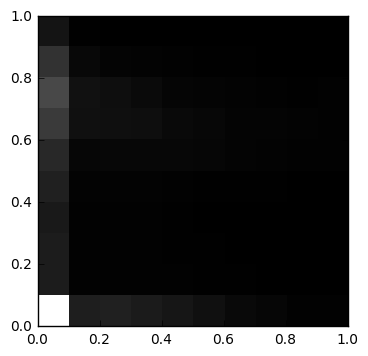

(10, 10)
         0       1       2       3       4       5       6       7       8  \
0  11545.0  1303.0  1269.0  1170.0  1474.0  1851.0  2646.0  3273.0  2298.0   
1   1394.0   109.0   111.0   104.0   156.0   310.0   735.0   814.0   388.0   
2   1499.0   126.0   112.0   138.0   154.0   339.0   714.0   672.0   229.0   
3   1230.0    99.0    98.0   109.0   157.0   345.0   649.0   474.0   159.0   
4   1010.0   126.0    83.0    63.0   134.0   323.0   450.0   274.0   109.0   
5    759.0    89.0    57.0    31.0    92.0   279.0   348.0   215.0    76.0   
6    433.0    62.0    38.0    15.0    59.0   212.0   215.0   169.0    71.0   
7    308.0    39.0    24.0    23.0    86.0   169.0   205.0   121.0    26.0   
8    122.0    23.0    11.0    10.0    29.0   104.0   149.0    78.0    45.0   
9    120.0     6.0    10.0     6.0    42.0   104.0   127.0   118.0    32.0   

       9  
0  931.0  
1   54.0  
2   25.0  
3   27.0  
4   17.0  
5   29.0  
6    7.0  
7   11.0  
8    7.0  
9   10.0  
(10, 10)


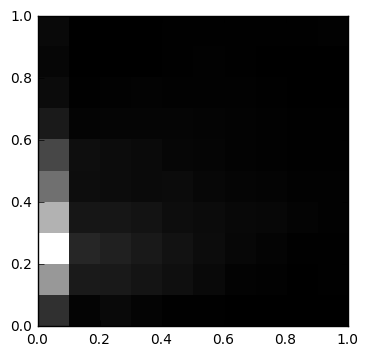

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1551.0  4828.0  8113.0  5661.0  3587.0  2262.0  853.0  368.0  216.0  321.0
1   158.0   846.0  1247.0   726.0   451.0   477.0  147.0   57.0   35.0   31.0
2   306.0   812.0  1054.0   715.0   408.0   399.0  174.0   80.0   28.0   32.0
3   162.0   663.0   819.0   624.0   357.0   332.0  194.0  111.0   45.0   40.0
4    72.0   492.0   597.0   453.0   366.0   207.0  189.0   99.0   57.0   57.0
5    47.0   308.0   402.0   372.0   251.0   186.0  143.0  106.0  100.0   60.0
6    25.0   122.0   240.0   280.0   181.0   109.0  110.0   85.0   69.0   60.0
7    20.0   105.0   165.0   238.0   154.0    90.0  107.0   52.0   28.0   53.0
8    16.0    31.0    60.0   141.0    88.0    73.0   52.0   32.0   31.0   54.0
9    23.0    60.0    55.0    79.0    87.0    68.0   53.0   30.0   14.0  106.0
(10, 10)


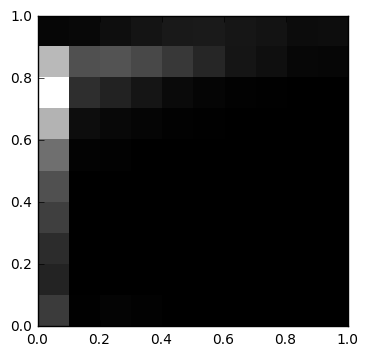

(10, 10)
        0      1       2       3       4       5       6       7       8  \
0  1604.0  970.0  1242.0  1713.0  2181.0  3011.0  4896.0  6943.0  5035.0   
1    52.0    0.0     0.0     4.0    15.0    85.0   371.0  1252.0  2179.0   
2   130.0    0.0     0.0     4.0    15.0    56.0   230.0   927.0  2257.0   
3    72.0    0.0     0.0     3.0     9.0    17.0   141.0   594.0  1965.0   
4     0.0    0.0     0.0     6.0     8.0    10.0    61.0   287.0  1533.0   
5     4.0    0.0     0.0     0.0     2.0    11.0    46.0   148.0  1040.0   
6     0.0    0.0     0.0     0.0     0.0     2.0    20.0    58.0   580.0   
7     4.0    0.0     0.0     0.0     0.0     0.0    11.0    33.0   429.0   
8     4.0    0.0     0.0     4.0     0.0     0.0     0.0    12.0   213.0   
9    23.0    0.0     0.0     0.0     0.0     0.0     0.0     4.0   172.0   

       9  
0  165.0  
1  217.0  
2  389.0  
3  546.0  
4  684.0  
5  724.0  
6  621.0  
7  535.0  
8  345.0  
9  376.0  
(10, 10)


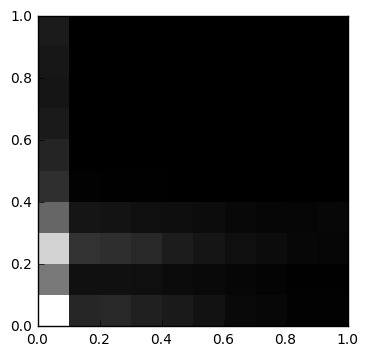

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  8139.0  3868.0  6707.0  3267.0  1497.0  1168.0  849.0  671.0  733.0  861.0
1  1231.0   533.0  1597.0   697.0    84.0    27.0    6.0    0.0    0.0    0.0
2  1319.0   530.0  1464.0   628.0    50.0    17.0    0.0    0.0    0.0    0.0
3  1032.0   492.0  1295.0   487.0    37.0     4.0    0.0    0.0    0.0    0.0
4   848.0   367.0   898.0   452.0    22.0     2.0    0.0    0.0    0.0    0.0
5   575.0   299.0   698.0   386.0    17.0     0.0    0.0    0.0    0.0    0.0
6   314.0   194.0   485.0   279.0     9.0     0.0    0.0    0.0    0.0    0.0
7   239.0   137.0   413.0   217.0     6.0     0.0    0.0    0.0    0.0    0.0
8    93.0    63.0   232.0   190.0     0.0     0.0    0.0    0.0    0.0    0.0
9    88.0    48.0   190.0   249.0     0.0     0.0    0.0    0.0    0.0    0.0
(10, 10)


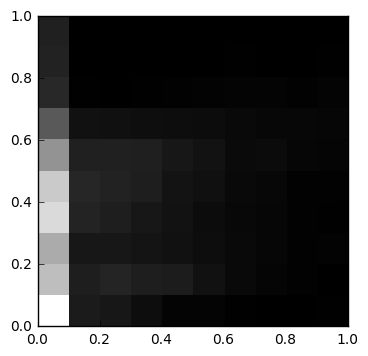

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  5128.0  3811.0  3441.0  4381.0  4063.0  2963.0  1803.0  815.0  694.0  661.0
1   551.0   614.0   464.0   710.0   776.0   652.0   358.0   40.0   10.0    0.0
2   477.0   741.0   470.0   620.0   691.0   642.0   334.0   20.0   13.0    0.0
3   261.0   611.0   416.0   478.0   613.0   630.0   293.0   37.0    8.0    0.0
4    95.0   564.0   359.0   366.0   398.0   472.0   280.0   47.0    8.0    0.0
5    82.0   347.0   279.0   248.0   323.0   371.0   258.0   61.0    6.0    0.0
6    24.0   181.0   187.0   167.0   198.0   220.0   183.0   98.0   23.0    0.0
7    12.0   119.0   135.0   124.0   141.0   231.0   155.0   81.0   13.0    1.0
8     8.0    47.0    57.0    54.0    58.0   133.0   150.0   56.0   15.0    0.0
9    25.0    20.0    63.0    28.0    45.0   119.0   137.0   86.0   32.0   20.0
(10, 10)


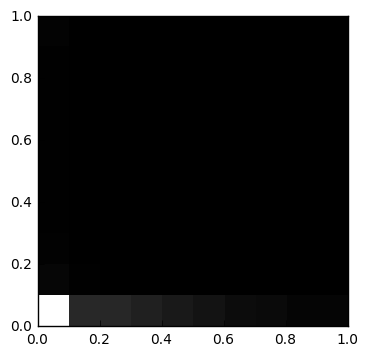

(10, 10)
         0      1      2      3      4      5      6      7      8      9
0  25449.0  689.0  295.0  196.0  153.0  174.0  146.0  165.0  142.0  351.0
1   4058.0  106.0   11.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
2   3928.0   73.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
3   3286.0   57.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
4   2515.0   70.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
5   1932.0   41.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
6   1262.0   19.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
7   1002.0   10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8    572.0    6.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
9    575.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


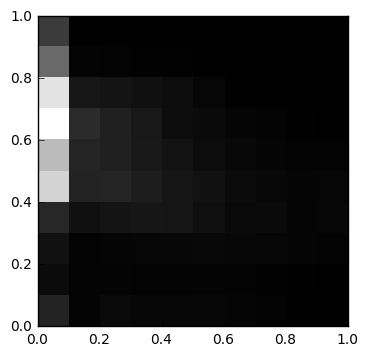

(10, 10)
       0      1      2      3       4       5       6       7       8       9
0  848.0  279.0  412.0  943.0  5092.0  4520.0  6169.0  5499.0  2566.0  1432.0
1  114.0   98.0   85.0  404.0   858.0   885.0  1044.0   558.0   119.0    10.0
2  230.0  111.0  128.0  493.0   874.0   779.0   812.0   482.0    95.0     4.0
3  173.0   94.0  146.0  548.0   711.0   616.0   589.0   392.0    72.0     6.0
4  165.0   89.0  175.0  529.0   522.0   438.0   319.0   302.0    50.0     0.0
5  181.0  100.0  195.0  371.0   410.0   309.0   242.0   145.0    22.0     0.0
6  122.0   91.0  178.0  240.0   271.0   199.0   124.0    47.0     9.0     0.0
7   92.0   68.0  156.0  242.0   204.0   139.0    90.0    15.0     6.0     0.0
8   36.0   34.0  134.0  128.0   121.0    95.0    28.0     2.0     0.0     0.0
9   39.0   14.0   96.0  169.0   154.0    82.0    17.0     4.0     0.0     0.0
(10, 10)


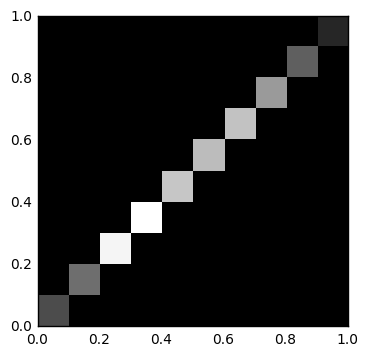

(10, 10)
        0       1       2       3       4       5       6       7       8  \
0  2308.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  3355.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  7460.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0  7766.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0  6032.0     0.0     0.0     0.0     0.0   
5     0.0     0.0     0.0     0.0     0.0  5723.0     0.0     0.0     0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0  5899.0     0.0     0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0  4691.0     0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  2899.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  1167.0  
(10, 10)


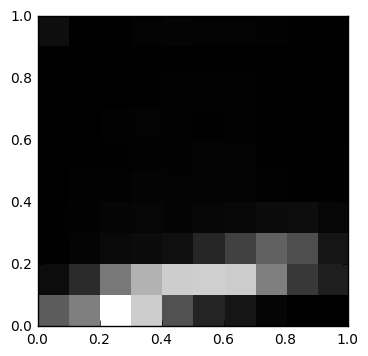

(10, 10)
        0       1       2      3     4     5     6     7     8      9
0  1723.0   231.0    33.0   31.0   6.0   4.0   2.0   0.0   8.0  270.0
1  2356.0   784.0    83.0   42.0  40.0  22.0  18.0   8.0   2.0    0.0
2  4760.0  2242.0   179.0   99.0  45.0  35.0  39.0  16.0  22.0   23.0
3  3819.0  3324.0   212.0  113.0  80.0  50.0  60.0  24.0  28.0   56.0
4  1515.0  3816.0   292.0   85.0  62.0  51.0  44.0  47.0  32.0   88.0
5   705.0  3858.0   716.0  115.0  92.0  58.0  37.0  47.0  35.0   60.0
6   392.0  3800.0  1230.0  160.0  78.0  56.0  51.0  47.0  26.0   59.0
7    94.0  2369.0  1830.0  211.0  43.0  28.0  25.0  27.0  16.0   48.0
8    13.0  1063.0  1460.0  256.0  37.0  16.0   6.0  10.0   8.0   30.0
9     0.0   566.0   399.0  114.0  25.0  25.0   3.0   4.0   3.0   28.0
(10, 10)


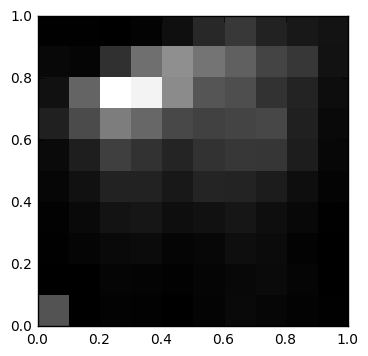

(10, 10)
        0      1      2      3      4      5       6       7       8      9
0  1089.0   18.0   40.0   55.0  107.0  155.0   447.0   237.0   122.0   38.0
1    29.0   24.0   87.0  135.0  246.0  409.0   991.0  1307.0    92.0   35.0
2    58.0   90.0  144.0  264.0  462.0  829.0  1635.0  3310.0   641.0   27.0
3    52.0   76.0  166.0  307.0  466.0  671.0  1352.0  3161.0  1449.0   66.0
4    27.0   44.0   90.0  203.0  327.0  496.0   946.0  1814.0  1863.0  222.0
5    70.0   84.0  111.0  246.0  502.0  668.0   860.0  1123.0  1518.0  541.0
6   140.0  128.0  200.0  302.0  473.0  727.0   903.0  1023.0  1261.0  742.0
7   101.0  155.0  163.0  205.0  378.0  723.0   943.0   661.0   903.0  459.0
8    57.0   82.0   67.0  130.0  198.0  398.0   431.0   469.0   731.0  336.0
9    34.0   17.0   24.0   39.0   79.0  118.0   143.0   189.0   252.0  272.0
(10, 10)


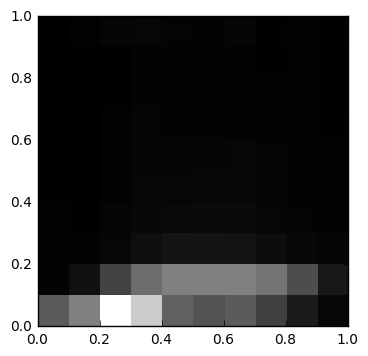

(10, 10)
        0       1      2      3      4      5      6     7     8      9
0  1925.0    97.0   66.0   69.0   40.0   18.0   20.0  23.0  31.0   19.0
1  2690.0   368.0   79.0   53.0   24.0   16.0   15.0  23.0  29.0   58.0
2  5354.0  1416.0  150.0  137.0   69.0   60.0   66.0  39.0  39.0  130.0
3  4274.0  2274.0  315.0  174.0  153.0  123.0  129.0  93.0  90.0  141.0
4  2077.0  2664.0  438.0  221.0  158.0  108.0   98.0  97.0  64.0  107.0
5  1765.0  2698.0  416.0  229.0  171.0  126.0   89.0  79.0  59.0   91.0
6  1925.0  2668.0  409.0  233.0  158.0  153.0   90.0  71.0  67.0  125.0
7  1367.0  2453.0  290.0  144.0  116.0  112.0   67.0  57.0  43.0   42.0
8   595.0  1622.0  184.0   99.0   57.0   70.0   68.0  60.0  65.0   79.0
9   169.0   511.0  136.0   77.0   80.0   68.0   45.0  19.0  25.0   37.0
(10, 10)


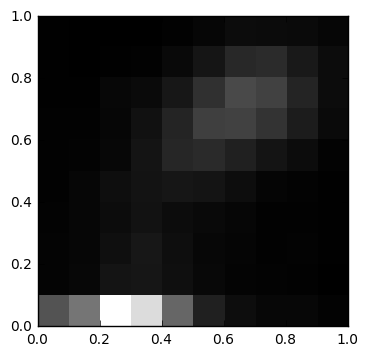

(10, 10)
        0      1      2      3      4      5       6       7      8      9
0  1819.0  106.0   91.0   74.0   49.0   49.0    44.0    31.0   23.0   22.0
1  2568.0  162.0  138.0  152.0  150.0   87.0    51.0    34.0   13.0    0.0
2  5578.0  437.0  336.0  282.0  306.0  173.0   148.0   168.0   26.0    6.0
3  4811.0  499.0  509.0  406.0  419.0  436.0   390.0   224.0   57.0   15.0
4  2235.0  348.0  308.0  263.0  481.0  832.0   800.0   510.0  201.0   54.0
5   714.0  191.0  156.0  201.0  445.0  934.0  1393.0  1080.0  466.0  143.0
6   292.0   97.0  126.0  152.0  302.0  725.0  1422.0  1634.0  874.0  275.0
7   168.0   70.0   47.0   54.0  123.0  453.0  1124.0  1455.0  955.0  242.0
8   164.0   54.0   74.0   62.0   72.0  277.0   627.0   805.0  545.0  219.0
9    71.0   18.0   28.0   23.0   36.0   70.0   239.0   267.0  273.0  142.0
(10, 10)


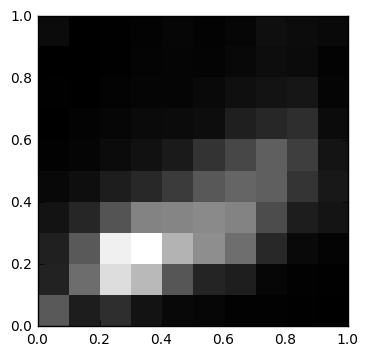

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1028.0   401.0   378.0   227.0    93.0    31.0    9.0   12.0    0.0  129.0
1   337.0  1267.0  1035.0   440.0   170.0    60.0   40.0    4.0    0.0    2.0
2   534.0  2553.0  2773.0   978.0   341.0   133.0   75.0   39.0   21.0   13.0
3   223.0  2136.0  2949.0  1519.0   472.0   198.0  123.0   64.0   47.0   35.0
4    97.0   999.0  2082.0  1538.0   683.0   301.0  133.0   61.0   67.0   71.0
5    80.0   431.0  1640.0  1599.0  1019.0   599.0  156.0  104.0   50.0   45.0
6    30.0   355.0  1273.0  1527.0  1169.0   823.0  367.0  179.0  100.0   76.0
7    30.0    78.0   469.0   883.0  1099.0  1100.0  460.0  230.0  158.0  184.0
8    15.0    33.0   105.0   340.0   605.0   721.0  532.0  262.0  137.0  149.0
9     6.0    14.0    48.0   238.0   279.0   237.0  127.0   65.0   43.0  110.0
(10, 10)


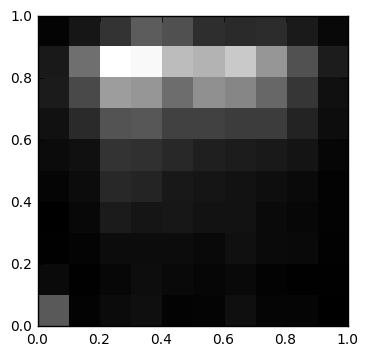

(10, 10)
       0      1      2      3      4      5      6       7       8      9
0  957.0  137.0   49.0   38.0   91.0  150.0  207.0   314.0   293.0   72.0
1   70.0   43.0   74.0  117.0  158.0  204.0  470.0   792.0  1171.0  256.0
2  145.0  109.0  155.0  314.0  444.0  555.0  886.0  1640.0  2652.0  560.0
3  192.0  167.0  158.0  253.0  403.0  538.0  923.0  1568.0  2590.0  974.0
4   61.0  131.0  162.0  267.0  278.0  445.0  715.0  1155.0  1965.0  853.0
5   78.0   95.0  130.0  215.0  254.0  351.0  710.0  1507.0  1875.0  508.0
6  184.0  124.0  200.0  223.0  223.0  324.0  655.0  1405.0  2091.0  470.0
7   89.0   67.0  136.0  134.0  179.0  291.0  646.0  1088.0  1576.0  485.0
8   87.0   48.0  124.0  110.0  135.0  241.0  395.0   588.0   866.0  305.0
9   30.0   49.0   54.0   63.0   65.0   93.0  169.0   201.0   324.0  119.0
(10, 10)


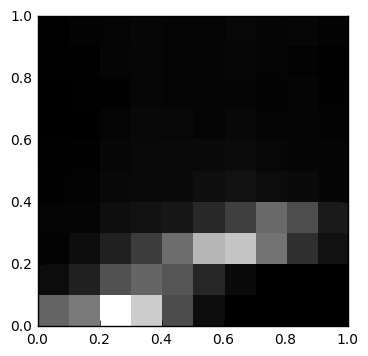

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1794.0   228.0    58.0    86.0   47.0   24.0   14.0    8.0   24.0   25.0
1  2182.0   590.0   236.0    90.0   71.0   51.0   15.0   29.0   35.0   56.0
2  4592.0  1472.0   577.0   263.0  150.0  108.0   76.0   52.0   98.0   72.0
3  3691.0  1815.0  1107.0   335.0  164.0  166.0  153.0  114.0  108.0  113.0
4  1374.0  1542.0  1967.0   427.0  185.0  162.0  132.0   81.0   79.0   83.0
5   237.0   690.0  3269.0   730.0  268.0  165.0   89.0   94.0   93.0   88.0
6     8.0   183.0  3534.0  1143.0  324.0  210.0  152.0   99.0  112.0  134.0
7     0.0     8.0  2073.0  1905.0  222.0  139.0   89.0   66.0   84.0  105.0
8     0.0     1.0   849.0  1397.0  190.0   99.0   80.0   90.0   69.0  124.0
9     0.0     2.0   309.0   476.0  101.0   94.0   55.0   38.0   31.0   61.0
(10, 10)


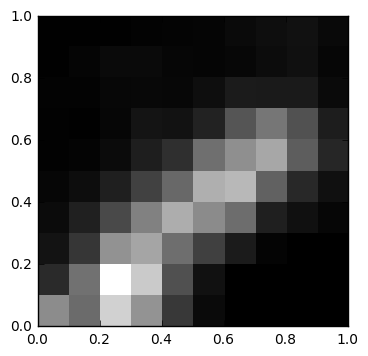

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1390.0   424.0   193.0   117.0    65.0    29.0    29.0   36.0   14.0   11.0
1  1060.0  1124.0   542.0   326.0   137.0    41.0    19.0   39.0   55.0   12.0
2  2069.0  2533.0  1448.0   729.0   308.0   113.0    69.0   76.0  101.0   14.0
3  1465.0  2000.0  1637.0  1280.0   654.0   306.0   199.0   85.0  107.0   33.0
4   571.0   796.0  1096.0  1713.0  1032.0   467.0   179.0   75.0   60.0   43.0
5   108.0   170.0   635.0  1377.0  1734.0  1105.0   344.0  140.0   53.0   57.0
6     0.0     8.0   271.0  1083.0  1829.0  1415.0   843.0  268.0   75.0  107.0
7     0.0     0.0    43.0   316.0   979.0  1654.0  1172.0  260.0  127.0  140.0
8     0.0     0.0     6.0   168.0   403.0   921.0   802.0  259.0  168.0  172.0
9     0.0     0.0     0.0    67.0   165.0   382.0   295.0  103.0   62.0   93.0
(10, 10)


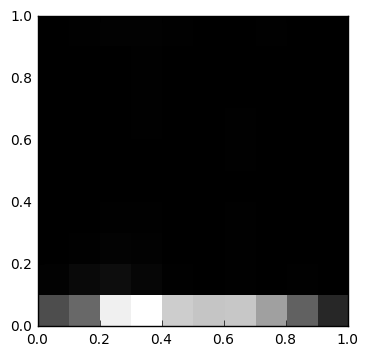

(10, 10)
        0      1     2     3     4     5     6     7     8     9
0  2199.0   57.0   8.0   0.0   2.0   6.0   8.0   8.0  10.0  10.0
1  2944.0  259.0  29.0  12.0  16.0  12.0   3.0  20.0  18.0  42.0
2  6784.0  387.0  85.0  38.0  11.0  18.0  18.0  22.0  24.0  73.0
3  7231.0  181.0  65.0  50.0  19.0  27.0  30.0  42.0  37.0  84.0
4  5816.0   47.0  28.0  16.0  19.0  19.0  21.0  16.0  18.0  32.0
5  5565.0   26.0  23.0  14.0  22.0  17.0  12.0  18.0  10.0  16.0
6  5639.0   53.0  35.0  31.0  27.0  32.0  30.0  21.0   6.0  25.0
7  4533.0   24.0  14.0   9.0  19.0  25.0  12.0  12.0   8.0  35.0
8  2753.0   29.0  28.0  18.0  10.0  16.0  10.0   5.0   9.0  21.0
9  1115.0    8.0   8.0   8.0   8.0   2.0   2.0   1.0   2.0  13.0
(10, 10)


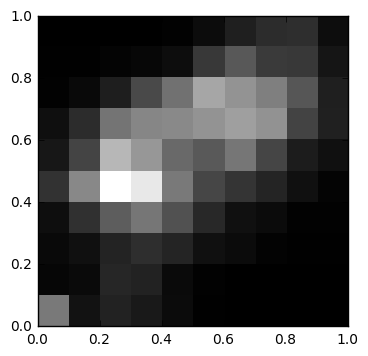

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1139.0   63.0   90.0   136.0   471.0   220.0   147.0    23.0   10.0    9.0
1   171.0  100.0  153.0   464.0  1289.0   647.0   424.0    87.0   14.0    6.0
2   321.0  359.0  333.0   883.0  2409.0  1728.0  1094.0   284.0   43.0    6.0
3   243.0  321.0  437.0  1119.0  2190.0  1422.0  1265.0   694.0   73.0    2.0
4   112.0  101.0  357.0   770.0  1156.0  1005.0  1297.0  1080.0  130.0   24.0
5    10.0   28.0  159.0   395.0   664.0   852.0  1384.0  1571.0  543.0  117.0
6     4.0    4.0  111.0   154.0   491.0  1113.0  1497.0  1395.0  829.0  301.0
7     0.0    2.0   29.0   104.0   346.0   650.0  1383.0  1203.0  555.0  419.0
8     0.0    0.0   18.0    20.0   158.0   270.0   635.0   815.0  543.0  440.0
9     0.0    0.0   18.0    22.0    43.0   155.0   308.0   294.0  199.0  128.0
(10, 10)


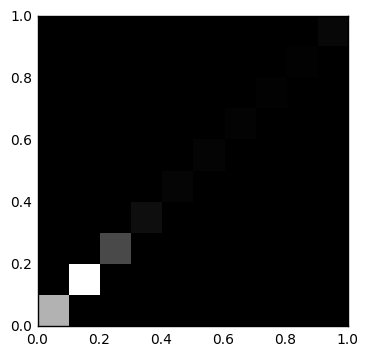

(10, 10)
         0        1       2       3      4      5      6      7      8      9
0  15377.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
1      0.0  22053.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
2      0.0      0.0  6434.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0
3      0.0      0.0     0.0  1226.0    0.0    0.0    0.0    0.0    0.0    0.0
4      0.0      0.0     0.0     0.0  508.0    0.0    0.0    0.0    0.0    0.0
5      0.0      0.0     0.0     0.0    0.0  345.0    0.0    0.0    0.0    0.0
6      0.0      0.0     0.0     0.0    0.0    0.0  285.0    0.0    0.0    0.0
7      0.0      0.0     0.0     0.0    0.0    0.0    0.0  230.0    0.0    0.0
8      0.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0  180.0    0.0
9      0.0      0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0  662.0
(10, 10)


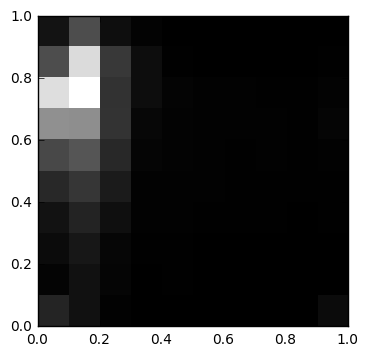

(10, 10)
       0      1      2      3       4       5       6       7       8       9
0  857.0  114.0  267.0  430.0   972.0  1712.0  3435.0  5292.0  1832.0   466.0
1  407.0  410.0  567.0  833.0  1292.0  2041.0  3387.0  6080.0  5205.0  1831.0
2   68.0  132.0  151.0  360.0   658.0   955.0  1224.0  1202.0  1340.0   344.0
3   19.0   20.0   33.0   48.0    69.0   121.0   178.0   327.0   322.0    89.0
4   20.0   24.0   28.0   49.0    61.0    78.0    82.0   115.0    47.0     4.0
5    6.0    8.0   20.0   37.0    50.0    65.0    65.0    67.0    23.0     4.0
6    2.0    6.0   13.0   47.0    42.0    41.0    52.0    68.0    14.0     0.0
7    0.0    4.0    5.0   30.0    27.0    64.0    57.0    36.0     7.0     0.0
8    8.0    0.0    6.0   21.0    32.0    47.0    30.0    28.0     8.0     0.0
9  270.0    0.0    2.0   31.0    35.0    70.0   141.0    79.0    34.0     0.0
(10, 10)


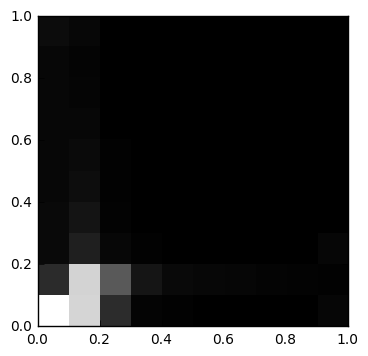

(10, 10)
         0       1       2      3      4      5      6      7      8      9
0  10709.0  1810.0   397.0  406.0  328.0  313.0  304.0  308.0  295.0  507.0
1   8911.0  8875.0  1316.0  840.0  571.0  445.0  333.0  231.0  209.0  322.0
2   1922.0  3771.0   299.0  165.0  123.0   89.0   40.0   22.0    3.0    0.0
3    185.0   908.0    97.0   13.0    4.0    6.0    8.0    0.0    5.0    0.0
4    111.0   380.0    13.0    1.0    0.0    1.0    2.0    0.0    0.0    0.0
5     18.0   316.0    11.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
6      9.0   251.0    25.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
7      2.0   201.0    27.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8      4.0   138.0    32.0    6.0    0.0    0.0    0.0    0.0    0.0    0.0
9    270.0   121.0   266.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


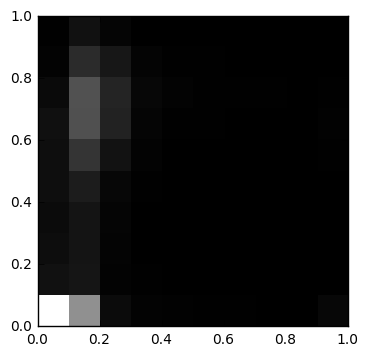

(10, 10)
         0      1      2      3       4       5       6       7       8      9
0  10986.0  757.0  588.0  473.0   632.0   621.0   692.0   444.0   138.0   46.0
1   6215.0  906.0  892.0  862.0  1240.0  2311.0  3473.0  3522.0  1884.0  748.0
2    478.0  166.0  187.0  220.0   327.0   791.0  1479.0  1552.0   994.0  240.0
3    155.0   45.0   31.0   28.0    56.0   132.0   235.0   309.0   204.0   31.0
4     93.0   21.0   27.0   24.0    22.0    25.0    78.0   131.0    63.0   24.0
5     56.0   25.0   31.0   15.0    24.0    15.0    57.0    64.0    44.0   14.0
6     61.0   17.0   27.0   10.0    25.0    24.0    31.0    44.0    39.0    7.0
7     35.0   20.0    8.0   11.0    15.0    25.0    38.0    43.0    27.0    8.0
8     39.0   14.0   10.0    8.0    10.0    15.0    27.0    33.0    24.0    0.0
9    302.0   11.0   12.0   18.0    32.0    77.0   128.0    66.0    16.0    0.0
(10, 10)


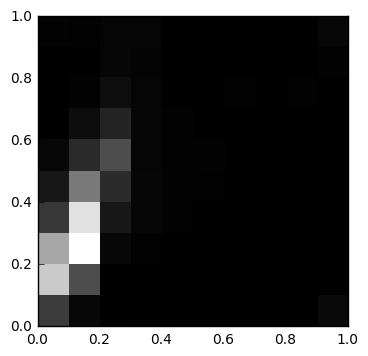

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1793.0  5946.0  4899.0  1656.0   684.0   229.0    53.0   21.0    4.0   92.0
1   257.0  2262.0  7510.0  6629.0  3550.0  1244.0   383.0  100.0   54.0   64.0
2    48.0    57.0   260.0   695.0  1274.0  2270.0  1078.0  413.0  184.0  155.0
3     4.0     2.0    63.0   169.0   186.0   175.0   166.0  162.0  127.0  172.0
4     0.0     0.0    14.0    79.0   116.0    90.0   108.0   49.0   23.0   29.0
5     0.0     0.0     4.0    39.0    62.0    96.0    57.0   50.0   29.0    8.0
6     0.0     0.0     2.0    14.0    37.0    53.0    55.0   72.0   37.0   15.0
7     0.0     0.0     0.0     8.0    11.0    28.0    51.0   44.0   50.0   38.0
8     8.0     0.0     0.0     0.0    10.0    16.0    36.0   62.0   25.0   23.0
9   270.0     0.0     0.0     0.0     0.0     2.0    35.0   47.0   90.0  218.0
(10, 10)


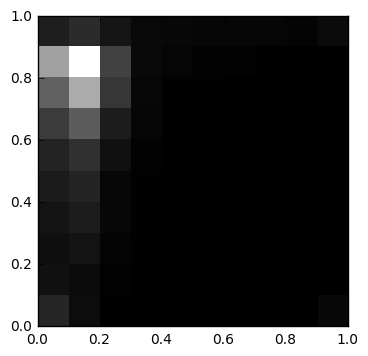

(10, 10)
        0      1      2      3       4       5       6       7       8       9
0  1184.0  529.0  470.0  599.0   833.0  1076.0  1824.0  3016.0  4924.0   922.0
1   386.0  358.0  599.0  876.0  1117.0  1500.0  2820.0  5232.0  7822.0  1343.0
2    30.0   73.0  141.0  215.0   240.0   510.0   889.0  1674.0  1995.0   667.0
3    15.0   10.0   32.0   44.0    36.0    86.0   189.0   231.0   283.0   300.0
4     0.0    0.0    0.0    0.0     4.0    18.0    21.0    49.0   163.0   253.0
5     0.0    0.0    0.0    0.0     0.0     2.0    18.0    34.0    82.0   209.0
6     0.0    0.0    0.0    0.0     0.0     0.0     2.0    11.0    68.0   204.0
7     0.0    0.0    0.0    0.0     0.0     0.0     0.0     1.0    28.0   201.0
8     8.0    0.0    0.0    0.0     0.0     0.0    10.0     2.0    12.0   148.0
9   270.0    0.0    0.0    0.0     0.0     0.0     3.0     8.0    26.0   355.0
(10, 10)


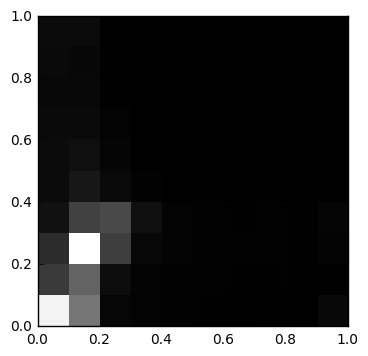

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  8726.0  2100.0  1621.0   624.0  422.0  408.0  364.0  314.0  387.0  411.0
1  4240.0  3559.0  9145.0  2360.0  839.0  564.0  361.0  287.0  276.0  422.0
2   244.0   436.0  2237.0  2670.0  356.0  212.0  113.0   68.0   70.0   28.0
3   127.0   123.0   302.0   543.0   78.0   34.0   17.0    2.0    0.0    0.0
4    87.0    87.0   176.0   139.0   19.0    0.0    0.0    0.0    0.0    0.0
5    44.0    89.0   103.0   104.0    5.0    0.0    0.0    0.0    0.0    0.0
6    48.0    63.0   103.0    71.0    0.0    0.0    0.0    0.0    0.0    0.0
7    27.0    42.0    72.0    89.0    0.0    0.0    0.0    0.0    0.0    0.0
8    33.0    24.0    59.0    62.0    2.0    0.0    0.0    0.0    0.0    0.0
9   302.0     8.0   161.0   190.0    1.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


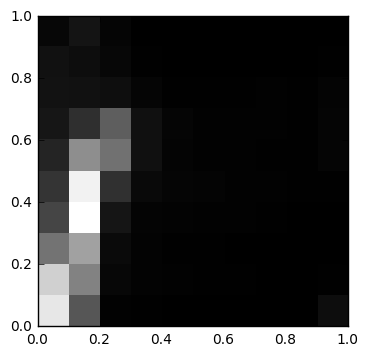

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  4562.0  4117.0  2281.0  1380.0  1032.0   720.0   437.0  358.0  339.0  151.0
1  1706.0  2568.0  3192.0  5052.0  4777.0  2804.0   935.0  349.0  265.0  405.0
2    47.0   154.0   206.0   434.0   967.0  2239.0  1859.0  279.0  144.0  105.0
3    34.0    72.0    71.0    96.0   182.0   321.0   317.0  113.0   20.0    0.0
4    18.0    51.0    36.0    65.0   111.0    84.0   104.0   39.0    0.0    0.0
5    10.0    26.0    23.0    53.0    79.0    57.0    53.0   33.0   10.0    1.0
6     4.0    28.0    19.0    54.0    56.0    50.0    51.0   20.0    3.0    0.0
7     4.0     6.0    19.0    24.0    40.0    32.0    56.0   43.0    2.0    4.0
8     8.0    13.0    12.0    18.0    39.0    22.0    36.0   23.0    7.0    2.0
9   270.0    20.0    12.0     0.0    23.0   104.0   103.0   84.0   32.0   14.0
(10, 10)


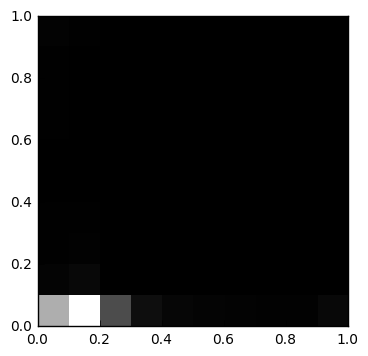

(10, 10)
         0      1      2     3     4     5     6      7      8      9
0  14142.0  348.0  121.0  82.0  62.0  80.0  84.0  105.0  107.0  246.0
1  20786.0  672.0  171.0  90.0  77.0  64.0  28.0   44.0   31.0   90.0
2   6251.0   47.0   25.0  21.0   9.0  16.0  32.0   14.0    4.0   15.0
3   1190.0    4.0    6.0   3.0   5.0  14.0   2.0    2.0    0.0    0.0
4    508.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
5    345.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
6    285.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
7    230.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
8    180.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
9    662.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    0.0    0.0
(10, 10)


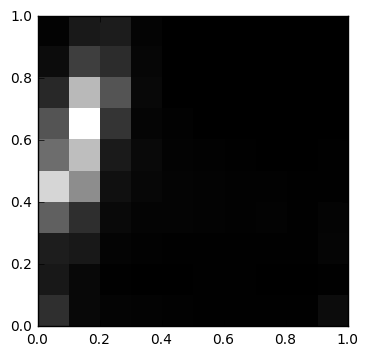

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1105.0  558.0  687.0  2231.0  4981.0  2539.0  1975.0   933.0   284.0   84.0
1   188.0  203.0  577.0  1081.0  3293.0  4422.0  5949.0  4312.0  1442.0  586.0
2   107.0   46.0   95.0   215.0   393.0   625.0  1254.0  1974.0  1052.0  673.0
3    89.0   17.0   52.0    98.0   165.0   211.0   137.0   196.0   159.0  102.0
4    64.0   20.0   24.0   100.0   114.0    91.0    69.0    17.0     2.0    7.0
5    43.0   27.0   26.0    79.0    86.0    58.0    17.0     9.0     0.0    0.0
6    40.0   34.0   31.0    62.0    67.0    37.0    12.0     2.0     0.0    0.0
7    29.0   21.0   32.0    72.0    57.0    14.0     4.0     1.0     0.0    0.0
8    33.0    6.0   44.0    34.0    32.0    23.0     6.0     2.0     0.0    0.0
9   302.0   46.0  137.0    95.0    29.0    42.0    11.0     0.0     0.0    0.0
(10, 10)


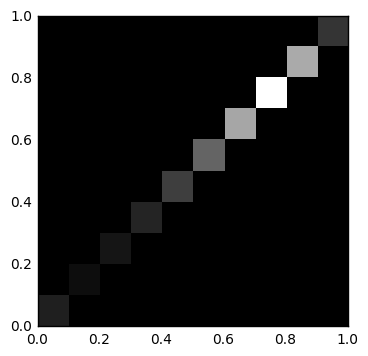

(10, 10)
        0      1       2       3       4       5       6        7       8  \
0  1657.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   
1     0.0  718.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   
2     0.0    0.0  1092.0     0.0     0.0     0.0     0.0      0.0     0.0   
3     0.0    0.0     0.0  1886.0     0.0     0.0     0.0      0.0     0.0   
4     0.0    0.0     0.0     0.0  3238.0     0.0     0.0      0.0     0.0   
5     0.0    0.0     0.0     0.0     0.0  5194.0     0.0      0.0     0.0   
6     0.0    0.0     0.0     0.0     0.0     0.0  8651.0      0.0     0.0   
7     0.0    0.0     0.0     0.0     0.0     0.0     0.0  13294.0     0.0   
8     0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0  8832.0   
9     0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  2738.0  
(10, 10)


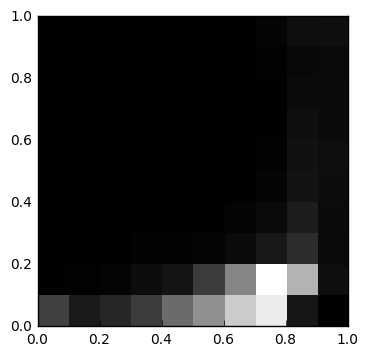

(10, 10)
        0       1       2      3      4      5      6      7      8      9
0  1598.0    31.0    16.0    8.0    4.0    0.0    0.0    0.0    0.0    0.0
1   639.0    66.0     8.0    2.0    0.0    3.0    0.0    0.0    0.0    0.0
2   963.0   107.0    13.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0
3  1482.0   337.0    49.0   12.0    6.0    0.0    0.0    0.0    0.0    0.0
4  2628.0   505.0    68.0   25.0    6.0    2.0    4.0    0.0    0.0    0.0
5  3529.0  1477.0   122.0   36.0   24.0    4.0    2.0    0.0    0.0    0.0
6  4965.0  3257.0   264.0   98.0   42.0   19.0    6.0    0.0    0.0    0.0
7  5778.0  6251.0   606.0  252.0  128.0   64.0   35.0   32.0   49.0   99.0
8   559.0  4396.0  1078.0  709.0  483.0  416.0  357.0  255.0  216.0  363.0
9     0.0   344.0   259.0  285.0  333.0  346.0  283.0  274.0  247.0  367.0
(10, 10)


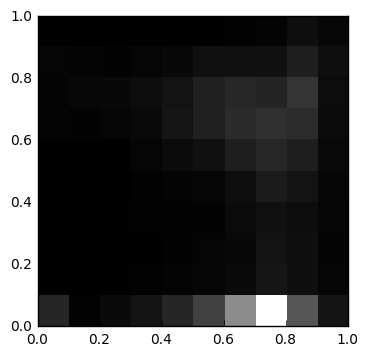

(10, 10)
        0      1      2      3      4       5       6       7      8      9
0  1041.0   39.0   34.0   46.0   31.0    21.0   124.0   128.0  150.0   43.0
1   106.0   26.0   33.0   19.0   12.0    55.0   105.0   202.0  126.0   34.0
2   291.0   51.0   50.0   39.0   38.0    53.0   199.0   242.0   98.0   31.0
3   573.0   90.0   63.0   82.0   91.0   159.0   262.0   352.0  167.0   47.0
4  1050.0  127.0  116.0   84.0  131.0   312.0   580.0   536.0  240.0   62.0
5  1770.0  165.0  157.0  116.0  200.0   451.0   909.0   914.0  453.0   59.0
6  3798.0  282.0  243.0  310.0  393.0   830.0  1191.0  1069.0  457.0   78.0
7  6892.0  623.0  546.0  467.0  762.0  1080.0  1313.0   983.0  483.0  145.0
8  2334.0  418.0  427.0  355.0  546.0   820.0  1231.0  1421.0  865.0  415.0
9   565.0  161.0  144.0  151.0  179.0   255.0   324.0   361.0  394.0  204.0
(10, 10)


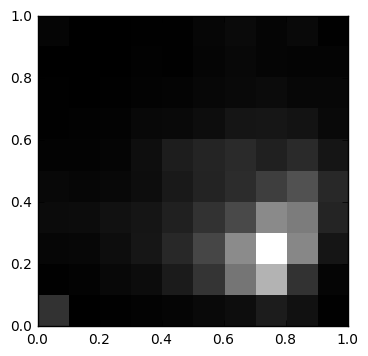

(10, 10)
       0       1       2       3       4      5      6      7      8      9
0  909.0    35.0   114.0   209.0   164.0   68.0   25.0   24.0    8.0  101.0
1    4.0    75.0   133.0   220.0   121.0   71.0   53.0   19.0   16.0    6.0
2   23.0   150.0   248.0   309.0   151.0  104.0   65.0   24.0   10.0    8.0
3   60.0   229.0   399.0   388.0   253.0  269.0  152.0   67.0   40.0   29.0
4  109.0   503.0   731.0   578.0   461.0  530.0  176.0   89.0   28.0   33.0
5  174.0   951.0  1261.0   905.0   645.0  649.0  247.0  141.0   94.0  127.0
6  244.0  2104.0  2495.0  1316.0   802.0  762.0  391.0  177.0  160.0  200.0
7  511.0  3208.0  4568.0  2473.0  1124.0  597.0  397.0  208.0  107.0  101.0
8  319.0   912.0  2411.0  2216.0  1480.0  760.0  346.0  137.0   81.0  170.0
9   27.0   100.0   392.0   675.0   729.0  393.0  170.0  134.0   79.0   39.0
(10, 10)


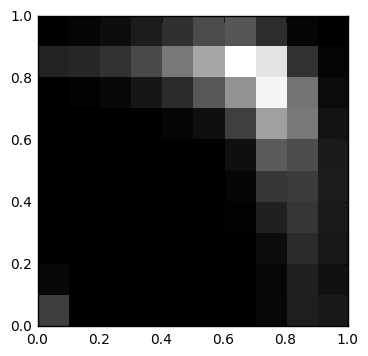

(10, 10)
       0      1      2      3      4       5       6       7       8       9
0  941.0  120.0   12.0    8.0    4.0     4.0     0.0     9.0   532.0    27.0
1    4.0    0.0    0.0    0.0    0.0     3.0     0.0    43.0   589.0    79.0
2    0.0    0.0    0.0    0.0    0.0     0.0     4.0   123.0   763.0   202.0
3    0.0    0.0    0.0    0.0    0.0     0.0    18.0   332.0  1112.0   424.0
4    0.0    0.0    0.0    0.0    0.0     2.0    76.0   643.0  1810.0   707.0
5    0.0    0.0    0.0    0.0    0.0    23.0   231.0  1304.0  2512.0  1124.0
6    0.0    0.0   18.0   31.0   75.0   233.0   945.0  2222.0  3836.0  1291.0
7  119.0  108.0  203.0  481.0  839.0  1366.0  2406.0  3678.0  3428.0   666.0
8  458.0  477.0  655.0  822.0  889.0  1154.0  1808.0  1732.0   757.0    80.0
9  371.0  265.0  354.0  392.0  423.0   407.0   288.0   172.0    64.0     2.0
(10, 10)


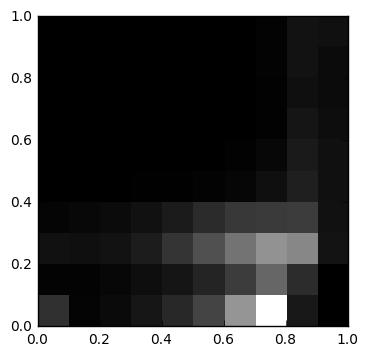

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1085.0    76.0   382.0   112.0    2.0    0.0    0.0    0.0    0.0    0.0
1    97.0    72.0   344.0   195.0   10.0    0.0    0.0    0.0    0.0    0.0
2   236.0   171.0   419.0   250.0   14.0    2.0    0.0    0.0    0.0    0.0
3   502.0   311.0   642.0   395.0   28.0    8.0    0.0    0.0    0.0    0.0
4   927.0   466.0  1178.0   613.0   37.0   13.0    4.0    0.0    0.0    0.0
5  1513.0   806.0  1792.0   973.0   86.0   14.0   10.0    0.0    0.0    0.0
6  3307.0  1336.0  2553.0  1249.0  137.0   46.0   17.0    6.0    0.0    0.0
7  5675.0  2278.0  3244.0  1301.0  341.0  174.0   61.0   63.0   71.0   86.0
8   536.0  1006.0  2995.0  1368.0  709.0  594.0  471.0  343.0  401.0  409.0
9     0.0     9.0   430.0   396.0  358.0  367.0  292.0  259.0  261.0  366.0
(10, 10)


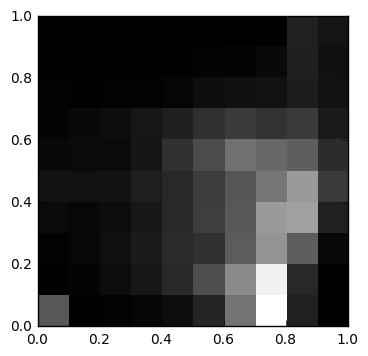

(10, 10)
        0       1       2       3       4       5      6      7      8      9
0  1057.0    16.0    28.0   126.0   225.0   117.0   58.0   26.0    4.0    0.0
1    11.0    53.0    88.0    88.0   211.0   127.0  119.0   17.0    4.0    0.0
2    25.0   155.0   182.0   166.0   235.0   128.0  167.0   32.0    2.0    0.0
3    70.0   288.0   316.0   280.0   371.0   257.0  273.0   26.0    2.0    3.0
4   167.0   501.0   516.0   492.0   493.0   601.0  385.0   65.0   12.0    6.0
5   448.0   932.0   594.0   753.0   744.0   914.0  581.0  174.0   48.0    6.0
6  1397.0  1692.0  1123.0  1064.0  1039.0  1355.0  712.0  205.0   58.0    6.0
7  3094.0  2920.0  1784.0  1864.0  1420.0  1257.0  617.0  210.0  114.0   14.0
8   394.0   491.0  1132.0  1950.0  1865.0  1141.0  718.0  361.0  383.0  397.0
9     0.0     7.0   108.0   393.0   703.0   536.0  321.0  225.0  195.0  250.0
(10, 10)


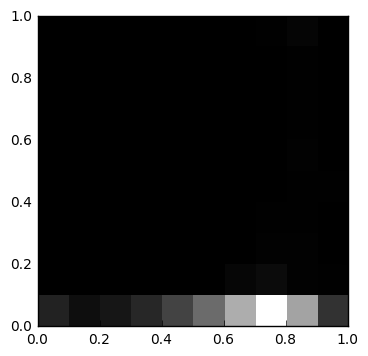

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0   1653.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0
1    718.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
2   1092.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
3   1884.0    2.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
4   3234.0    4.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
5   5146.0   42.0    4.0   2.0   0.0   0.0   0.0   0.0   0.0    0.0
6   8314.0  294.0   35.0   6.0   2.0   0.0   0.0   0.0   0.0    0.0
7  12293.0  561.0  117.0  76.0  27.0  38.0  36.0  43.0  38.0   65.0
8   7834.0  116.0  128.0  83.0  70.0  98.0  88.0  91.0  81.0  243.0
9   2411.0   52.0   39.0  29.0  54.0  38.0  22.0  31.0  23.0   39.0
(10, 10)


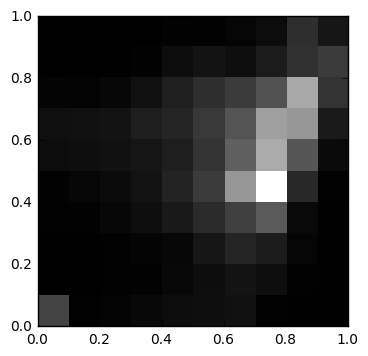

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1085.0    4.0    0.0    16.0    39.0   199.0   241.0    71.0    2.0    0.0
1    22.0    5.0    0.0    47.0   102.0   228.0   255.0    58.0    1.0    0.0
2    50.0   17.0   24.0   119.0   185.0   272.0   306.0   111.0    8.0    0.0
3   132.0   41.0   70.0   223.0   289.0   334.0   488.0   268.0   35.0    6.0
4   194.0  141.0  124.0   406.0   568.0   479.0   597.0   497.0  195.0   37.0
5   236.0  207.0  353.0   671.0   946.0   811.0   894.0   735.0  312.0   29.0
6   253.0  310.0  592.0  1010.0  2384.0  1513.0  1338.0   935.0  234.0   82.0
7    28.0  232.0  449.0  1428.0  4041.0  2688.0  2511.0  1279.0  433.0  205.0
8     0.0   21.0   93.0   144.0   635.0  1366.0  2385.0  2673.0  785.0  730.0
9     0.0    0.0    0.0     3.0    28.0   172.0   419.0   819.0  934.0  363.0
(10, 10)


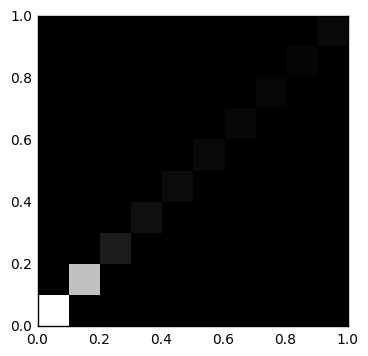

(10, 10)
         0        1       2       3       4      5      6      7      8      9
0  22141.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
1      0.0  16771.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
2      0.0      0.0  2483.0     0.0     0.0    0.0    0.0    0.0    0.0    0.0
3      0.0      0.0     0.0  1436.0     0.0    0.0    0.0    0.0    0.0    0.0
4      0.0      0.0     0.0     0.0  1026.0    0.0    0.0    0.0    0.0    0.0
5      0.0      0.0     0.0     0.0     0.0  854.0    0.0    0.0    0.0    0.0
6      0.0      0.0     0.0     0.0     0.0    0.0  687.0    0.0    0.0    0.0
7      0.0      0.0     0.0     0.0     0.0    0.0    0.0  561.0    0.0    0.0
8      0.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0  512.0    0.0
9      0.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0    0.0  829.0
(10, 10)


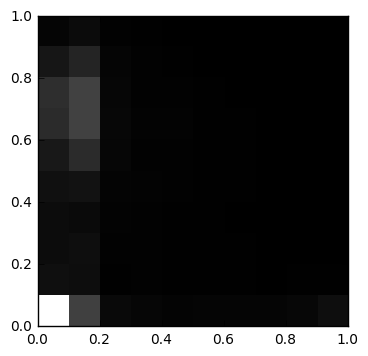

(10, 10)
         0      1      2      3      4       5       6       7       8      9
0  12431.0  759.0  609.0  592.0  796.0  1177.0  2125.0  2278.0  1100.0  274.0
1   3146.0  661.0  680.0  531.0  890.0  2123.0  3222.0  3175.0  1791.0  552.0
2    453.0   89.0  128.0  190.0  209.0   309.0   370.0   339.0   260.0  136.0
3    317.0  103.0  113.0  122.0  148.0   142.0   167.0   139.0   121.0   64.0
4    212.0   93.0   74.0   64.0  112.0    99.0   151.0   111.0    68.0   42.0
5    280.0   63.0   52.0   58.0   80.0    67.0    79.0    96.0    37.0   42.0
6    268.0   64.0   51.0   45.0   79.0    57.0    54.0    44.0    19.0    6.0
7    275.0   48.0   48.0   25.0   33.0    35.0    48.0    15.0    32.0    2.0
8    343.0   51.0   24.0   22.0   22.0    21.0    14.0    11.0     4.0    0.0
9    695.0   51.0   34.0   20.0   14.0     6.0     8.0     0.0     1.0    0.0
(10, 10)


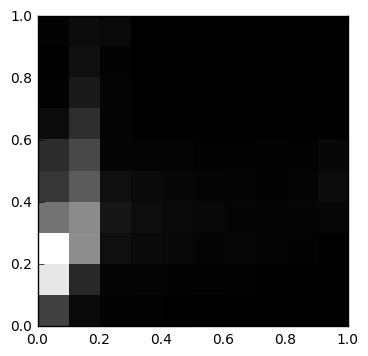

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1877.0  6528.0  7198.0  3236.0  1537.0  1267.0   314.0   76.0   22.0   86.0
1   258.0  1132.0  3993.0  3936.0  2582.0  2051.0  1321.0  707.0  426.0  365.0
2    95.0   126.0   442.0   626.0   433.0   141.0   149.0  114.0   95.0  262.0
3    77.0   143.0   302.0   373.0   299.0   114.0    50.0   45.0   20.0   13.0
4    34.0    96.0   238.0   254.0   209.0   116.0    28.0   17.0   10.0   24.0
5    23.0    96.0   151.0   229.0   168.0    60.0    48.0   36.0   21.0   22.0
6     8.0    70.0   173.0   149.0   140.0    77.0    26.0    8.0   12.0   24.0
7     6.0    44.0   119.0   132.0    99.0   101.0    27.0    8.0   14.0   11.0
8     2.0    30.0    93.0   165.0   125.0    65.0    19.0    3.0    3.0    7.0
9     0.0     2.0    43.0   189.0   338.0   211.0    40.0    6.0    0.0    0.0
(10, 10)


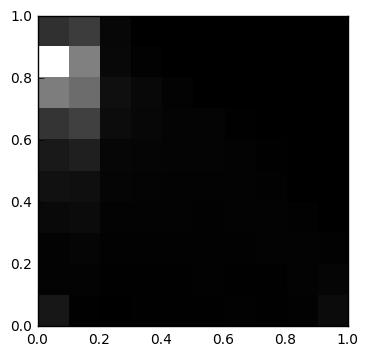

(10, 10)
       0      1      2      3      4       5       6       7       8       9
0  930.0  140.0  143.0  378.0  695.0   985.0  2077.0  4887.0  9963.0  1943.0
1   53.0  125.0  222.0  443.0  613.0  1217.0  2526.0  4210.0  5010.0  2352.0
2   20.0   39.0   98.0  139.0  221.0   243.0   494.0   612.0   312.0   305.0
3   43.0   54.0  102.0  153.0  168.0   208.0   278.0   346.0    84.0     0.0
4   57.0   57.0  116.0  138.0  138.0   171.0   182.0   150.0    17.0     0.0
5   68.0   80.0  110.0  104.0  123.0   167.0   163.0    35.0     4.0     0.0
6   80.0   60.0   85.0  127.0  128.0   139.0    50.0    10.0     6.0     2.0
7   59.0   63.0  118.0  132.0  116.0    59.0     6.0     6.0     2.0     0.0
8  116.0  132.0  140.0   92.0   22.0     3.0     0.0     2.0     5.0     0.0
9  467.0  220.0  108.0   28.0    6.0     0.0     0.0     0.0     0.0     0.0
(10, 10)


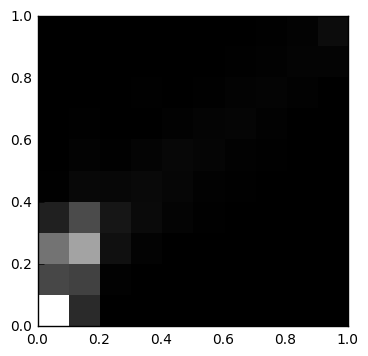

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  11849.0  3311.0  5362.0  1539.0   60.0   16.0    4.0    0.0    0.0    0.0
1   1984.0  3052.0  7582.0  3515.0  378.0  167.0   78.0   12.0    3.0    0.0
2     35.0   137.0   783.0  1059.0  325.0   71.0   35.0   13.0   25.0    0.0
3     10.0    29.0   174.0   466.0  452.0  190.0   44.0   48.0   19.0    4.0
4      0.0     2.0    34.0   186.0  289.0  349.0   96.0   31.0   23.0   16.0
5      0.0     0.0    30.0    78.0  136.0  241.0  216.0   77.0   46.0   30.0
6      0.0     0.0     9.0     8.0   64.0   95.0  238.0  168.0   80.0   25.0
7      0.0     0.0     5.0     1.0   15.0   80.0   96.0  187.0  117.0   60.0
8      0.0     0.0     0.0     0.0    3.0    9.0   45.0  100.0  193.0  162.0
9      0.0     0.0     0.0     0.0    0.0    0.0    3.0   35.0  227.0  564.0
(10, 10)


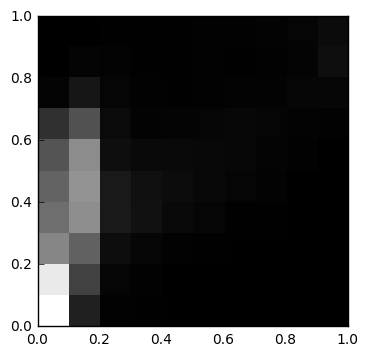

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  5828.0  5328.0  3054.0  2522.0  2270.0  1919.0  1119.0   95.0    6.0    0.0
1   736.0  1505.0  2240.0  3247.0  3360.0  3208.0  1853.0  512.0  101.0    9.0
2    63.0   136.0   307.0   591.0   585.0   321.0   239.0  135.0   73.0   33.0
3    32.0    54.0   157.0   401.0   385.0   223.0    69.0   46.0   38.0   31.0
4     4.0    21.0    64.0   212.0   288.0   224.0   103.0   45.0   34.0   31.0
5     0.0    11.0    35.0   130.0   196.0   204.0   130.0   46.0   46.0   56.0
6     0.0     0.0    10.0    37.0   128.0   172.0   163.0   74.0   44.0   59.0
7     0.0     0.0     4.0    26.0    79.0    98.0   132.0   91.0   50.0   81.0
8     0.0     0.0     0.0    10.0    11.0    53.0    86.0  139.0   93.0  120.0
9     0.0     0.0     0.0     0.0     4.0    11.0    57.0  158.0  337.0  262.0
(10, 10)


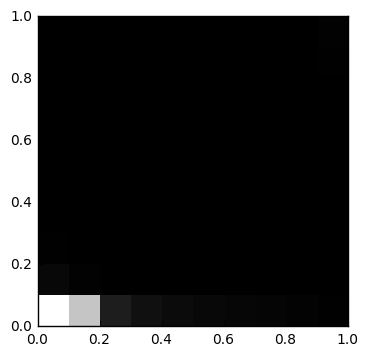

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0  21259.0  700.0  110.0  52.0  12.0   4.0   0.0   0.0   0.0    4.0
1  16415.0  210.0   41.0  28.0  13.0  24.0  26.0   9.0   0.0    5.0
2   2420.0   13.0    8.0   4.0   7.0  10.0   8.0   8.0   5.0    0.0
3   1359.0    9.0   23.0   2.0   9.0  14.0   2.0   8.0   2.0    8.0
4    968.0   10.0   12.0   6.0   6.0   2.0   2.0   4.0   4.0   12.0
5    733.0   26.0    6.0  12.0  13.0  10.0  14.0  13.0   8.0   19.0
6    560.0   20.0   29.0  10.0  12.0  12.0  11.0  14.0   6.0   13.0
7    417.0   28.0   26.0   7.0  15.0   9.0  12.0  11.0  15.0   21.0
8    287.0   23.0   33.0  22.0  11.0  35.0  20.0  28.0  13.0   40.0
9    161.0   32.0   35.0  53.0  55.0  54.0  51.0  70.0  89.0  229.0
(10, 10)


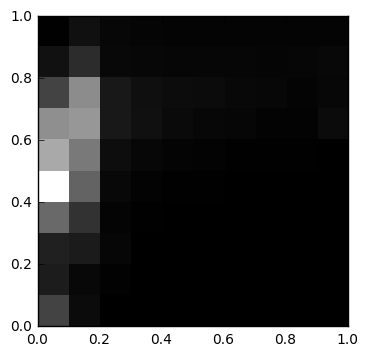

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1679.0  717.0  834.0  2641.0  6363.0  4221.0  3555.0  1668.0   437.0   26.0
1   297.0  205.0  683.0  1261.0  2479.0  3023.0  3769.0  3498.0  1138.0  418.0
2    12.0   53.0  165.0   109.0   199.0   330.0   603.0   616.0   214.0  182.0
3     8.0    0.0   17.0    27.0    79.0   181.0   420.0   386.0   182.0  136.0
4     4.0    0.0    0.0    16.0    38.0   110.0   264.0   318.0   169.0  107.0
5     0.0    3.0    0.0     7.0    26.0    76.0   184.0   282.0   153.0  123.0
6     0.0    0.0    6.0     2.0    16.0    29.0   159.0   202.0   156.0  117.0
7     0.0    0.0    0.0     1.0    13.0    39.0    93.0   178.0   130.0  107.0
8     0.0    0.0    0.0     3.0     4.0    41.0    93.0   101.0   150.0  120.0
9     0.0    0.0    0.0     0.0     0.0    12.0   294.0   197.0   210.0  116.0
(10, 10)


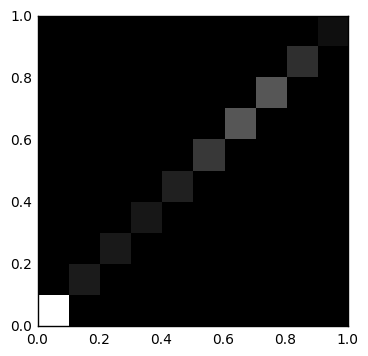

(10, 10)
         0       1       2       3       4       5       6       7       8  \
0  18420.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1      0.0  1982.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2      0.0     0.0  1813.0     0.0     0.0     0.0     0.0     0.0     0.0   
3      0.0     0.0     0.0  1669.0     0.0     0.0     0.0     0.0     0.0   
4      0.0     0.0     0.0     0.0  2383.0     0.0     0.0     0.0     0.0   
5      0.0     0.0     0.0     0.0     0.0  4036.0     0.0     0.0     0.0   
6      0.0     0.0     0.0     0.0     0.0     0.0  6238.0     0.0     0.0   
7      0.0     0.0     0.0     0.0     0.0     0.0     0.0  6208.0     0.0   
8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  3433.0   
9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  1118.0  


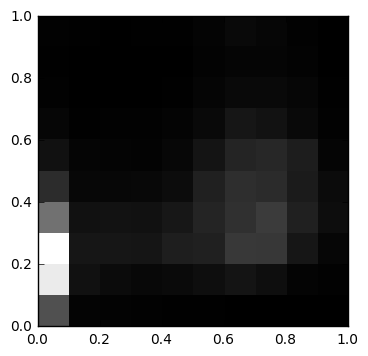

(10, 10)
        0       1       2       3       4      5      6      7      8      9
0  1942.0  5669.0  6172.0  2767.0  1089.0  434.0  168.0   70.0   36.0   73.0
1   121.0   423.0   552.0   421.0   182.0  141.0   56.0   28.0   23.0   35.0
2    95.0   282.0   549.0   456.0   190.0  111.0   63.0   26.0   19.0   22.0
3    57.0   204.0   520.0   418.0   210.0  102.0   65.0   29.0   22.0   42.0
4    53.0   271.0   748.0   579.0   302.0  189.0  116.0   54.0   28.0   43.0
5    49.0   369.0   788.0   918.0   817.0  506.0  242.0  139.0   94.0  114.0
6    27.0   513.0  1359.0  1173.0  1132.0  883.0  541.0  232.0  141.0  237.0
7    19.0   367.0  1343.0  1435.0  1047.0  968.0  465.0  241.0  149.0  174.0
8     9.0   110.0   557.0   797.0   677.0  723.0  242.0  162.0   97.0   59.0
9     8.0    59.0   164.0   325.0   284.0  146.0   64.0   39.0   14.0   15.0
(10, 10)


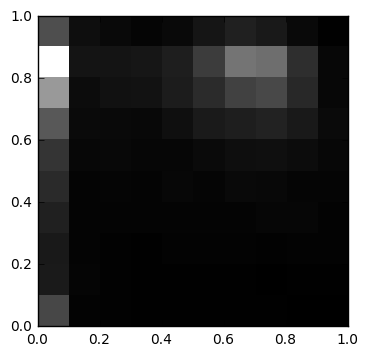

(10, 10)
        0      1      2      3      4       5       6       7       8       9
0  1601.0  585.0  569.0  742.0  943.0  1182.0  1964.0  3408.0  5688.0  1738.0
1    87.0  115.0   93.0  100.0  110.0   176.0   233.0   285.0   449.0   334.0
2    50.0   47.0   56.0   92.0  118.0   201.0   216.0   380.0   451.0   202.0
3    32.0   35.0   45.0   96.0  103.0   137.0   180.0   417.0   500.0   124.0
4    34.0   29.0   74.0   99.0  160.0   146.0   339.0   626.0   672.0   204.0
5    26.0   41.0   90.0  112.0  132.0   229.0   582.0   972.0  1372.0   480.0
6    26.0   33.0   74.0  107.0  204.0   330.0   674.0  1475.0  2600.0   715.0
7    28.0   22.0   68.0  152.0  199.0   338.0   778.0  1609.0  2453.0   561.0
8     7.0   30.0   87.0  152.0  134.0   278.0   577.0   916.0  1044.0   208.0
9     2.0   33.0   86.0   82.0  127.0   175.0   233.0   170.0   174.0    36.0
(10, 10)


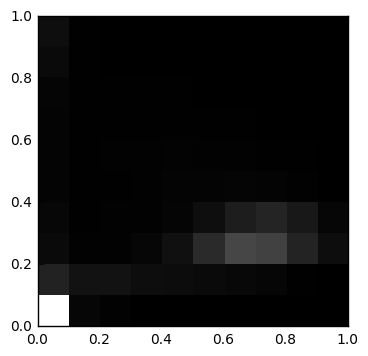

(10, 10)
         0       1       2       3      4      5      6      7      8      9
0  13358.0  1817.0   529.0   375.0  245.0  235.0  258.0  300.0  539.0  764.0
1    329.0   951.0   132.0    93.0   74.0   62.0   91.0   97.0   92.0   61.0
2    148.0   946.0   146.0   108.0   89.0  122.0  103.0   75.0   45.0   31.0
3     30.0   709.0   330.0   137.0  153.0  144.0   76.0   59.0   28.0    3.0
4      9.0   634.0   874.0   269.0  232.0  183.0  100.0   65.0   15.0    2.0
5      2.0   553.0  2197.0   733.0  258.0  150.0   91.0   42.0   10.0    0.0
6      2.0   461.0  3692.0  1536.0  275.0  154.0   88.0   26.0    4.0    0.0
7      0.0   358.0  3496.0  1979.0  232.0  100.0   36.0    7.0    0.0    0.0
8      0.0    86.0  1876.0  1270.0  133.0   60.0    8.0    0.0    0.0    0.0
9      0.0    16.0   707.0   352.0   31.0    8.0    4.0    0.0    0.0    0.0
(10, 10)


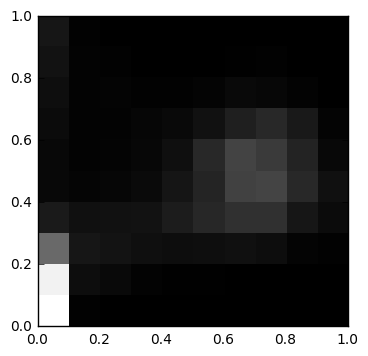

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  6603.0  6252.0  2713.0   675.0   225.0   207.0   303.0  381.0  490.0  571.0
1    58.0   355.0   570.0   432.0   136.0   102.0    82.0  100.0   92.0   55.0
2     2.0   253.0   512.0   448.0   179.0   126.0    92.0  109.0   72.0   20.0
3     0.0    95.0   408.0   469.0   262.0   193.0   158.0   57.0   14.0   13.0
4     0.0    46.0   344.0   737.0   551.0   388.0   242.0   53.0   20.0    2.0
5     0.0    27.0   378.0  1017.0   969.0  1060.0   458.0  112.0   15.0    0.0
6     0.0    14.0   430.0  1239.0  1711.0  1729.0   819.0  235.0   51.0   10.0
7     0.0     8.0   345.0  1281.0  1759.0  1501.0  1037.0  206.0   60.0   11.0
8     0.0     3.0   119.0   585.0  1081.0   909.0   648.0   80.0    8.0    0.0
9     0.0     2.0    52.0   293.0   433.0   218.0   112.0    8.0    0.0    0.0
(10, 10)


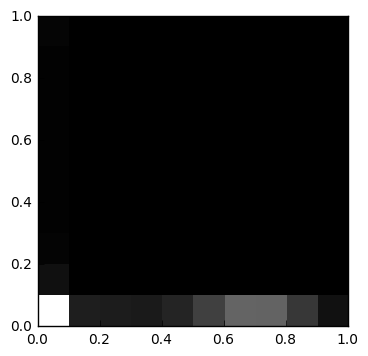

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0  15913.0  1003.0  288.0  165.0  126.0  146.0  133.0  160.0  140.0  346.0
1   1911.0    19.0   13.0    4.0   12.0   12.0    5.0    2.0    2.0    2.0
2   1770.0     9.0    6.0   10.0    6.0    2.0    4.0    3.0    0.0    3.0
3   1639.0    12.0    8.0    6.0    2.0    2.0    0.0    0.0    0.0    0.0
4   2336.0    18.0    4.0    8.0    5.0    8.0    4.0    0.0    0.0    0.0
5   4015.0    10.0    4.0    3.0    0.0    4.0    0.0    0.0    0.0    0.0
6   6236.0     0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0
7   6208.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
8   3433.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
9   1118.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


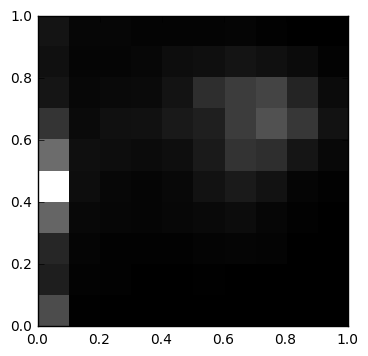

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1937.0  772.0  991.0  2587.0  6512.0  2752.0  1372.0   547.0  422.0  528.0
1    41.0   84.0  150.0   205.0   335.0   393.0   275.0   190.0  142.0  167.0
2    10.0   59.0   72.0   162.0   198.0   346.0   409.0   241.0  144.0  172.0
3     8.0   12.0   53.0   140.0   136.0   281.0   442.0   278.0  195.0  124.0
4     0.0    6.0   54.0   183.0   205.0   363.0   638.0   490.0  334.0  110.0
5     4.0   28.0  115.0   240.0   477.0   671.0   813.0  1182.0  397.0  109.0
6     0.0   15.0  150.0   330.0   663.0  1311.0  1551.0  1537.0  531.0  150.0
7     0.0    0.0  103.0   165.0   478.0  1181.0  2062.0  1732.0  412.0   75.0
8     0.0    2.0   17.0    51.0   151.0   557.0  1406.0   952.0  280.0   17.0
9     0.0    0.0    0.0     4.0    62.0   207.0   466.0   297.0   82.0    0.0
(10, 10)


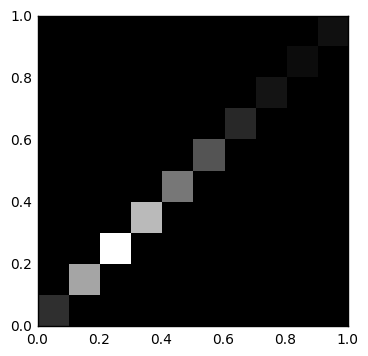

(10, 10)
        0       1        2       3       4       5       6       7      8  \
0  2380.0     0.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1     0.0  8267.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2     0.0     0.0  12752.0     0.0     0.0     0.0     0.0     0.0    0.0   
3     0.0     0.0      0.0  9289.0     0.0     0.0     0.0     0.0    0.0   
4     0.0     0.0      0.0     0.0  5930.0     0.0     0.0     0.0    0.0   
5     0.0     0.0      0.0     0.0     0.0  4203.0     0.0     0.0    0.0   
6     0.0     0.0      0.0     0.0     0.0     0.0  2022.0     0.0    0.0   
7     0.0     0.0      0.0     0.0     0.0     0.0     0.0  1020.0    0.0   
8     0.0     0.0      0.0     0.0     0.0     0.0     0.0     0.0  623.0   
9     0.0     0.0      0.0     0.0     0.0     0.0     0.0     0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  814.0  
(10, 10)


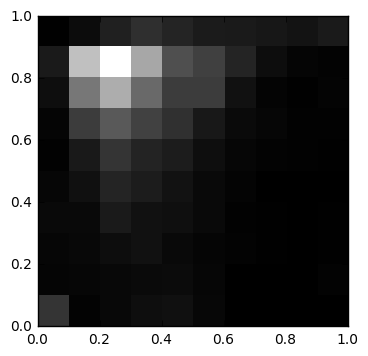

(10, 10)
       0      1      2      3      4      5       6       7       8      9
0  952.0   99.0  115.0  181.0  121.0   48.0   101.0   257.0   487.0   19.0
1   72.0  116.0  151.0  172.0  293.0  463.0  1102.0  2184.0  3495.0  219.0
2  159.0  149.0  245.0  485.0  684.0  981.0  1637.0  3162.0  4660.0  590.0
3  255.0  188.0  312.0  326.0  520.0  644.0  1198.0  1935.0  3040.0  871.0
4  292.0  202.0  176.0  286.0  331.0  517.0   909.0  1114.0  1445.0  658.0
5  131.0  118.0  105.0  172.0  173.0  269.0   455.0  1105.0  1173.0  502.0
6   18.0   18.0   63.0   51.0   75.0  127.0   187.0   315.0   688.0  480.0
7    6.0   18.0   29.0   24.0   14.0   64.0   112.0    73.0   246.0  434.0
8    0.0    2.0   18.0   15.0   11.0   52.0    38.0    35.0    99.0  353.0
9    8.0   60.0   28.0   22.0    8.0   27.0    37.0    78.0    70.0  476.0
(10, 10)


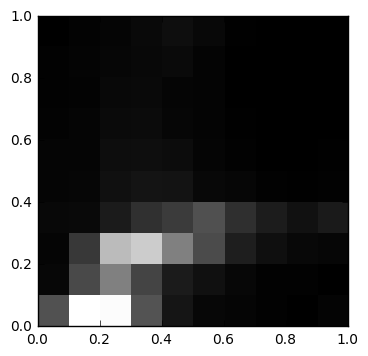

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0  1583.0   153.0   105.0   159.0   99.0  104.0   64.0   53.0   48.0   12.0
1  4971.0  1455.0  1113.0   177.0  121.0  113.0  103.0   69.0   80.0   65.0
2  4894.0  2500.0  3650.0   528.0  328.0  254.0  206.0  157.0  128.0  107.0
3  1624.0  1323.0  3963.0   936.0  394.0  287.0  221.0  178.0  173.0  190.0
4   413.0   536.0  2493.0  1164.0  369.0  251.0  127.0  107.0  197.0  273.0
5   137.0   320.0  1464.0  1558.0  171.0  114.0   85.0   86.0   96.0  172.0
6   103.0   137.0   587.0   928.0  127.0   49.0   36.0    9.0    8.0   38.0
7    50.0    47.0   305.0   548.0   41.0   14.0    4.0    4.0    3.0    4.0
8    15.0    42.0   169.0   342.0   32.0   10.0    7.0    6.0    0.0    0.0
9    88.0    18.0   130.0   512.0   40.0   22.0    2.0    2.0    0.0    0.0
(10, 10)


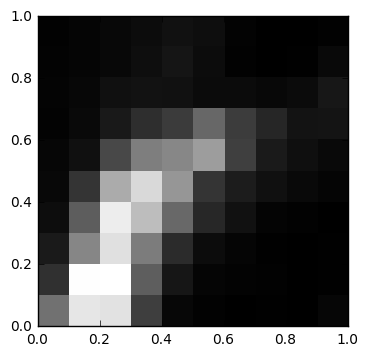

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  1175.0   502.0   271.0   133.0    89.0    62.0    38.0   44.0   37.0   29.0
1  2352.0  2599.0  1370.0   953.0   538.0   164.0    95.0   80.0   58.0   58.0
2  2315.0  2617.0  2294.0  2427.0  1756.0   744.0   258.0  172.0   87.0   82.0
3   643.0   971.0  1275.0  1942.0  2219.0  1292.0   480.0  190.0  153.0  124.0
4    74.0   233.0   445.0  1064.0  1542.0  1387.0   607.0  178.0  220.0  180.0
5    22.0    58.0   128.0   404.0   547.0  1608.0  1053.0  116.0  123.0  144.0
6     6.0    40.0    55.0   178.0   293.0   650.0   621.0  122.0   24.0   33.0
7    12.0    21.0    13.0    44.0   170.0   271.0   389.0   85.0   10.0    5.0
8     0.0     2.0     8.0    21.0    94.0   160.0   197.0  118.0   17.0    6.0
9    64.0    12.0    12.0    10.0    58.0    95.0   213.0  236.0   93.0   21.0
(10, 10)


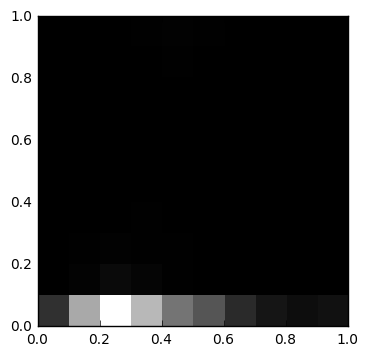

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0   2251.0   26.0   10.0  13.0   8.0  20.0  15.0  16.0   7.0   14.0
1   7925.0  175.0   62.0  20.0  23.0   8.0  10.0   9.0  10.0   25.0
2  11946.0  483.0  113.0  45.0  25.0  35.0  24.0  38.0  12.0   31.0
3   8602.0  276.0   58.0  58.0  41.0  36.0  46.0  41.0  40.0   91.0
4   5456.0   70.0   53.0  38.0  35.0  40.0  35.0  40.0  55.0  108.0
5   3970.0   37.0   21.0  14.0  15.0  29.0  14.0  21.0  18.0   64.0
6   1980.0    2.0    4.0   8.0   6.0   4.0   2.0   0.0   0.0   16.0
7   1012.0    2.0    2.0   0.0   0.0   2.0   0.0   0.0   0.0    2.0
8    623.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
9    814.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
(10, 10)


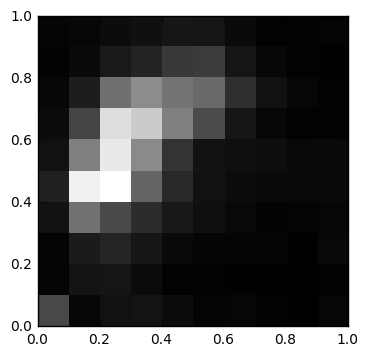

(10, 10)
       0      1      2       3       4       5       6       7      8      9
0  915.0   64.0   65.0   247.0   424.0   231.0   174.0   113.0   61.0   86.0
1   94.0  266.0  352.0  1428.0  3020.0  1612.0   868.0   379.0  145.0  103.0
2  232.0  277.0  473.0   934.0  3207.0  2925.0  2794.0  1405.0  335.0  170.0
3  258.0  162.0  290.0   576.0  1266.0  1746.0  2546.0  1767.0  456.0  222.0
4  164.0   43.0  130.0   322.0   520.0   654.0  1621.0  1465.0  720.0  291.0
5   76.0   41.0   79.0   211.0   228.0   240.0   954.0  1340.0  752.0  282.0
6   95.0   37.0   66.0   126.0   170.0   213.0   279.0   602.0  285.0  149.0
7   51.0   14.0   87.0    58.0   133.0   184.0   105.0   237.0  107.0   44.0
8   16.0   35.0   38.0    64.0   114.0   125.0    51.0    95.0   46.0   39.0
9   99.0   39.0  125.0   101.0   135.0   132.0    42.0    43.0   32.0   66.0
(10, 10)


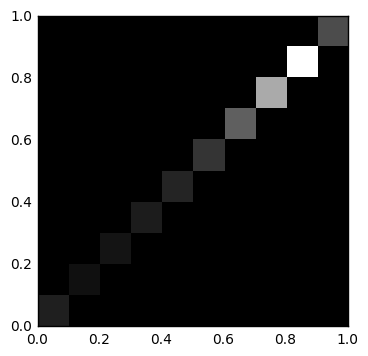

(10, 10)
        0      1       2       3       4       5       6        7        8  \
0  1893.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   
1     0.0  970.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   
2     0.0    0.0  1242.0     0.0     0.0     0.0     0.0      0.0      0.0   
3     0.0    0.0     0.0  1734.0     0.0     0.0     0.0      0.0      0.0   
4     0.0    0.0     0.0     0.0  2230.0     0.0     0.0      0.0      0.0   
5     0.0    0.0     0.0     0.0     0.0  3192.0     0.0      0.0      0.0   
6     0.0    0.0     0.0     0.0     0.0     0.0  5776.0      0.0      0.0   
7     0.0    0.0     0.0     0.0     0.0     0.0     0.0  10258.0      0.0   
8     0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0  15403.0   
9     0.0    0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  4602.0  


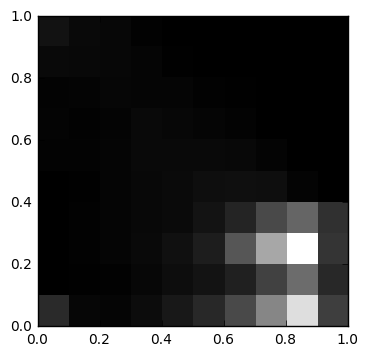

(10, 10)
        0       1       2       3      4      5      6      7      8      9
0   947.0     2.0    16.0    15.0   18.0   84.0  102.0   81.0  207.0  421.0
1   148.0    24.0    49.0    58.0   42.0   82.0   60.0  101.0  191.0  215.0
2   114.0    51.0   125.0   125.0  120.0  128.0  111.0  151.0  159.0  158.0
3   272.0   165.0   216.0   187.0  193.0  207.0  201.0  123.0  118.0   52.0
4   536.0   309.0   371.0   232.0  238.0  219.0  156.0  122.0   36.0   11.0
5   900.0   438.0   666.0   443.0  320.0  205.0  132.0   64.0   20.0    4.0
6  1648.0   739.0  1932.0   818.0  347.0  180.0   81.0   29.0    2.0    0.0
7  2985.0  1468.0  3725.0  1634.0  333.0  101.0   12.0    0.0    0.0    0.0
8  4931.0  2410.0  5685.0  2256.0  109.0   12.0    0.0    0.0    0.0    0.0
9  1397.0   925.0  1194.0  1084.0    2.0    0.0    0.0    0.0    0.0    0.0
(10, 10)


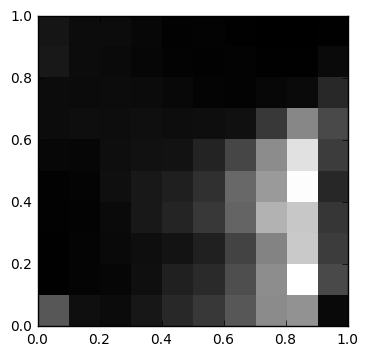

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0   947.0    19.0    18.0    28.0    32.0    76.0   138.0  139.0  268.0  228.0
1   165.0    51.0    49.0    36.0    44.0    71.0   156.0  127.0  132.0  139.0
2   121.0    70.0   100.0   109.0   165.0   153.0   142.0  136.0  108.0  138.0
3   251.0   171.0   155.0   268.0   263.0   193.0   167.0  125.0   65.0   76.0
4   431.0   358.0   206.0   394.0   337.0   203.0   144.0   89.0   38.0   30.0
5   609.0   454.0   360.0   605.0   520.0   382.0   151.0   46.0   32.0   33.0
6   945.0   847.0   732.0  1084.0  1127.0   763.0   182.0   39.0   40.0   17.0
7  1507.0  1523.0  1425.0  1921.0  1661.0  1510.0   611.0   83.0   17.0    0.0
8  1581.0  2758.0  2174.0  2144.0  2727.0  2433.0  1463.0  111.0   12.0    0.0
9   106.0   804.0   652.0   587.0   430.0   649.0   797.0  446.0  110.0   21.0
(10, 10)


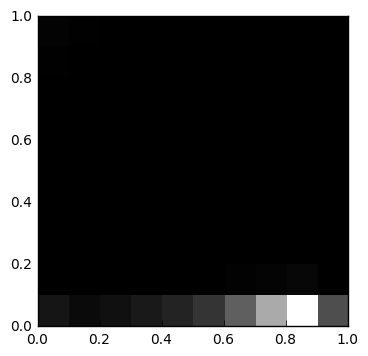

(10, 10)
         0      1     2     3     4     5     6     7     8      9
0   1276.0   35.0  54.0  33.0  58.0  38.0  51.0  57.0  73.0  218.0
1    619.0   35.0  30.0  32.0  31.0  37.0  24.0  41.0  30.0   91.0
2    968.0   35.0  32.0  21.0  20.0  34.0  39.0  41.0  25.0   27.0
3   1511.0   34.0  37.0  29.0  23.0  43.0  20.0  14.0  10.0   13.0
4   2066.0   37.0  40.0  31.0  10.0  20.0  10.0  10.0   4.0    2.0
5   3083.0   46.0  28.0  20.0   9.0   2.0   2.0   2.0   0.0    0.0
6   5587.0  120.0  43.0  24.0   2.0   0.0   0.0   0.0   0.0    0.0
7   9931.0  288.0  33.0   6.0   0.0   0.0   0.0   0.0   0.0    0.0
8  14953.0  424.0  26.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
9   4585.0   17.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
(10, 10)


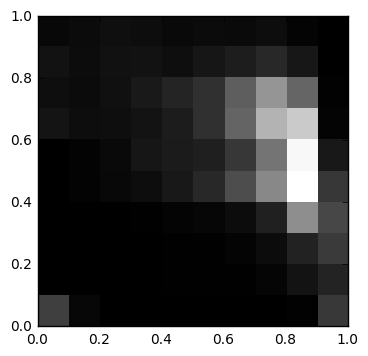

(10, 10)
       0      1      2       3       4       5       6       7      8      9
0  945.0    0.0    0.0     0.0     9.0    14.0   309.0   214.0  277.0  125.0
1  116.0    4.0   13.0     2.0    58.0    59.0   199.0   164.0  182.0  173.0
2   12.0    5.0    5.0     9.0   123.0   147.0   213.0   247.0  254.0  227.0
3    8.0   14.0   14.0    28.0   203.0   328.0   292.0   378.0  273.0  196.0
4    4.0   26.0   20.0    70.0   366.0   416.0   424.0   546.0  220.0  138.0
5   10.0   17.0   29.0   100.0   625.0   470.0   715.0   722.0  330.0  174.0
6   10.0   28.0   61.0   190.0  1154.0   830.0  1501.0  1407.0  437.0  158.0
7   14.0   75.0  188.0   480.0  2038.0  1733.0  2693.0  2224.0  614.0  199.0
8   41.0  284.0  507.0  2123.0  3812.0  3696.0  3016.0  1510.0  352.0   62.0
9  840.0  525.0  868.0  1065.0   829.0   369.0    72.0    34.0    0.0    0.0
(10, 10)


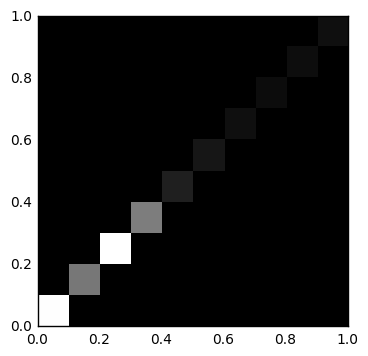

(10, 10)
         0       1        2       3       4       5      6      7      8  \
0  13878.0     0.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0   
1      0.0  6531.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0   
2      0.0     0.0  13979.0     0.0     0.0     0.0    0.0    0.0    0.0   
3      0.0     0.0      0.0  6852.0     0.0     0.0    0.0    0.0    0.0   
4      0.0     0.0      0.0     0.0  1722.0     0.0    0.0    0.0    0.0   
5      0.0     0.0      0.0     0.0     0.0  1218.0    0.0    0.0    0.0   
6      0.0     0.0      0.0     0.0     0.0     0.0  855.0    0.0    0.0   
7      0.0     0.0      0.0     0.0     0.0     0.0    0.0  671.0    0.0   
8      0.0     0.0      0.0     0.0     0.0     0.0    0.0    0.0  733.0   
9      0.0     0.0      0.0     0.0     0.0     0.0    0.0    0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  861.0  
(10, 10)


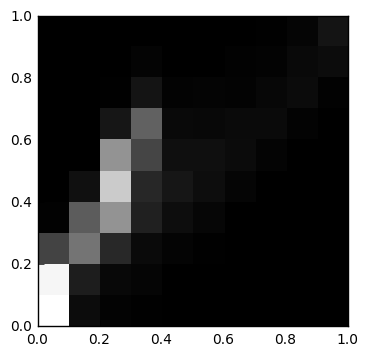

(10, 10)
        0       1       2       3       4       5       6      7      8      9
0  6212.0  5978.0  1632.0    56.0     0.0     0.0     0.0    0.0    0.0    0.0
1   309.0   727.0  2836.0  2250.0   407.0     2.0     0.0    0.0    0.0    0.0
2    97.0   199.0  1006.0  3605.0  4932.0  3571.0   535.0   34.0    0.0    0.0
3    43.0   126.0   244.0   778.0   965.0  1693.0  2357.0  509.0  116.0   21.0
4     2.0    21.0   118.0   320.0   541.0   387.0   232.0   97.0    4.0    0.0
5     0.0     4.0    35.0   147.0   316.0   386.0   217.0  100.0   13.0    0.0
6     0.0     0.0     0.0    20.0   130.0   285.0   264.0   94.0   60.0    2.0
7     0.0     0.0     0.0     0.0    13.0   101.0   256.0  177.0   82.0   42.0
8     0.0     0.0     0.0     0.0     2.0     8.0    82.0  278.0  232.0  131.0
9     0.0     0.0     0.0     0.0     0.0     0.0     8.0   52.0  315.0  486.0
(10, 10)


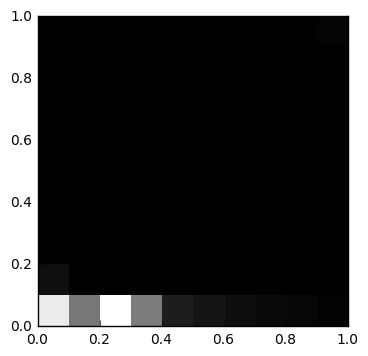

(10, 10)
         0      1      2     3     4     5     6     7     8      9
0  12899.0  843.0  102.0  24.0   6.0   0.0   0.0   0.0   0.0    4.0
1   6489.0   16.0   10.0  16.0   0.0   0.0   0.0   0.0   0.0    0.0
2  13937.0    8.0   18.0  12.0   4.0   0.0   0.0   0.0   0.0    0.0
3   6804.0   16.0   10.0   6.0   6.0   8.0   0.0   2.0   0.0    0.0
4   1610.0   27.0   21.0  21.0   9.0  14.0   6.0   8.0   2.0    4.0
5   1098.0   19.0   13.0  16.0  12.0  16.0  20.0   7.0   0.0   17.0
6    709.0   22.0   17.0  10.0  11.0  16.0  22.0  26.0  16.0    6.0
7    527.0   25.0   32.0  12.0  17.0  10.0   2.0  17.0   6.0   23.0
8    350.0   52.0   49.0  35.0  28.0  49.0  32.0  36.0  43.0   59.0
9    156.0   43.0   51.0  44.0  60.0  61.0  64.0  69.0  75.0  238.0
(10, 10)


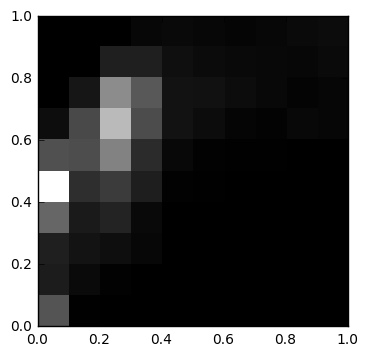

(10, 10)
        0      1      2       3       4       5       6       7      8      9
0  1963.0  670.0  733.0  2381.0  5948.0  1873.0   310.0     0.0    0.0    0.0
1    33.0  251.0  464.0   627.0  1086.0  1805.0  1739.0   521.0    5.0    0.0
2     4.0   49.0  334.0   822.0  1392.0  3031.0  4330.0  3263.0  732.0   22.0
3     0.0    8.0  172.0   218.0   699.0  1002.0  1769.0  2059.0  741.0  184.0
4     0.0    0.0    2.0    16.0    50.0   200.0   432.0   435.0  368.0  219.0
5     0.0    0.0    0.0     3.0    36.0    62.0   281.0   405.0  256.0  175.0
6     0.0    0.0    0.0     0.0     6.0    42.0   138.0   302.0  230.0  137.0
7     0.0    0.0    0.0     0.0     0.0    35.0    92.0   189.0  188.0  167.0
8     0.0    0.0    0.0     0.0     0.0    10.0   191.0   116.0  169.0  247.0
9     0.0    0.0    0.0     0.0     0.0     2.0   152.0   156.0  250.0  301.0
(10, 10)


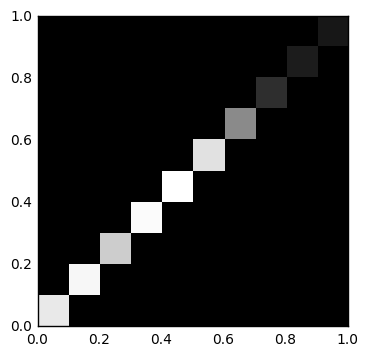

(10, 10)
        0       1       2       3       4       5       6       7      8  \
0  6663.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
1     0.0  7055.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   
2     0.0     0.0  5871.0     0.0     0.0     0.0     0.0     0.0    0.0   
3     0.0     0.0     0.0  7176.0     0.0     0.0     0.0     0.0    0.0   
4     0.0     0.0     0.0     0.0  7306.0     0.0     0.0     0.0    0.0   
5     0.0     0.0     0.0     0.0     0.0  6433.0     0.0     0.0    0.0   
6     0.0     0.0     0.0     0.0     0.0     0.0  3951.0     0.0    0.0   
7     0.0     0.0     0.0     0.0     0.0     0.0     0.0  1341.0    0.0   
8     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  822.0   
9     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0   

       9  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  
6    0.0  
7    0.0  
8    0.0  
9  682.0  
(10, 10)


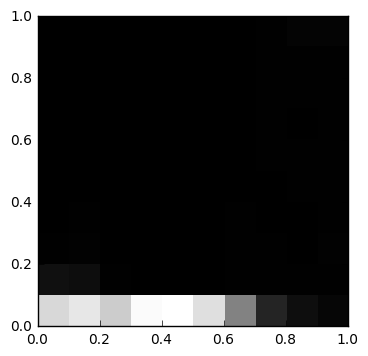

(10, 10)
        0      1     2     3     4     5     6     7     8      9
0  6146.0  466.0  47.0   0.0   0.0   0.0   0.0   0.0   0.0    4.0
1  6563.0  374.0  67.0  40.0   7.0   4.0   0.0   0.0   0.0    0.0
2  5788.0   29.0  16.0  10.0   8.0   2.0   2.0   8.0   2.0    6.0
3  7124.0    8.0   4.0  10.0   8.0  12.0   0.0   6.0   0.0    4.0
4  7259.0    8.0  12.0   8.0   0.0   2.0   9.0   0.0   4.0    4.0
5  6339.0   15.0  19.0  14.0  12.0   8.0   6.0  10.0   2.0    8.0
6  3709.0   48.0  38.0  31.0  20.0  22.0  18.0  27.0  14.0   24.0
7  1057.0   29.0  34.0  28.0  25.0  32.0  39.0  35.0  29.0   33.0
8   422.0   40.0  20.0  13.0  36.0  37.0  26.0  31.0  56.0  141.0
9   172.0   54.0  66.0  42.0  37.0  55.0  46.0  48.0  35.0  127.0
(10, 10)


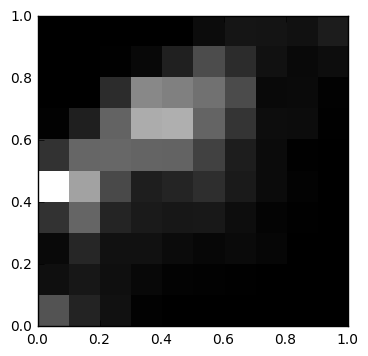

(10, 10)
        0      1      2       3       4       5       6       7       8      9
0  1192.0  218.0  129.0   723.0  3647.0   721.0    33.0     0.0     0.0    0.0
1   504.0  330.0  547.0  1446.0  2311.0  1463.0   453.0     1.0     0.0    0.0
2   252.0  219.0  255.0   534.0  1058.0  1470.0  1418.0   645.0    20.0    0.0
3    41.0  116.0  252.0   383.0   433.0  1427.0  2457.0  1941.0   125.0    1.0
4    11.0   48.0  158.0   337.0   519.0  1415.0  2507.0  1826.0   474.0   11.0
5     0.0   30.0  111.0   353.0   668.0   952.0  1426.0  1633.0  1088.0  172.0
6     0.0   17.0  148.0   188.0   374.0   426.0   759.0  1077.0   652.0  310.0
7     0.0    0.0   86.0    65.0   159.0   164.0   189.0   139.0   248.0  291.0
8     0.0    0.0   13.0    26.0    45.0    24.0   176.0   145.0   138.0  255.0
9     0.0    0.0    6.0    12.0     3.0     0.0    16.0    39.0   194.0  412.0
(10, 10)


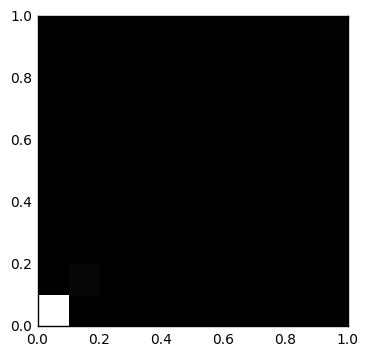

(10, 10)
         0       1      2      3      4      5      6      7      8      9
0  44579.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
1      0.0  1071.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
2      0.0     0.0  323.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
3      0.0     0.0    0.0  196.0    0.0    0.0    0.0    0.0    0.0    0.0
4      0.0     0.0    0.0    0.0  153.0    0.0    0.0    0.0    0.0    0.0
5      0.0     0.0    0.0    0.0    0.0  174.0    0.0    0.0    0.0    0.0
6      0.0     0.0    0.0    0.0    0.0    0.0  146.0    0.0    0.0    0.0
7      0.0     0.0    0.0    0.0    0.0    0.0    0.0  165.0    0.0    0.0
8      0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0  142.0    0.0
9      0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  351.0
(10, 10)


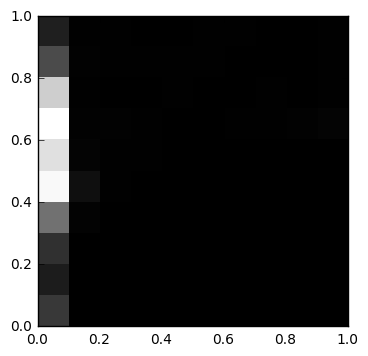

(10, 10)
        0      1       2       3       4       5       6       7       8  \
0  1994.0  974.0  1695.0  3939.0  8607.0  7733.0  8837.0  7133.0  2596.0   
1     2.0    4.0    10.0   121.0   530.0   141.0    85.0    42.0    75.0   
2     0.0    0.0     0.0     5.0    36.0    56.0    80.0    34.0    59.0   
3     0.0    0.0     0.0     0.0     4.0    38.0    56.0    26.0    43.0   
4     0.0    0.0     0.0     0.0     4.0    15.0    27.0    43.0    35.0   
5     0.0    0.0     0.0     0.0     6.0    16.0    34.0    28.0    48.0   
6     0.0    0.0     0.0     0.0     4.0     9.0    40.0    25.0    16.0   
7     0.0    0.0     0.0     0.0     8.0    16.0    57.0    35.0    19.0   
8     0.0    0.0     0.0     0.0     4.0     4.0    73.0    30.0    11.0   
9     4.0    0.0     0.0     2.0    14.0    34.0   145.0    50.0    37.0   

        9  
0  1071.0  
1    61.0  
2    53.0  
3    29.0  
4    29.0  
5    42.0  
6    52.0  
7    30.0  
8    20.0  
9    65.0  
(10, 10)


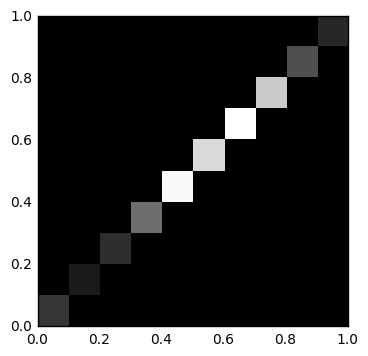

(10, 10)
        0      1       2       3       4       5       6       7       8  \
0  2000.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0  978.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0    0.0  1705.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0    0.0     0.0  4067.0     0.0     0.0     0.0     0.0     0.0   
4     0.0    0.0     0.0     0.0  9217.0     0.0     0.0     0.0     0.0   
5     0.0    0.0     0.0     0.0     0.0  8062.0     0.0     0.0     0.0   
6     0.0    0.0     0.0     0.0     0.0     0.0  9434.0     0.0     0.0   
7     0.0    0.0     0.0     0.0     0.0     0.0     0.0  7446.0     0.0   
8     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0  2939.0   
9     0.0    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

        9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9  1452.0  


In [115]:
make_scatter_plots(flylist[6])

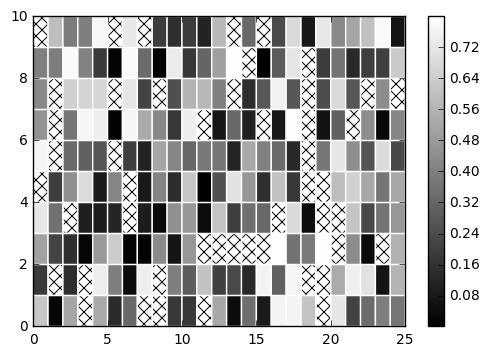

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.random.seed(1977)

data = np.random.random((10,25))
data = np.ma.masked_greater(data, 0.8)

fig, ax = plt.subplots()
im = ax.pcolormesh(data, cmap=cm.gray, edgecolors='white', linewidths=1,
                   antialiased=True)
fig.colorbar(im)

ax.patch.set(hatch='xx', edgecolor='black')

plt.show()

In [76]:
x = dta1 # between -10 and 4, log-gamma of an svc
y = dta2 # between -4 and 11, log-C of an svc
#z = data_z #between 0 and 0.78, f1-values from a difficult dataset


NameError: name 'dta1' is not defined

In [72]:
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from scipy.interpolate import griddata

In [ ]:
#determine grid boundaries
gridsize = 500
x_min = -8
x_max = 2.5
y_min = -2
y_max = 7

In [ ]:
xx = np.linspace(x_min, x_max, gridsize) # array of x values
yy = np.linspace(y_min, y_max, gridsize) # array of y values
grid = np.array(np.meshgrid(xx, yy.T))
grid = grid.reshape(2, grid.shape[1]*grid.shape[2]).T

In [ ]:
points = np.array([x, y]).T # because griddata wants it that way
z_grid2 = griddata(points, z, grid, method='nearest')
# you get a 1D vector as result. Reshape to picture format!
z_grid2 = z_grid2.reshape(xx.shape[0], yy.shape[0])

In [ ]:
fig = plt.figure(1, figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1.imshow(z_grid2, extent=[x_min, x_max,y_min, y_max,  ],
            origin='lower', cmap=cm.magma)
ax1.set_title("SVC: empty spots filled by nearest neighbours")
ax1.set_xlabel('log gamma')
ax1.set_ylabel('log C')
plt.show()

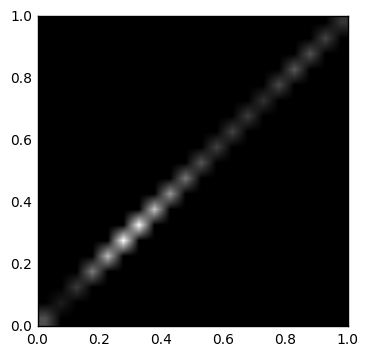

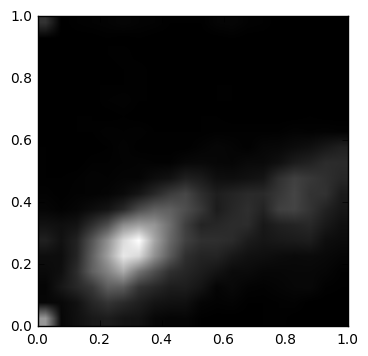

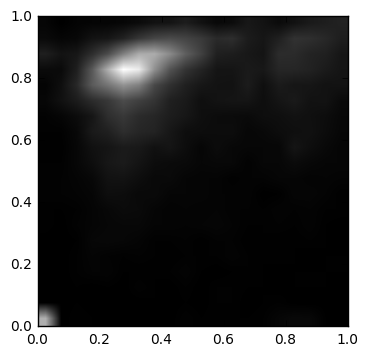

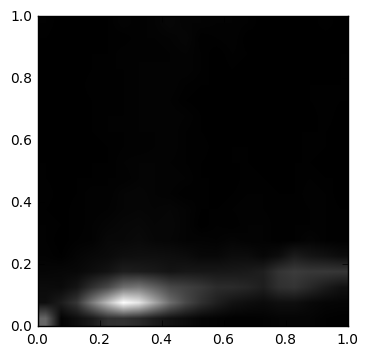

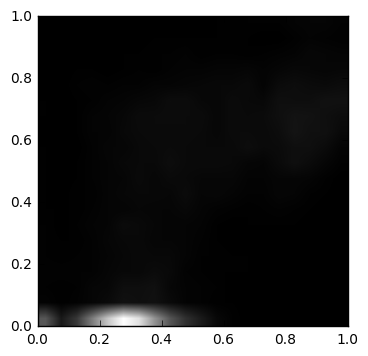

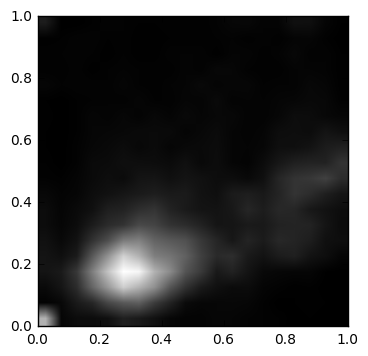

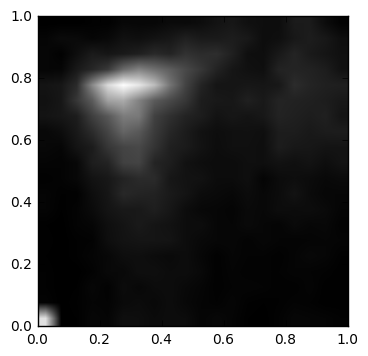

KeyboardInterrupt: 

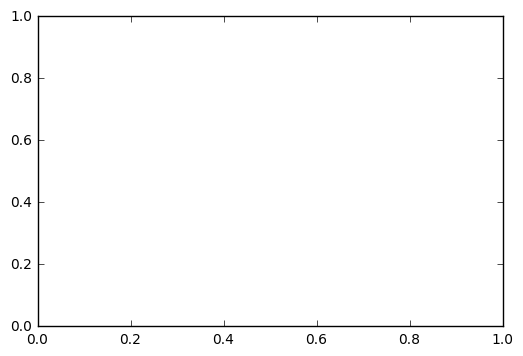

In [75]:
make_scatter_plots(flylist[6])